In [1]:
import pandas as pd
import os
import seaborn as sns

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")

from src.functions.embryo_df_performance_metrics import *


save_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123"

model_index = 74
df_orig = pd.read_csv("/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block01_iter030/SeqVAE_training_2024-11-11_15-45-40/figures/embryo_stats_df.csv")

z_mu_columns = [col for col in df_orig.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/11619956.1.trapnell-login.q/ipykernel_2123666/1123166587.py:20: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv("/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block01_iter030/SeqVAE_training_2024-11-11_15-45-40/figures/embryo_stats_df.csv"

# utility functions

In [7]:


def apply_pca_on_pert_comparisons(
    df, 
    z_mu_biological_columns, 
    pert_comparisons=None, 
    n_components=3
):
    """
    Applies PCA on a subset of the DataFrame based on specified perturbations and adds PCA components
    to the same DataFrame (rows not in 'pert_comparisons' are removed).

    Parameters:
    - df (pd.DataFrame): The original DataFrame containing the data.
    - z_mu_biological_columns (list): List of column names in df to use for PCA.
    - pert_comparisons (iterable, optional): An iterable (e.g., list) of phenotypes to include in PCA.
                                             If None, all unique phenotypes are used.
    - n_components (int, optional): Number of PCA components to compute. Default is 3.

    Returns:
    - pd.DataFrame: The filtered DataFrame (rows matching 'pert_comparisons') with added PCA columns.
    """
    # Ensure necessary columns exist
    required_columns = ['phenotype'] + z_mu_biological_columns
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"DataFrame is missing required columns: {missing_columns}")
    
    # Set pert_comparisons to all unique phenotypes if not provided
    if pert_comparisons is None:
        pert_comparisons = df['phenotype'].unique()
        print(f"No perturbations specified. Using all available phenotypes: {list(pert_comparisons)}")
    else:
        print(f"Using specified perturbations for PCA: {pert_comparisons}")

    # Filter the DataFrame based on 'pert_comparisons'
    df = df[df['phenotype'].isin(pert_comparisons)]
    
    # If no rows remain, raise an error
    if df.empty:
        raise ValueError("No data found for the specified perturbations in pert_comparisons.")
    
    # Extract the data for PCA
    X = df[z_mu_biological_columns].values
    
    # Handle missing values if any
    if pd.isnull(X).any():
        raise ValueError("Missing values detected in z_mu_biological_columns. "
                         "Please handle them before applying PCA.")
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(X)
    
    # Create PCA column names
    pca_columns = [f"PCA_{i+1}" for i in range(n_components)]
    
    # In-place assignment of PCA columns using a concise for loop
    # Initialize columns with NaN (optional) before assignment
    df.loc[:, pca_columns] = pd.NA
    
    for i, col in enumerate(pca_columns):
        df[col] = pcs[:, i]
    
    # Calculate Explained Variance
    explained_variance_ratio = pca.explained_variance_ratio_
    total_explained_variance = explained_variance_ratio.sum()
    
    # Print organized output
    print("\nPCA Explained Variance:")
    print("----------------------------")
    print(f"Total Explained Variance by {n_components} components: {total_explained_variance:.2%}\n")
    
    variance_data = {
        'Principal Component': pca_columns,
        'Explained Variance Ratio': [f"{ratio:.2%}" for ratio in explained_variance_ratio]
    }
    variance_df = pd.DataFrame(variance_data)
    print(variance_df.to_string(index=False))
    print("----------------------------\n")
    
    return df


from tqdm import tqdm


# ============================
# Utility Functions
# ============================
def compute_spline_distances(spline_pts):
    """Compute cumulative distances along the spline."""
    diffs = np.diff(spline_pts, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    cumdist = np.insert(np.cumsum(seg_lengths), 0, 0.0)
    return cumdist, cumdist[-1]

def split_spline(spline_pts, k):
    """
    Split the spline into k segments based on cumulative distance.
    Returns a list of (start_pt, end_pt) tuples.
    """
    cumdist, total_dist = compute_spline_distances(spline_pts)
    segment_distances = np.linspace(0, total_dist, k+1)
    segment_indices = np.searchsorted(cumdist, segment_distances)
    segment_list = []
    for i in range(k):
        i0 = min(segment_indices[i], len(spline_pts) - 1)
        i1 = min(segment_indices[i+1], len(spline_pts) - 1)
        start_pt = spline_pts[i0]
        end_pt = spline_pts[i1]
        segment_list.append((start_pt, end_pt))
    return segment_list

def point_to_segment_distance(point, seg_start, seg_end):
    """
    Minimum distance from a 3D point to a line segment defined by seg_start, seg_end.
    """
    seg_vec = seg_end - seg_start
    pt_vec = point - seg_start
    seg_len_sq = np.dot(seg_vec, seg_vec)
    if seg_len_sq == 0.0:
        return np.linalg.norm(point - seg_start)
    t = np.dot(pt_vec, seg_vec) / seg_len_sq
    t = np.clip(t, 0.0, 1.0)
    projection = seg_start + t * seg_vec
    return np.linalg.norm(point - projection)

def assign_points_to_segments(pert_df, segments):
    """
    Assign each point to the closest segment, create a 'segment_id' column in pert_df.
    """
    points = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values
    assigned_segments = []
    
    for p in points:
        min_dist = float('inf')
        seg_idx = -1
        for i, (s0, s1) in enumerate(segments):
            dist = point_to_segment_distance(p, s0, s1)
            if dist < min_dist:
                min_dist = dist
                seg_idx = i
        assigned_segments.append(seg_idx)
    
    pert_df["segment_id"] = assigned_segments
    return pert_df

def perform_robust_pca(seg_points):
    """
    Perform robust PCA using Minimum Covariance Determinant (MCD).
    Returns the principal axis (first eigenvector) or None if not enough points.
    """
    if len(seg_points) < 2:
        return None
    try:
        mcd = MinCovDet().fit(seg_points)
        cov = mcd.covariance_
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        principal_axis = eig_vecs[:, np.argmax(eig_vals)]
        principal_axis /= np.linalg.norm(principal_axis)
        return principal_axis
    except:
        # Fallback to standard PCA if MCD fails
        pca = PCA(n_components=3)
        pca.fit(seg_points)
        principal_axis = pca.components_[0]
        principal_axis /= np.linalg.norm(principal_axis)
        return principal_axis

def create_spline_segments_for_df(df, pert_splines, k=50):
    """
    For each phenotype in df, finds its spline in pert_splines, splits it into k segments,
    assigns each point to a segment, performs robust PCA for each segment, and returns:
    
    1) df_augmented: original df augmented with 'segment_id'
    2) segment_info_df: columns = [
        phenotype, seg_id, segment_avg_time, segment_var_time,
        principal_axis_x, principal_axis_y, principal_axis_z,
        segment_midpoint_x, segment_midpoint_y, segment_midpoint_z,
        segment_start_x, segment_start_y, segment_start_z,
        segment_end_x, segment_end_y, segment_end_z
    ]
    3) (optionally) return pert_splines, which is often unchanged
    """
    # 1. Copy df so we don't mutate the original
    df_augmented = df.copy()
    
    # 2. We'll store per-segment info in this list of dicts
    segment_info_records = []
    
    # 3. Loop over each phenotype
    unique_phenotypes = df_augmented["phenotype"].unique()
    for pert in tqdm(unique_phenotypes, desc="Processing phenotypes"):
        # A) Extract all points for this phenotype
        pert_df = df_augmented[df_augmented["phenotype"] == pert].copy()
        if pert_df.empty:
            continue
        
        # B) Retrieve the spline points for this phenotype
        spline_data = pert_splines[pert_splines["phenotype"] == pert]
        if spline_data.empty:
            continue
        
        # Convert to NumPy
        spline_points = spline_data[["PCA_1", "PCA_2", "PCA_3"]].values
        
        # C) Split the spline
        segment_list = split_spline(spline_points, k)
        
        # D) Assign points to segments
        pert_df = assign_points_to_segments(pert_df, segment_list)
        
        # E) Update df_augmented with new segment IDs
        df_augmented.loc[pert_df.index, "segment_id"] = pert_df["segment_id"]
        
        # F) For each segment, perform robust PCA
        seg_data_dict = {}
        for seg_id in range(k):
            seg_points_df = pert_df[pert_df["segment_id"] == seg_id]
            seg_points = seg_points_df[["PCA_1", "PCA_2", "PCA_3"]].values
            
            if len(seg_points) < 2:
                principal_axis = None
            else:
                principal_axis = perform_robust_pca(seg_points)
            
            seg_start, seg_end = segment_list[seg_id]
            midpoint = 0.5 * (seg_start + seg_end)
            
            seg_data_dict[seg_id] = {
                "principal_axis": principal_axis,
                "segment_midpoint": midpoint,
                "segment_start": seg_start,
                "segment_end": seg_end,
                "segment_avg_time": seg_points_df["predicted_stage_hpf"].mean(),
                "segment_var_time": seg_points_df["predicted_stage_hpf"].var()
            }
        
        # G) Build segment_info_records
        for seg_id, info in seg_data_dict.items():
            principal_axis = info["principal_axis"]
            midpoint = info["segment_midpoint"]
            seg_start = info["segment_start"]
            seg_end = info["segment_end"]
            segment_avg_time = info["segment_avg_time"]
            segment_var_time = info["segment_var_time"]
            
            if principal_axis is None:
                px, py, pz = np.nan, np.nan, np.nan
            else:
                px, py, pz = principal_axis
            
            mx, my, mz = midpoint
            sx, sy, sz = seg_start
            ex, ey, ez = seg_end
            
            record = {
                "phenotype": pert,
                "seg_id": seg_id,
                "segment_avg_time": segment_avg_time,
                "segment_var_time": segment_var_time,
                "principal_axis_x": px,
                "principal_axis_y": py,
                "principal_axis_z": pz,
                "segment_midpoint_x": mx,
                "segment_midpoint_y": my,
                "segment_midpoint_z": mz,
                "segment_start_x": sx,
                "segment_start_y": sy,
                "segment_start_z": sz,
                "segment_end_x": ex,
                "segment_end_y": ey,
                "segment_end_z": ez
            }
            segment_info_records.append(record)
    
    # 4. Convert records to DataFrame
    segment_info_df = pd.DataFrame(segment_info_records)
    return df_augmented, segment_info_df, pert_splines

# ============================
# Main Wrapper Function
# ============================
def build_splines_and_segments(
    df,
    save_dir,
    model_index,
    LocalPrincipalCurveClass,
    comparisons=None,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=50
):
    """
    1) Builds splines for each phenotype in `comparisons` using LocalPrincipalCurve
    2) Creates `df_augmented` by assigning segment IDs for each phenotype
    3) Returns `pert_splines`, `df_augmented`, and `segment_info_df`
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing at least ["phenotype", "PCA_1", "PCA_2", "PCA_3", "predicted_stage_hpf"].
    comparisons : list
        List of phenotypes to process.
    save_dir : str
        Directory to save the spline CSV if desired.
    model_index : int
        Model index used in naming output files.
    LocalPrincipalCurveClass : class
        Reference to your LocalPrincipalCurve class (or a similar spline-fitting class).
    bandwidth : float
        Bandwidth parameter for LocalPrincipalCurve.
    max_iter : int
        Max iterations for LocalPrincipalCurve fitting.
    tol : float
        Tolerance for LocalPrincipalCurve convergence.
    angle_penalty_exp : int
        Angle penalty exponent for LocalPrincipalCurve.
    early_stage_offset : float
        Window (in hours) for selecting "early" timepoints to compute the average start point.
    late_stage_offset : float
        Window (in hours) for selecting "late" timepoints to compute the average end point.
    k : int
        Number of segments to split each spline into.

    Returns
    -------
    pert_splines : pd.DataFrame
        DataFrame containing the spline points for each phenotype.
    df_augmented : pd.DataFrame
        Original DataFrame plus a `segment_id` column.
    segment_info_df : pd.DataFrame
        Per-segment PCA info (principal_axis, midpoint, etc.).
    """
    
    # ----------------------------
    # 1. Generate a color palette
    # and Handle `comparisons` Parameter
    # ----------------------------
    if comparisons is None:
        comparisons = list(df["phenotype"].unique())
        print(f"No comparisons specified. Using all available phenotypes: {comparisons}")
    else:
        print(f"Using specified comparisons for spline building: {comparisons}")
        

    color_palette = px.colors.qualitative.Plotly
    if len(comparisons) > len(color_palette):
        extended_palette = color_palette * (len(comparisons) // len(color_palette) + 1)
    else:
        extended_palette = color_palette

    # ----------------------------
    # 2. Build Spline Data
    # ----------------------------
    print("Building spline data for each phenotype...")
    splines_records = []

    df = df[df["phenotype"].isin(comparisons)]
    
    for idx, pert in enumerate(tqdm(comparisons, desc="Creating splines for each phenotype")):
        # Filter the DataFrame for the given phenotype
        pert_df = df[df["phenotype"] == pert].copy()
        if pert_df.empty:
            # If no data points for this phenotype, skip
            continue

        # Extract PCA coordinates
        pert_3d = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values
        
        # Compute average early stage point
        min_time = pert_df["predicted_stage_hpf"].min()
        early_mask = (pert_df["predicted_stage_hpf"] >= min_time) & \
                     (pert_df["predicted_stage_hpf"] < min_time + early_stage_offset)
        avg_early_timepoint = pert_df.loc[early_mask, ["PCA_1", "PCA_2", "PCA_3"]].mean().values
        
        # Compute average late stage point
        max_time = pert_df["predicted_stage_hpf"].max()
        late_mask = (pert_df["predicted_stage_hpf"] >= (max_time - late_stage_offset))
        avg_late_timepoint = pert_df.loc[late_mask, ["PCA_1", "PCA_2", "PCA_3"]].mean().values

        # Downsample for curve fitting (example: 5% for wt, 10% for others)
        if len(pert_3d) == 0:
            continue
        
        if pert == "wt":
            subset_size = max(1, int(0.05 * len(pert_3d)))
        else:
            subset_size = max(1, int(0.10 * len(pert_3d)))

        # Randomly select a subset of points for fitting
        rng = np.random.RandomState(42)
        subset_indices = rng.choice(len(pert_3d), size=subset_size, replace=False)
        pert_3d_subset = pert_3d[subset_indices, :]

        # Fit LocalPrincipalCurve
        lpc = LocalPrincipalCurveClass(
            bandwidth=bandwidth,
            max_iter=max_iter,
            tol=tol,
            angle_penalty_exp=angle_penalty_exp
        )
        
        # Fit with the optional start_points/end_point to anchor the spline
        lpc.fit(
            pert_3d_subset,
            start_points=avg_early_timepoint,
            end_point=avg_late_timepoint,
            remove_similar_end_start_points=True
        )
        
        spline_points = None
        if len(lpc.cubic_splines) > 0:
            # If your local principal curve class stores the final spline
            spline_points = lpc.cubic_splines[0]
        else:
            # If no spline was built, skip
            continue
        
        # Create a temporary DataFrame for the current spline
        spline_df = pd.DataFrame(spline_points, columns=["PCA_1", "PCA_2", "PCA_3"])
        spline_df["phenotype"] = pert
        
        # Collect for later concatenation
        splines_records.append(spline_df)

    # Concatenate all spline DataFrames
    if splines_records:
        pert_splines = pd.concat(splines_records, ignore_index=True)
    else:
        # Fallback to an empty DataFrame if no splines
        pert_splines = pd.DataFrame(columns=["PCA_1", "PCA_2", "PCA_3", "phenotype"])

    # Optionally, save the spline data
    spline_csv_path = os.path.join(save_dir, f"pert_splines_{model_index}_unique.csv")
    pert_splines.to_csv(spline_csv_path, index=False)
    print(f"Spline DataFrame 'pert_splines' saved to: {spline_csv_path}")

    # ----------------------------
    # 3. Create segments for each phenotype using the function above
    # ----------------------------
    print("Assigning segments and building segment_info_df...")
    df_augmented, segment_info_df, pert_splines_out = create_spline_segments_for_df(
        df=df,
        pert_splines=pert_splines,
        k=k
    )

    # Return all three final structures
    return pert_splines_out, df_augmented, segment_info_df


def point_to_segment_projection(p, seg_start, seg_end):
    """
    Return the closest point on the line segment [seg_start, seg_end] to p
    and the distance from p to that point.
    
    p, seg_start, seg_end are all 3D numpy arrays.
    """
    seg_vec = seg_end - seg_start
    pt_vec = p - seg_start
    seg_len_sq = np.dot(seg_vec, seg_vec)
    
    if seg_len_sq == 0.0:
        # Degenerate segment; closest point is seg_start
        return seg_start, np.linalg.norm(p - seg_start)
    
    t = np.dot(pt_vec, seg_vec) / seg_len_sq
    t_clamped = np.clip(t, 0.0, 1.0)
    closest = seg_start + t_clamped * seg_vec
    dist = np.linalg.norm(p - closest)
    return closest, dist

def project_onto_plane(p, midpoint, normal):
    """
    Given:
      - p: a 3D point (numpy array)
      - midpoint: a 3D point on the plane
      - normal: the plane's normal (3D)
    Returns:
      - plane_point: orthogonal projection of p onto the plane
      - distance_to_plane: absolute distance from p to the plane
      - distance_to_axis: distance from p to the principal axis (line through midpoint in direction normal)
      - hypotenuse: sqrt(distance_to_plane^2 + distance_to_axis^2)
    """
    # (Assume normal is unit-length. If not, we should normalize it.)
    # alpha = (p - m) · n
    alpha = np.dot((p - midpoint), normal)
    
    # plane_point = p - alpha * n
    plane_point = p - alpha * normal
    
    distance_to_plane = abs(alpha)  # since normal is unit
    # The "axis" is the line { midpoint + t * normal }, so the closest point on the axis is midpoint + alpha * normal
    closest_on_axis = midpoint + alpha * normal
    distance_to_axis = np.linalg.norm(p - closest_on_axis)
    hypotenuse = np.sqrt(distance_to_plane**2 + distance_to_axis**2)
    
    return plane_point, distance_to_plane, distance_to_axis, hypotenuse


def project_points_onto_reference_spline(
    df_points,
    reference_spline_info,
    k_segments=None
):
    """
    Projects the rows in df_points onto a reference spline (and planes) given by reference_spline_info.
    
    Steps:
      1. For each point in df_points:
         - Find the closest segment in reference_spline_info by line-segment distance.
         - Let 'seg_id' = that segment's ID.
      2. Use the principal axis (plane normal) and midpoint of that segment to project the point onto the plane.
      3. Also compute the closest point on the line segment in 3D.
      4. Record all relevant distances (distance_to_plane, distance_to_axis, hypotenuse, etc.).
    
    Returns a new DataFrame 'projection_df' with columns:
      [ snip_id, embryo_id, phenotype, predicted_stage_hpf,
        PCA_1, PCA_2, PCA_3,
        ref_seg_id, 
        closest_on_spline_x, closest_on_spline_y, closest_on_spline_z,
        plane_point_x, plane_point_y, plane_point_z,
        distance_to_plane, distance_to_axis, hypotenuse
      ]
    """
    # 1) Convert reference_spline_info into a structure for quick iteration
    #    Each segment row: seg_id, principal_axis, midpoint, seg_start, seg_end
    segment_dicts = []
    for _, row in reference_spline_info.iterrows():
        seg_id = row["seg_id"]
        
        principal_axis = np.array([
            row["principal_axis_x"],
            row["principal_axis_y"],
            row["principal_axis_z"]
        ], dtype=float)
        
        midpoint = np.array([
            row["segment_midpoint_x"],
            row["segment_midpoint_y"],
            row["segment_midpoint_z"]
        ], dtype=float)
        
        seg_start = np.array([
            row["segment_start_x"],
            row["segment_start_y"],
            row["segment_start_z"]
        ], dtype=float)
        
        seg_end = np.array([
            row["segment_end_x"],
            row["segment_end_y"],
            row["segment_end_z"]
        ], dtype=float)
        
        # Optional: if principal_axis is not guaranteed unit length, normalize it
        norm = np.linalg.norm(principal_axis)
        if norm > 1e-12:
            principal_axis = principal_axis / norm
        
        segment_dicts.append({
            "seg_id": seg_id,
            "principal_axis": principal_axis,
            "midpoint": midpoint,
            "seg_start": seg_start,
            "seg_end": seg_end
        })
        
    # 2) For each point in df_points, find the closest segment
    records = []
    
    # We'll iterate over df_points rows
    for idx, row in df_points.iterrows():
        # Extract the 3D point
        p = np.array([row["PCA_1"], row["PCA_2"], row["PCA_3"]], dtype=float)
        
        # Find the segment that yields the smallest distance
        min_dist = np.inf
        best_segment = None
        
        for seg_info in segment_dicts:
            closest_pt, dist = point_to_segment_projection(p, seg_info["seg_start"], seg_info["seg_end"])
            if dist < min_dist:
                min_dist = dist
                best_segment = seg_info
        
        if best_segment is None:
            # In an extreme edge case, if we can't find anything, skip
            continue
        
        # Now project onto the plane for this best segment
        principal_axis = best_segment["principal_axis"]
        midpoint = best_segment["midpoint"]
        seg_id = best_segment["seg_id"]
        seg_start = best_segment["seg_start"]
        seg_end = best_segment["seg_end"]
        
        # 3) Closest point on the segment itself
        closest_on_spline, _ = point_to_segment_projection(p, seg_start, seg_end)
        
        # 4) Plane projection
        plane_point, distance_to_plane, distance_to_axis, hypotenuse = project_onto_plane(p, midpoint, principal_axis)
        
        record = {
            "snip_id": row.get("snip_id", None),
            "embryo_id": row.get("embryo_id", None),
            "phenotype": row.get("phenotype", None),
            "predicted_stage_hpf": row.get("predicted_stage_hpf", None),
            
            "PCA_1": p[0],
            "PCA_2": p[1],
            "PCA_3": p[2],
            
            "ref_seg_id": seg_id,  # The segment this point ended up belonging to
            "closest_on_spline_x": closest_on_spline[0],
            "closest_on_spline_y": closest_on_spline[1],
            "closest_on_spline_z": closest_on_spline[2],
            
            "plane_point_x": plane_point[0],
            "plane_point_y": plane_point[1],
            "plane_point_z": plane_point[2],
            
            "distance_to_plane": distance_to_plane,
            "distance_to_axis": distance_to_axis,
            "hypotenuse": hypotenuse
        }
        records.append(record)
    
    projection_df = pd.DataFrame(records)

    return projection_df


def plot_3d_spline_and_projections(
    projection_dfs,
    segment_info_df,
    pert_splines=None,
    save_dir=None,
    filename="splines_with_plane.html",
    k=None,
    title="3D Visualization of Spline and Projections",
    plane_opacity=0.2,
    axis_length=0.5,
    show_legend=True,
    plane_size=1.0,
    plane_grid_steps=10
):
    """
    Plots a 3D visualization of:
      1) The reference spline (if `pert_splines` is provided).
      2) Multiple sets of projected points (`projection_dfs`), each with columns:
         ["PCA_1", "PCA_2", "PCA_3", "ref_seg_id", "phenotype", ...]
         Points are colored by their 'ref_seg_id' to the reference spline.
      3) Principal axes for each segment (from `segment_info_df`).
      4) Plane surfaces (also from `segment_info_df`), each as a separate toggleable trace.

    Parameters
    ----------
    projection_dfs : list or pd.DataFrame
        One or more DataFrames of projected points.  
        Each DataFrame should have at least columns:
            ["PCA_1", "PCA_2", "PCA_3", "ref_seg_id", "phenotype", ...]
        where 'ref_seg_id' is the segment on the reference spline to which the point was assigned.
    segment_info_df : pd.DataFrame
        The reference segment info (e.g., from WT) with columns like:
            [
              "seg_id",
              "principal_axis_x", "principal_axis_y", "principal_axis_z",
              "segment_midpoint_x", "segment_midpoint_y", "segment_midpoint_z",
              "segment_start_x",   "segment_start_y",   "segment_start_z",
              "segment_end_x",     "segment_end_y",     "segment_end_z",
              "phenotype" (optional, if relevant)
            ]
        This defines the planes, principal axes, etc.
    pert_splines : pd.DataFrame or None
        Optional. If provided, plots the reference spline line.
        Columns expected: ["phenotype", "PCA_1", "PCA_2", "PCA_3"].
    save_dir : str or None
        If provided, the figure is saved as an HTML file in this directory.
    filename : str
        File name for the output HTML file.
    k : int or None
        Number of segments. If None, we infer it from `segment_info_df`.
    title : str
        Title for the figure.
    plane_opacity : float
        Opacity (0 to 1) for the plane surfaces.
    axis_length : float
        Half-length for drawing the principal axis line from each segment's midpoint.
    show_legend : bool
        Whether to show the Plotly legend.
    plane_size : float
        Half-width/height of the plane patch to draw around the midpoint.
    plane_grid_steps : int
        Resolution of the mesh for plane surfaces.

    Returns
    -------
    fig : plotly.graph_objs._figure.Figure
        The constructed 3D Plotly figure.
    """
    # ---------------------------------------------------------------------
    # 0. Handle the case if a single DataFrame is passed instead of a list
    # ---------------------------------------------------------------------
    if isinstance(projection_dfs, pd.DataFrame):
        projection_dfs = [projection_dfs]
    
    # ---------------------------------------------------------------------
    # 1. Initialize the figure and color palette
    # ---------------------------------------------------------------------
    fig = go.Figure()
    color_palette = px.colors.qualitative.Dark24  # Up to 24 distinct colors

    # If k not provided, try to deduce from 'segment_info_df'
    if k is None:
        if not segment_info_df.empty:
            k = int(segment_info_df["seg_id"].max()) + 1
        else:
            k = 1

    # ---------------------------------------------------------------------
    # 2. Plot the reference spline (if provided)
    # ---------------------------------------------------------------------
    if pert_splines is not None and not pert_splines.empty:
        # We assume there's only ONE reference phenotype for the spline,
        # or we can just loop if multiple. Here, let's loop for each phenotype:
        for pert in pert_splines["phenotype"].unique():
            spline_df = pert_splines[pert_splines["phenotype"] == pert]
            spline_pts = spline_df[["PCA_1", "PCA_2", "PCA_3"]].values
            if len(spline_pts) < 2:
                continue

            fig.add_trace(go.Scatter3d(
                x=spline_pts[:, 0],
                y=spline_pts[:, 1],
                z=spline_pts[:, 2],
                mode='lines+markers',
                name=f"Spline ({pert})",
                line=dict(color='black', width=4),
                marker=dict(size=3, color='black'),
                legendgroup=f"Spline_{pert}",
            ))

    # ---------------------------------------------------------------------
    # 3. Plot each projection DataFrame, coloring points by segment
    # ---------------------------------------------------------------------
    # We create separate traces for each (phenotype, seg_id) within each DataFrame,
    # so that each perturbation can be toggled individually.
    for df_idx, proj_df in enumerate(projection_dfs):
        # Group by (phenotype, ref_seg_id). 
        # If 'phenotype' isn't present, group by ref_seg_id only (fallback).
        group_cols = ["ref_seg_id"]
        if "phenotype" in proj_df.columns:
            group_cols = ["phenotype", "ref_seg_id"]
        
        grouped = proj_df.groupby(group_cols)

        for key_tuple, group_data in grouped:
            if len(group_cols) == 2:
                pert, seg_id = key_tuple
            else:
                # If we only grouped by ref_seg_id, we have no phenotype info
                seg_id = key_tuple
                pert   = f"ProjDF_{df_idx}"  # fallback label

            # Convert seg_id to int if possible
            try:
                seg_id = int(seg_id)
            except:
                pass

            color_idx = seg_id % len(color_palette) if isinstance(seg_id, int) else 0
            seg_color = color_palette[color_idx]

            fig.add_trace(go.Scatter3d(
                x=group_data["PCA_1"],
                y=group_data["PCA_2"],
                z=group_data["PCA_3"],
                mode='markers',
                name=f"{pert} - seg {seg_id}",
                marker=dict(size=3, color=seg_color, opacity=0.7),
                legendgroup=pert,  
            ))

    # ---------------------------------------------------------------------
    # 4. Plot principal axis lines for each segment in the reference
    # ---------------------------------------------------------------------
    # segment_info_df might contain multiple phenotypes if you merged them,
    # but presumably for a single reference, it's just one phenotype or none.
    # We'll group by seg_id to handle it generally.
    for seg_id, seg_row_df in segment_info_df.groupby("seg_id"):
        # There's typically just 1 row for each (phenotype, seg_id), but let's handle n rows
        for _, row in seg_row_df.iterrows():
            px_ = row.get("principal_axis_x", np.nan)
            py_ = row.get("principal_axis_y", np.nan)
            pz_ = row.get("principal_axis_z", np.nan)
            if pd.isnull(px_) or pd.isnull(py_) or pd.isnull(pz_):
                continue
            
            principal_axis = np.array([px_, py_, pz_], dtype=float)
            midpoint = np.array([
                row.get("segment_midpoint_x", 0),
                row.get("segment_midpoint_y", 0),
                row.get("segment_midpoint_z", 0)
            ], dtype=float)

            color_idx = int(seg_id) % len(color_palette)
            axis_color = color_palette[color_idx]

            start_line = midpoint - axis_length * principal_axis
            end_line   = midpoint + axis_length * principal_axis

            fig.add_trace(go.Scatter3d(
                x=[start_line[0], end_line[0]],
                y=[start_line[1], end_line[1]],
                z=[start_line[2], end_line[2]],
                mode='lines',
                line=dict(color=axis_color, width=5),
                name=f"Axis seg {seg_id}",
                legendgroup="ReferenceAxes"
            ))

    # ---------------------------------------------------------------------
    # 5. Plot planes for each segment in the reference
    # ---------------------------------------------------------------------
    # Each plane is added as a separate trace for toggling.
    for seg_id, seg_row_df in segment_info_df.groupby("seg_id"):
        for _, row in seg_row_df.iterrows():
            # Normal
            px_ = row.get("principal_axis_x", np.nan)
            py_ = row.get("principal_axis_y", np.nan)
            pz_ = row.get("principal_axis_z", np.nan)
            if pd.isnull(px_) or pd.isnull(py_) or pd.isnull(pz_):
                continue

            plane_normal = np.array([px_, py_, pz_], dtype=float)
            norm_mag = np.linalg.norm(plane_normal)
            if norm_mag < 1e-12:
                continue

            midpoint = np.array([
                row.get("segment_midpoint_x", 0),
                row.get("segment_midpoint_y", 0),
                row.get("segment_midpoint_z", 0)
            ], dtype=float)
            d = -np.dot(plane_normal, midpoint)

            color_idx = int(seg_id) % len(color_palette)
            plane_color = color_palette[color_idx]

            # Build a grid
            xx, yy = np.meshgrid(
                np.linspace(midpoint[0] - plane_size, midpoint[0] + plane_size, plane_grid_steps),
                np.linspace(midpoint[1] - plane_size, midpoint[1] + plane_size, plane_grid_steps)
            )

            if abs(plane_normal[2]) > 1e-12:
                zz = (-plane_normal[0]*xx - plane_normal[1]*yy - d) / plane_normal[2]
            else:
                # Plane is vertical in Z
                zz = np.full_like(xx, midpoint[2])

            fig.add_trace(go.Surface(
                x=xx,
                y=yy,
                z=zz,
                opacity=plane_opacity,
                colorscale=[[0, plane_color], [1, plane_color]],
                showscale=False,
                name=f"Plane seg {seg_id}",
                legendgroup="ReferencePlanes",
            ))

    # ---------------------------------------------------------------------
    # 6. Final layout updates
    # ---------------------------------------------------------------------
    fig.update_layout(
        scene=dict(
            xaxis_title="PCA_1",
            yaxis_title="PCA_2",
            zaxis_title="PCA_3",
            aspectmode='data'
        ),
        width=1200,
        height=800,
        title=title,
        showlegend=show_legend
    )

    # Optionally save to HTML
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        outpath = os.path.join(save_dir, filename)
        fig.write_html(outpath)
        print(f"3D visualization saved to: {outpath}")
    else:
        print("3D visualization not saved (no save_dir provided).")

    return fig

import numpy as np
import random

# Optional: Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

def annotate_embryo_time_index(df_augmented):
    """
    Adds a 'within_embryo_t_idx' column to df_augmented,
    indicating the order of each snip_id within its embryo based on experiment_time.
    """
    df_augmented = df_augmented.copy()
    df_augmented["within_embryo_t_idx"] = (
        df_augmented.sort_values(by=["embryo_id", "experiment_time"])
                   .groupby("embryo_id")
                   .cumcount()
    )
    return df_augmented

def preprocess_embryo_data(df_augmented):
    """
    Returns a dictionary: { embryo_id: sorted_df }
    where sorted_df is df for that embryo sorted by experiment_time.
    """
    embryo_dict = {}
    grouped = df_augmented.groupby('embryo_id')
    for emb_id, emb_df in grouped:
        # Sort by experiment_time ascending
        emb_df_sorted = emb_df.sort_values(by='experiment_time').reset_index(drop=True)
        embryo_dict[emb_id] = emb_df_sorted
    return embryo_dict

def single_random_journey(
    embryo_dict,
    df_augmented,
    segments_sorted=None,
    start_segment=0,
    end_segment=None,
    max_hops=10_000,
    time_column = "experiment_time",
    segment_id_col= "ref_seg_id",
):
    """
    Generates a single random 'journey' from start_segment to end_segment 
    (inclusive). If end_segment is None, picks the max segment from segments_sorted.

    Parameters:
    - embryo_dict: {embryo_id: DataFrame sorted by experiment_time}
    - df_augmented: DataFrame with 'segment_id', 'embryo_id', 'snip_id', 'experiment_time', 'within_embryo_t_idx'
    - segments_sorted: list of unique segment IDs sorted in ascending order
    - start_segment: int, starting segment ID
    - end_segment: int, ending segment ID
    - max_hops: int, maximum steps to prevent infinite loops

    Returns:
    - journey: list of dicts with keys [segment_id_col, 'embryo_id', 'snip_id', 'cumulative_time']
    """
    if segments_sorted is None:
        segments_sorted = sorted(df_augmented[segment_id_col].unique())
    if end_segment is None:
        end_segment = max(segments_sorted)

    total_time = 0.0
    journey = []
    current_segment = start_segment

    # Select a random starting point in start_segment
    start_candidates = df_augmented[df_augmented[segment_id_col] == current_segment]
    if start_candidates.empty:
        # No points in start_segment; cannot start journey
        return journey

    row_start = start_candidates.sample(n=1).iloc[0]
    curr_emb_id = row_start["embryo_id"]
    curr_snip_id = row_start["snip_id"]
    # Record first step with cumulative_time = 0
    journey.append({
        "segment_id": current_segment,
        "embryo_id": curr_emb_id,
        "snip_id": curr_snip_id,
        "cumulative_time": total_time
    })

    # Access the sorted embryo DataFrame
    emb_df = embryo_dict[curr_emb_id]
    # Find the index of the starting snip_id
    try:
        row_index = emb_df.index[emb_df["snip_id"] == curr_snip_id][0]
    except IndexError:
        # snip_id not found in embryo_dict; abort journey
        return journey

    hop_count = 0

    while current_segment < end_segment and hop_count < max_hops:
        hop_count += 1
        next_index = row_index + 1
        possible_move = False

        if next_index < len(emb_df):
            # There's a next time point in the same embryo
            row_next = emb_df.iloc[next_index]
            next_seg = row_next[segment_id_col]
            delta_t = row_next[time_column] - emb_df.iloc[row_index][time_column]

            if next_seg == current_segment:
                # Remain in the same segment
                total_time += delta_t
                journey.append({
                    "segment_id": current_segment,
                    "embryo_id": curr_emb_id,
                    "snip_id": row_next["snip_id"],
                    "cumulative_time": total_time
                })
                row_index = next_index
                possible_move = True
            elif next_seg > current_segment:
                # Move to a higher segment
                total_time += delta_t
                current_segment = next_seg
                journey.append({
                    "segment_id": current_segment,
                    "embryo_id": curr_emb_id,
                    "snip_id": row_next["snip_id"],
                    "cumulative_time": total_time
                })
                row_index = next_index
                possible_move = True
            else:
                # next_seg < current_segment; treat as no move
                pass

        if not possible_move:
            # Move to embryo in the current segment by jumping to a random embryo's point in that segment
            possible_segments = [seg for seg in segments_sorted if seg >= current_segment]
            if not possible_segments:
                # Reached the final segment; end journey
                break
            next_segment = min(possible_segments)  # Immediate next segment

            # Select a random point in next_segment
            next_seg_candidates = df_augmented[df_augmented[segment_id_col] == next_segment]
            if next_seg_candidates.empty:
                # No points in next_segment; cannot proceed
                break

            row_new = next_seg_candidates.sample(n=1).iloc[0]
            new_emb_id = row_new["embryo_id"]
            new_snip_id = row_new["snip_id"]

            # Update current position
            current_segment = next_segment
            curr_emb_id = new_emb_id
            curr_snip_id = new_snip_id
            emb_df = embryo_dict[curr_emb_id]

            try:
                row_index = emb_df.index[emb_df["snip_id"] == new_snip_id][0]
            except IndexError:
                # snip_id not found; skip to next journey
                break

            # No time accumulated when jumping to a different embryo
            journey.append({
                "segment_id": current_segment,
                "embryo_id": curr_emb_id,
                "snip_id": curr_snip_id,
                "cumulative_time": total_time
            })

    return journey

def run_bootstrap_journeys(
    df_augmented,
    num_journeys=1000,
    start_segment=0,
    end_segment=None,
    random_seed=42,
    time_column = "experiment_time",
    segment_id_col = "segment_id"
):
    """
    Repeatedly runs single_random_journey and collects results in a DataFrame.

    Parameters:
    - df_augmented: DataFrame with necessary columns
    - num_journeys: int, number of bootstrap journeys to run
    - start_segment: int, starting segment ID
    - end_segment: int, ending segment ID (if None, uses max segment)
    - random_seed: int, for reproducibility

    Returns:
    - journeys_df: DataFrame with all journey steps
    """
    # Set random seeds
    np.random.seed(random_seed)
    random.seed(random_seed)

    # 1. Annotate the 'within_embryo_t_idx'
    df_aug = annotate_embryo_time_index(df_augmented)

    # Make sure there is an embryo in the star segment 

    start_segment_init = start_segment
    while True:
        start_candidates = df_aug[df_aug[segment_id_col] == start_segment]
    
        if not start_candidates.empty:
            # Valid start segment found
            print(f"No start candidates in segment {start_segment_init}."
                f"The next closest start candidate is in segment {start_segment}.")
            break  # Exit the loop when a valid start segment is found
        
            # Increment start_segment and continue the search
        start_segment += 1

    # 2. Build embryo_dict
    embryo_dict = preprocess_embryo_data(df_aug)

    # 3. Determine segments_sorted
    segments_sorted = sorted(df_aug[segment_id_col].unique())
    if end_segment is None:
        end_segment = max(segments_sorted)

    all_records = []

    for j_id in range(num_journeys):
        journey_steps = single_random_journey(
            embryo_dict=embryo_dict,
            df_augmented=df_aug,
            segments_sorted=segments_sorted,
            start_segment=start_segment,
            end_segment=end_segment,
            time_column = time_column,
        )

        for step_i, step_info in enumerate(journey_steps):
            record = {
                "journey_id": j_id,
                "step_index": step_i,
                "segment_id": step_info["segment_id"],
                "embryo_id": step_info["embryo_id"],
                "snip_id": step_info["snip_id"],
                "cumulative_time": step_info["cumulative_time"]
            }
            all_records.append(record)

    journeys_df = pd.DataFrame(all_records)
    return journeys_df
def summarize_journeys(journeys_df):
    """
    For each segment_id, compute mean and std of cumulative_time across all journeys.

    Parameters:
    - journeys_df: DataFrame with journey steps

    Returns:
    - summary_df: DataFrame with ['segment_id', 'mean_time', 'std_time', 'count']
    """
    grp = journeys_df.groupby("segment_id")["cumulative_time"]
    summary = grp.agg(['mean','std','count']).reset_index()
    summary.columns = ["segment_id", "mean_time", "std_time", "count"]
    return summary

def plot_summary(summary_df, title="Average Time to Reach Each Segment"):
    """
    Plots the average cumulative time to reach each segment with error bars.

    Parameters:
    - summary_df: DataFrame with ['segment_id', 'mean_time', 'std_time', 'count']
    - title: str, plot title
    """
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        summary_df["segment_id"],
        summary_df["mean_time"]/(60*60),
        yerr=summary_df["std_time"],
        fmt='-o',
        ecolor='r',
        capsize=5,
        markersize=4,
        label='Mean Time with Std Dev'
    )
    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Average Cumulative Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------- Usage Example --------------------------

# Assuming you have `df_augmented` and `pert_splines` DataFrames loaded
# Example:
# df_augmented = pd.read_csv("path_to_df_augmented.csv")
# pert_splines = pd.read_csv("path_to_pert_splines.csv")

# For demonstration, let's create mock data
def create_mock_data():
    """
    Creates mock df_augmented and pert_splines DataFrames for demonstration purposes.
    """
    num_embryos = 5
    snips_per_embryo = 100
    segments = 10
    data_records = []
    for emb in range(num_embryos):
        emb_id = f"embryo_{emb}"
        for snip in range(snips_per_embryo):
            snip_id = f"{emb_id}_snip_{snip}"
            experiment_time = snip * 10 + np.random.uniform(-5, 5)  # seconds
            segment_id = snip // (snips_per_embryo // segments)
            pca_1 = np.random.uniform(0, 10)
            pca_2 = np.random.uniform(0, 10)
            pca_3 = np.random.uniform(0, 10)
            data_records.append({
                "snip_id": snip_id,
                "embryo_id": emb_id,
                "experiment_time": experiment_time,
                "segment_id": segment_id,
                "PCA_1": pca_1,
                "PCA_2": pca_2,
                "PCA_3": pca_3
            })
    df_augmented_mock = pd.DataFrame(data_records)

    # Create pert_splines mock
    pert_splines_records = []
    for i in range(500):
        pert_splines_records.append({
            "PCA_1": np.linspace(1, 3, 500)[i] + np.random.normal(0, 0.1),
            "PCA_2": np.linspace(1.5, -0.2, 500)[i] + np.random.normal(0, 0.1),
            "PCA_3": np.linspace(2.5, -1.26, 500)[i] + np.random.normal(0, 0.1),
            "phenotype": "wt"
        })
    pert_splines_mock = pd.DataFrame(pert_splines_records)

    return df_augmented_mock, pert_splines_mock


def plot_summary(summary_df, df_augmented, title="Average Time to Reach Each Segment"):
    """
    Plots the average cumulative time to reach each segment (in hours) with error bars,
    and compares it to the predicted_stage_hpf (with standard error) from df_augmented.

    Parameters:
    ----------
    summary_df : pd.DataFrame
        Must have columns: ['segment_id', 'mean_time', 'std_time', 'count']
        where 'mean_time' and 'std_time' are in seconds, aggregated over bootstrap journeys.
    df_augmented : pd.DataFrame
        Must have columns: ['segment_id', 'predicted_stage_hpf'].
    title : str
        Plot title.
    """
    # 1. Convert bootstrap time (seconds) to hours
    starting_seg =int(min(summary_df["segment_id"]))
    time_init = df_augmented[df_augmented["segment_id"] == starting_seg]["predicted_stage_hpf"].mean()
    
    summary_df["mean_time_hours"] = summary_df["mean_time"] / 3600.0 + time_init
    summary_df["std_time_hours"] = summary_df["std_time"] / 3600.0

    # 2. Compute mean predicted_stage_hpf and standard error by segment
    pred_stats = (
        df_augmented.groupby("segment_id")["predicted_stage_hpf"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    pred_stats.columns = ["segment_id", "mean_pred_hpf", "std_pred_hpf", "count_pred"]
    pred_stats["se_pred_hpf"] = pred_stats["std_pred_hpf"] / np.sqrt(pred_stats["count_pred"])

    # 3. Merge the predicted stats with the summary of bootstrap times
    plot_df = pd.merge(summary_df, pred_stats, on="segment_id", how="left")

    # 4. Plot the bootstrap times (hours) with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        plot_df["segment_id"],
        plot_df["mean_time_hours"],
        yerr=plot_df["std_time_hours"],
        fmt='-o',
        ecolor='red',
        capsize=5,
        markersize=4,
        label='Bootstrap Mean Time ± Std (hours)'
    )

    # 5. Plot predicted stage hpf (also in hours) with standard error
    plt.errorbar(
        plot_df["segment_id"],
        plot_df["mean_pred_hpf"],
        yerr=plot_df["se_pred_hpf"],
        fmt='-s',
        color='darkorange',
        capsize=5,
        markersize=4,
        label='Predicted Stage hpf ± SE'
    )

    # 6. Final formatting
    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    
# plot_summary(summary_df, df_augmented, title="Average Time to Reach Each Segment")

In [24]:
# Specify the minimum number of snip_ids per embryo_id
pert_comparisons = ["wt"]

min_snips = 20

# Filter the DataFrame to only include embryo_id with at least `min_snips` snip_ids
df    = df_orig.groupby('embryo_id').filter(lambda x: len(x) >= min_snips)
df_30 = df[df["temperature"]==30.0]
df_22 = df[df["temperature"]==22.0]


df_30   = apply_pca_on_pert_comparisons(df_30  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
df_22   = apply_pca_on_pert_comparisons(df_22  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
df      = apply_pca_on_pert_comparisons(df_orig,z_mu_biological_columns,pert_comparisons=pert_comparisons )

Using specified perturbations for PCA: ['wt']

PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 87.47%

Principal Component Explained Variance Ratio
              PCA_1                   41.49%
              PCA_2                   36.24%
              PCA_3                    9.74%
----------------------------

Using specified perturbations for PCA: ['wt']


/tmp/9164297.1.trapnell-login.q/ipykernel_470004/620442685.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/9164297.1.trapnell-login.q/ipykernel_470004/620442685.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 87.44%

Principal Component Explained Variance Ratio
              PCA_1                   41.93%
              PCA_2                   33.67%
              PCA_3                   11.85%
----------------------------

Using specified perturbations for PCA: ['wt']

PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 87.74%

Principal Component Explained Variance Ratio
              PCA_1                   41.99%
              PCA_2                   34.56%
              PCA_3                   11.19%
----------------------------



/tmp/9164297.1.trapnell-login.q/ipykernel_470004/620442685.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [155]:
pert_splines, df_augmented, segment_info_df = build_splines_and_segments(
    df=df_30,
    comparisons=pert_comparisons,
    save_dir=save_dir,
    model_index=model_index,
    LocalPrincipalCurveClass=LocalPrincipalCurve,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=100
)

Using specified comparisons for spline building: ['wt']
Building spline data for each phenotype...


Creating splines for each phenotype:   0%|                                                                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

Starting point not in dataset. Using closest point: [1.46624555 1.81392654 1.77257922]


Creating splines for each phenotype: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.62s/it]


Spline DataFrame 'pert_splines' saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/pert_splines_74_unique.csv
Assigning segments and building segment_info_df...


Processing phenotypes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:17<00:00, 77.52s/it]


In [20]:
pert_splines

PCA_1     PCA_2     PCA_3 phenotype
0    1.574707  1.543143  2.525967        wt
1    1.570822  1.555079  2.501355        wt
2    1.567201  1.566239  2.476312        wt
3    1.565783  1.577358  2.451000        wt
4    1.560429  1.586669  2.425514        wt
..        ...       ...       ...       ...
495  2.841722 -0.246652 -1.216590        wt
496  2.864059 -0.237275 -1.230013        wt
497  2.886542 -0.227957 -1.243232        wt
498  2.909195 -0.218713 -1.256210        wt
499  2.932052 -0.209564 -1.268895        wt

[500 rows x 4 columns]

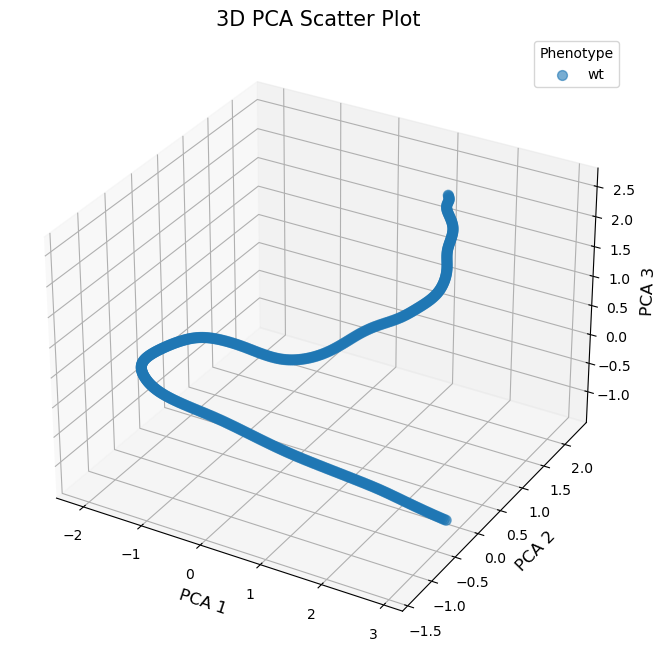

In [156]:
import matplotlib.pyplot as plt

# Initialize the figure and 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get unique phenotypes for coloring
phenotypes = pert_splines['phenotype'].unique()
colors = plt.cm.get_cmap('tab10', len(phenotypes))

# Plot each phenotype separately for distinct colors and labels
for idx, phenotype in enumerate(phenotypes):
    subset = pert_splines[pert_splines['phenotype'] == phenotype]
    ax.scatter(
        subset['PCA_1'],
        subset['PCA_2'],
        subset['PCA_3'],
        label=phenotype,
        color=colors(idx),
        s=50,       # Size of points
        alpha=0.6   # Transparency
    )

# Set labels and title
ax.set_xlabel('PCA 1', fontsize=12)
ax.set_ylabel('PCA 2', fontsize=12)
ax.set_zlabel('PCA 3', fontsize=12)
ax.set_title('3D PCA Scatter Plot', fontsize=15)

# Add legend
ax.legend(title='Phenotype')

# Show plot
plt.show()

In [44]:

wt_splines_n_planes = segment_info_df[segment_info_df["phenotype"] == "wt"]

wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]
wt_projection_to_wt = project_points_onto_reference_spline(
    wt_pert_df,
    wt_splines_n_planes
)


import os
import plotly.graph_objects as go
import plotly.express as px


3D visualization saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/3d_vis_spline_n_planes_wt_only_k=100.html


In [46]:

fig = plot_3d_spline_and_projections(
    projection_dfs =[wt_projection_to_wt],
    segment_info_df=segment_info_df[segment_info_df["phenotype"] == "wt"],
    pert_splines=pert_splines,  # or None if you don't have/need them
    save_dir=save_dir,
    filename="3d_vis_spline_n_planes_wt_only_k=100.html",
    k=None,
    title="My 3D Spline + Projection Visualizatio wt only 30degrees",
    plane_opacity=0.2,
    axis_length=0.5,
    show_legend=True
)


3D visualization saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/3d_vis_spline_n_planes_wt_only_k=100.html


Here is the task i need you to accomplish, channell your inner algorithms specialist and think about 3d space and limits and edgecases in coding. 

Before i introduce you to the data strcutures you will use as input i will describe what you are doing in broad terms.

The GOAL is to determine the largest number of segments ahat a spline can be broken inwo whilw still being stable (which means the maximum variation between segement pairs) dont vary too much.

---
In order to do this I will give you a dataframe called df_augmented that looks like this:

Unnamed: 0	snip_id	embryo_id	experiment_time	experiment_date	temperature	medium	short_pert_name	control_flag	phenotype	...	UMAP_00_bio_3	UMAP_01_bio_3	UMAP_02_bio_3	UMAP_00_n_3	UMAP_01_n_3	UMAP_02_n_3	PCA_1	PCA_2	PCA_3	segment_id
28553	28553	20231110_A08_e00_t0000	20231110_A08_e00	1919.332160	20231110	30	MC_015	wt_wik	0	wt	...	10.700978	8.723147	10.477208	10.679155	-4.802779	-4.433194	1.511702	2.285598	1.036647	5.0
28554	28554	20231110_A08_e00_t0001	20231110_A08_e00	4951.991120	20231110	30	MC_015	wt_wik	0	wt	...	10.319400	9.870806	10.282644	10.943745	-4.694721	-3.991637	1.202090	2.255699	1.025285	6.0
28555	

note you see that a it has a snip_id (a point unique barcode) embryo_id (where snip_id comes from) and then the PCA coordinates of this point. 

A spline of (500 points) was put through this data in PCA space, it is in pert_splines and has this structure:
pert_splines	PCA_1	PCA_2	PCA_3	phenotype
0	1.574707	1.543143	2.525967	wt
1	1.570822	1.555079	2.501355	wt
2	1.567201	1.566239	2.476312	wt
3	1.565783	1.577358	2.451000	wt
4	1.560429	1.586669	2.425514	wt
...	...	...	...	...
495	2.841722	-0.246652	-1.216590	wt
496	2.864059	-0.237275	-1.230013	wt
497	2.886542	-0.227957	-1.243232	wt
498	2.909195	-0.218713	-1.256210	wt
499	2.932052	-0.209564	-1.268895	wt

the points a put from beggining to end (0 beggining, 499 is the end)

---

now what you will do is define an algorithm that will start from some value k_init (50) note that (499 is the max alue because there are only 500 equally spaced points but check the length of pert_splines to determine maximum k) and then split the data along the spline in equal ways, not for us it would be (0,9) (9,19)... (489,499) for the first split ( but this should be calculated manually for the first split because k_init can change, e.g. l_init = 2)

then you will use a functions similar to these that will calculate how to split the spline in k segments here are some helper functions that you will have to intillegenelty modify to suit your needs:

not sure if you will need this one 
def compute_spline_distances(spline_pts):
    """Compute cumulative distances along the spline."""
    diffs = np.diff(spline_pts, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    cumdist = np.insert(np.cumsum(seg_lengths), 0, 0.0)
    return cumdist, cumdist[-1]

you can use this np_clip idea (to help order the point along the splines with sequential segments to get a global ordering of points)
def point_to_segment_distance(point, seg_start, seg_end):
    """
    Minimum distance from a 3D point to a line segment defined by seg_start, seg_end.
    """
    seg_vec = seg_end - seg_start
    pt_vec = point - seg_start
    seg_len_sq = np.dot(seg_vec, seg_vec)
    if seg_len_sq == 0.0:
        return np.linalg.norm(point - seg_start)
    t = np.dot(pt_vec, seg_vec) / seg_len_sq
    t = np.clip(t, 0.0, 1.0)
    projection = seg_start + t * seg_vec
    return np.linalg.norm(point - projection)

you can use this function to assign points to segments. 
def assign_points_to_segments(pert_df, segments):
    """
    Assign each point to the closest segment, create a 'segment_id' column in pert_df.
    """
    points = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values
    assigned_segments = []
    
    for p in points:
        min_dist = float('inf')
        seg_idx = -1
        for i, (s0, s1) in enumerate(segments):
            dist = point_to_segment_distance(p, s0, s1)
            if dist < min_dist:
                min_dist = dist
                seg_idx = i
        assigned_segments.append(seg_idx)
    
    pert_df["segment_id"] = assigned_segments
    return pert_df

this can be get tru error robust variation for the points assignemt to a specipic segment of the line
def perform_robust_pca(seg_points):
    """
    Perform robust PCA using Minimum Covariance Determinant (MCD).
    Returns the principal axis (first eigenvector) or None if not enough points.
    """
    if len(seg_points) < 2:
        return None
    try:
        mcd = MinCovDet().fit(seg_points)
        cov = mcd.covariance_
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        principal_axis = eig_vecs[:, np.argmax(eig_vals)]
        principal_axis /= np.linalg.norm(principal_axis)
        return principal_axis
    except:
        # Fallback to standard PCA if MCD fails
        pca = PCA(n_components=3)
        pca.fit(seg_points)
        principal_axis = pca.components_[0]
        principal_axis /= np.linalg.norm(principal_axis)
        return principal_axis
---

Here are the rough outlines of the algorithm.

you start with k_init then break it up into more and more components perhaps. you should use the the k_init value to get a global ordering of the points along the spline. 
this will be helpful as you break it up into smaller pieces. 

for a given value of k, you will assign point to a segment then. then measure the cosinge similarity of the first eigen vector from the robust PCA for SEQUENTIAL points ( to measure change over spline effectively), get the average of these cosin eimilarity value and savve them for plotting later as we want to see how they change over time. 

then increase the value of k lets say by 25. assign points to these segments. Note that you can save computational time by using the fact that if you know that a if you are choosing more equally spaced point the points and becasue we know there are (N=500) points and each index start_seg_i/500 and end_segment_i/500 it will have to be within the new seqgment index that CONTAIN the start_seg_i/500 and end_segment_i/500 (but if you are uncertain how to impement this you can simply just use the provided function to assign the points again)

then of course you will keep track of the average cosine values and asssignment. 

---
Note that as we are essentially going to the limi delta d-->0 there may not be enough points, if this is the case penalize the calculation by giving a cosine similarity of -1. Also note that we arent explicityl giving the orientation of the the axis of maximum variation, so just calc the abs( cosine_similarity), negative values will onbly be given if there arent enough points to get a reliale number of points or run PCA effectively,. 

---

dont forget to keep track of the k and the sement start and end points. 

also please make a plot at the end to calculate 

In [25]:
df_augmented

Unnamed: 0                 snip_id         embryo_id  experiment_time  \
28553       28553  20231110_A08_e00_t0000  20231110_A08_e00      1919.332160   
28554       28554  20231110_A08_e00_t0001  20231110_A08_e00      4951.991120   
28555       28555  20231110_A08_e00_t0003  20231110_A08_e00     10012.480400   
28556       28556  20231110_A08_e00_t0004  20231110_A08_e00     12550.292000   
28557       28557  20231110_A08_e00_t0005  20231110_A08_e00     15075.814400   
...           ...                     ...               ...              ...   
89859       89859  20241023_H06_e00_t0038  20241023_H06_e00     64127.787030   
89860       89860  20241023_H06_e00_t0039  20241023_H06_e00     65796.455422   
89861       89861  20241023_H06_e00_t0040  20241023_H06_e00     67465.614316   
89862       89862  20241023_H06_e00_t0041  20241023_H06_e00     69139.277532   
89863       89863  20241023_H06_e00_t0042  20241023_H06_e00     70809.139389   

      experiment_date  temperature  medium short_pert_name  control_flag  \
28553        20231110           30  MC_015          wt_wik             0   
28554        20231110           30  MC_015          wt_wik             0   
28555        20231110           30  MC_015          wt_wik             0   
28556        20231110           30  MC_015          wt_wik             0   
28557        20231110           30  MC_015          wt_wik             0   
...               ...          ...     ...             ...           ...   
89859        20241023           30      EM           wt_ab             0   
89860        20241023           30      EM           wt_ab             0   
89861        20241023           30      EM           wt_ab             0   
89862        20241023           30      EM           wt_ab             0   
89863        20241023           30      EM           wt_ab             0   

      phenotype  ...  UMAP_00_bio_3  UMAP_01_bio_3  UMAP_02_bio_3  \
28553        wt  ...      10.700978       8.723147      10.477208   
28554        wt  ...      10.319400       9.870806      10.282644   
28555        wt  ...       8.951474      10.274587       8.712678   
28556        wt  ...       8.928264      10.396387       9.037141   
28557        wt  ...       9.055897      10.474813       8.812095   
...         ...  ...            ...            ...            ...   
89859        wt  ...      -3.510522       2.098943       5.409442   
89860        wt  ...      -3.581279       1.981138       5.413172   
89861        wt  ...      -3.573022       2.037959       5.372482   
89862        wt  ...      -3.617301       1.922169       5.419991   
89863        wt  ...      -3.620532       1.969520       5.424538   

       UMAP_00_n_3 UMAP_01_n_3  UMAP_02_n_3     PCA_1     PCA_2     PCA_3  \
28553    10.679155   -4.802779    -4.433194  1.511702  2.285598  1.036647   
28554    10.943745   -4.694721    -3.991637  1.202090  2.255699  1.025285   
28555    11.248224   -4.139891    -3.759362  1.069783  2.334876  0.095826   
28556    11.379410   -4.602105    -3.708758  0.987037  2.415847  0.192335   
28557    11.234025   -3.839176    -3.316388  0.896327  2.364889  0.135872   
...            ...         ...          ...       ...       ...       ...   
89859     7.236939   -3.941631     4.800729  1.656356 -0.672436 -0.691350   
89860     7.237512   -3.960831     4.848146  1.734373 -0.616559 -0.762965   
89861     7.235272   -3.946346     4.822878  1.734032 -0.615701 -0.744531   
89862     7.232148   -3.952456     4.860742  1.805131 -0.565237 -0.801984   
89863     7.199991   -3.947567     4.906851  1.772709 -0.542734 -0.812728   

       segment_id  
28553         5.0  
28554         6.0  
28555         9.0  
28556         9.0  
28557         9.0  
...           ...  
89859        44.0  
89860        45.0  
89861        44.0  
89862        45.0  
89863        45.0  

[13163 rows x 235 columns]

In [26]:

from sklearn.covariance import MinCovDet
from sklearn.decomposition import PCA

def compute_spline_distances(spline_pts):
    """
    Optionally compute cumulative distances along the spline.
    Not strictly necessary if you are breaking the spline by index.
    """
    diffs = np.diff(spline_pts, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    cumdist = np.insert(np.cumsum(seg_lengths), 0, 0.0)
    return cumdist, cumdist[-1]


def point_to_segment_distance(point, seg_start, seg_end):
    """
    Minimum distance from a 3D point to a line segment defined by seg_start and seg_end.
    """
    seg_vec = seg_end - seg_start
    pt_vec = point - seg_start
    seg_len_sq = np.dot(seg_vec, seg_vec)
    if seg_len_sq == 0.0:
        # Degenerate case: segment start and end are the same
        return np.linalg.norm(point - seg_start)
    t = np.dot(pt_vec, seg_vec) / seg_len_sq
    t = np.clip(t, 0.0, 1.0)
    projection = seg_start + t * seg_vec
    return np.linalg.norm(point - projection)


def assign_points_to_segments(pert_df, segments):
    """
    Assign each point to the closest segment. 
    'segments' is a list of (start_3d, end_3d) pairs.
    """
    points = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values
    assigned_segments = []
    
    for p in points:
        min_dist = float('inf')
        seg_idx = -1
        for i, (s0, s1) in enumerate(segments):
            dist = point_to_segment_distance(p, s0, s1)
            if dist < min_dist:
                min_dist = dist
                seg_idx = i
        assigned_segments.append(seg_idx)
    
    pert_df["segment_id"] = assigned_segments
    return pert_df


def perform_robust_pca(seg_points):
    """
    Perform robust PCA using Minimum Covariance Determinant (MCD) 
    to get the principal axis (1st eigenvector).
    Fall back to standard PCA if MCD fails.
    
    Returns:
    - principal_axis (np.array of shape (3,)): normalized first principal axis
    - success (bool): indicates if the robust PCA had enough points and did not fail
    """
    if len(seg_points) < 2:
        # Not enough points to compute any PCA
        return None, False
    
    try:
        # Attempt MCD
        mcd = MinCovDet().fit(seg_points)
        cov = mcd.covariance_
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        idx_max = np.argmax(eig_vals)
        principal_axis = eig_vecs[:, idx_max]
        principal_axis /= np.linalg.norm(principal_axis)
        return principal_axis, True
    except:
        # Fallback to standard PCA
        try:
            pca = PCA(n_components=3)
            pca.fit(seg_points)
            principal_axis = pca.components_[0]
            principal_axis /= np.linalg.norm(principal_axis)
            return principal_axis, True
        except:
            return None, False


def compute_cosine_similarity(v1, v2):
    """Compute absolute cosine similarity between two 3D vectors."""
    dot = np.dot(v1, v2)
    norms = (np.linalg.norm(v1) * np.linalg.norm(v2))
    if norms == 0:
        return 0.0
    return abs(dot / norms)

In [33]:
def get_spline_segments(pert_splines_df, k):
    """
    Given a DataFrame of shape (N, 4) with columns ['PCA_1','PCA_2','PCA_3','phenotype'],
    return a list of 3D segment tuples. Each segment i is (start_3d, end_3d).
    The segments are chosen so that the entire spline from 0..N-1 is split 
    into k contiguous pieces by index.
    """
    # Convert spline to array
    spline_points = pert_splines_df[["PCA_1", "PCA_2", "PCA_3"]].values
    N = len(spline_points)
    # For integer splits, we can define approximate boundaries
    indices = np.round(np.linspace(0, N-1, k+1)).astype(int)  # k segments => k+1 boundaries
    
    segments = []
    for i in range(k):
        start_idx = indices[i]
        end_idx = indices[i+1]
        # Start 3D point and end 3D point
        start_pt = spline_points[start_idx]
        end_pt   = spline_points[end_idx]
        segments.append((start_pt, end_pt))
        
    return segments

In [34]:
def compute_segment_principal_axes(pert_df, k):
    """
    For each segment_id in [0..k-1], gather points assigned to that segment,
    run robust PCA, and store the principal axis.
    
    Returns:
    - principal_axes: list of length k, each entry is either a 3D vector or None
    - valid_flags: list of booleans indicating if that segment had a valid axis
    """
    principal_axes = []
    valid_flags = []
    
    for seg_id in range(k):
        seg_points = pert_df.loc[pert_df['segment_id'] == seg_id,
                                 ['PCA_1','PCA_2','PCA_3']].values
        axis, success = perform_robust_pca(seg_points)
        if not success or axis is None:
            # Not enough points or PCA failed
            principal_axes.append(None)
            valid_flags.append(False)
        else:
            principal_axes.append(axis)
            valid_flags.append(True)
    
    return principal_axes, valid_flags


def compute_average_consecutive_cosines(principal_axes):
    """
    Given a list of principal axes (3D vectors or None), 
    compute the mean absolute cosine similarity between 
    consecutive segments that have valid vectors.
    
    If a segment axis is None, treat it as invalid => penalty = -1 for that pair.
    """
    cosines = []
    for i in range(len(principal_axes) - 1):
        v1 = principal_axes[i]
        v2 = principal_axes[i+1]
        if v1 is None or v2 is None:
            # Penalty
            cosines.append(0)
        else:
            cosines.append(compute_cosine_similarity(v1, v2))
    
    # Return the average
    if len(cosines) == 0:
        return 0.0
    return np.mean(cosines)

In [41]:
def explore_spline_segmentations(df_augmented, pert_splines, k_values):
    """
    Given:
      - df_augmented: DataFrame of points with columns ['PCA_1','PCA_2','PCA_3']
      - pert_splines: DataFrame of the spline with columns ['PCA_1','PCA_2','PCA_3','phenotype'], length ~500
      - k_values: a list of integer segment counts to try
      
    Returns:
    - results_df: DataFrame with columns [k, average_cosine, segment_info]
    """
    records = []
    
    for k in k_values:
        print(k)
        # 1. Generate line segments from spline
        segments = get_spline_segments(pert_splines, k)
        
        # 2. Assign data points to these segments
        df_copy = df_augmented.copy()
        df_copy = assign_points_to_segments(df_copy, segments)
        
        # 3. Compute principal axes for each segment
        principal_axes, valid_flags = compute_segment_principal_axes(df_copy, k)
        
        # 4. Compute average consecutive cosines
        avg_cos = compute_average_consecutive_cosines(principal_axes)
        
        # Keep track of the segmentation indices or segment boundaries
        # (Here we store the actual start/end in terms of the spline indices or 3D coords.)
        segment_info = []
        for i, seg in enumerate(segments):
            start_pt, end_pt = seg
            segment_info.append({
                'segment_id': i,
                'start_pt': start_pt.tolist(),
                'end_pt': end_pt.tolist(),
                'valid': valid_flags[i]
            })
        
        records.append({
            'k': k,
            'average_cosine': avg_cos,
            'segment_info': segment_info
        })
    
    results_df = pd.DataFrame(records)
    return results_df


# Example usage:
# Suppose you want to try k in [50, 75, 100, 125, ... 499].
# Just be sure 499 is not out of range for your data length of 500 points.
k_values = list(range(25, 200, 25))

results_df = explore_spline_segmentations(df_augmented.sample(frac=1, random_state=42) , pert_splines, k_values)

25
50
75
100
125
150
175


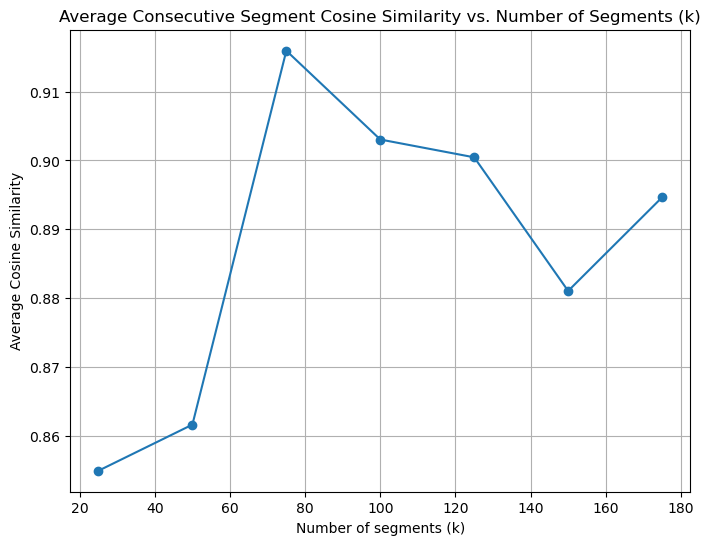

In [42]:


def plot_average_cosine_vs_k(results_df):
    """
    Given the results DataFrame from explore_spline_segmentations,
    plot average_cosine vs. k.
    """
    plt.figure(figsize=(8,6))
    plt.plot(results_df['k'], results_df['average_cosine'], marker='o')
    plt.title("Average Consecutive Segment Cosine Similarity vs. Number of Segments (k)")
    plt.xlabel("Number of segments (k)")
    plt.ylabel("Average Cosine Similarity")
    plt.grid(True)
    plt.show()


plot_average_cosine_vs_k(results_df)

Ok now i want to do something else, I want to be able to measure the average time that a given has. But I have to construct it by taking a random journey though the point cloud and its associated spline. 

This is a bootstraping type of method.
In short we will be taking steps through the space and keeping track of the delta_t between points and then seeing for a step in a journey what is its sum of delta t s for agiven segment (total time traveled) and the segment value. This way through multiple journeys we will be able to able to calculate the average time it takes to reach a segment (and therefore its time value). Note I also want eror bars for these time intervals. 

The broad step is to STEP_0 choose earlier time point (the segment should default to be 0 but itsshould be able to choose from and to end at) Then  STEP_1 move to the next snip_id (later time points) for an embryo id (if there is no next point choosen another point then do the next step). Record where you are (the snip_id and the segment it is associated with and the total time accumulated) . STEP_2 Pick a point that is within the segment but further ahead of it or the same amount along the spline (spline is sorted to beginning to end) (note if there isnt another point in the segment) then choose the closest point in the next segment. Then do STEP1. Do these steps until you reach the final segment default the last segment.  
Note that you need to order each point to order the points along the spline. 

additionally, we have for a given embryo_id multiple snip_ids that with a given time "experiment_time". We need to calculate delta_t between each snip_ids. 


Some important details you should pay attentio to is that "experiment_time" is not comparabible BETWEEN embryos, however delta_t are (same unit which is seconds). Thus inorder to get the ordering for time point of a given embryo, sort with epperimnet_time. 

Furtherore, when you land on a point and are moving to the next time point within a given embryo, move to the NEXT  sni_id (closest in time or index +1 after you order by experiment time)


---
In order to do this I will give you a dataframe called df_augmented that looks like this:

Unnamed: 0	snip_id	embryo_id	experiment_time	experiment_date	temperature	medium	short_pert_name	control_flag	phenotype	...	UMAP_00_bio_3	UMAP_01_bio_3	UMAP_02_bio_3	UMAP_00_n_3	UMAP_01_n_3	UMAP_02_n_3	PCA_1	PCA_2	PCA_3	segment_id
28553	28553	20231110_A08_e00_t0000	20231110_A08_e00	1919.332160	20231110	30	MC_015	wt_wik	0	wt	...	10.700978	8.723147	10.477208	10.679155	-4.802779	-4.433194	1.511702	2.285598	1.036647	5.0
28554	28554	20231110_A08_e00_t0001	20231110_A08_e00	4951.991120	20231110	30	MC_015	wt_wik	0	wt	...	10.319400	9.870806	10.282644	10.943745	-4.694721	-3.991637	1.202090	2.255699	1.025285	6.0
28555	

note you see that a it has a snip_id (a point unique barcode) embryo_id (where snip_id comes from) and then the PCA coordinates of this point. 

A spline of (500 points) was put through this data in PCA space, it is in pert_splines and has this structure:
pert_splines	PCA_1	PCA_2	PCA_3	phenotype
0	1.574707	1.543143	2.525967	wt
1	1.570822	1.555079	2.501355	wt
2	1.567201	1.566239	2.476312	wt
3	1.565783	1.577358	2.451000	wt
4	1.560429	1.586669	2.425514	wt
...	...	...	...	...
495	2.841722	-0.246652	-1.216590	wt
496	2.864059	-0.237275	-1.230013	wt
497	2.886542	-0.227957	-1.243232	wt
498	2.909195	-0.218713	-1.256210	wt
499	2.932052	-0.209564	-1.268895	wt

the points a put from beggining to end (0 beggining, 499 is the end)

---


Make sure you record the indiviadual journeys. 

In [98]:
import numpy as np
import pandas as pd
import random

# Optional: Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

def annotate_embryo_time_index(df_augmented):
    """
    Adds a 'within_embryo_t_idx' column to df_augmented,
    indicating the order of each snip_id within its embryo based on experiment_time.
    """
    df_augmented = df_augmented.copy()
    df_augmented["within_embryo_t_idx"] = (
        df_augmented.sort_values(by=["embryo_id", "experiment_time"])
                   .groupby("embryo_id")
                   .cumcount()
    )
    return df_augmented

def preprocess_embryo_data(df_augmented):
    """
    Returns a dictionary: { embryo_id: sorted_df }
    where sorted_df is df for that embryo sorted by experiment_time.
    """
    embryo_dict = {}
    grouped = df_augmented.groupby('embryo_id')
    for emb_id, emb_df in grouped:
        # Sort by experiment_time ascending
        emb_df_sorted = emb_df.sort_values(by='experiment_time').reset_index(drop=True)
        embryo_dict[emb_id] = emb_df_sorted
    return embryo_dict

def single_random_journey(
    embryo_dict,
    df_augmented,
    segments_sorted=None,
    start_segment=0,
    end_segment=None,
    max_hops=10_000,
    time_column = "experiment_time",
    segment_id_col= "ref_seg_id",
):
    """
    Generates a single random 'journey' from start_segment to end_segment 
    (inclusive). If end_segment is None, picks the max segment from segments_sorted.

    Parameters:
    - embryo_dict: {embryo_id: DataFrame sorted by experiment_time}
    - df_augmented: DataFrame with 'segment_id', 'embryo_id', 'snip_id', 'experiment_time', 'within_embryo_t_idx'
    - segments_sorted: list of unique segment IDs sorted in ascending order
    - start_segment: int, starting segment ID
    - end_segment: int, ending segment ID
    - max_hops: int, maximum steps to prevent infinite loops

    Returns:
    - journey: list of dicts with keys [segment_id_col, 'embryo_id', 'snip_id', 'cumulative_time']
    """
    if segments_sorted is None:
        segments_sorted = sorted(df_augmented[segment_id_col].unique())
    if end_segment is None:
        end_segment = max(segments_sorted)

    total_time = 0.0
    journey = []
    current_segment = start_segment

    # Select a random starting point in start_segment
    start_candidates = df_augmented[df_augmented[segment_id_col] == current_segment]
    if start_candidates.empty:
        # No points in start_segment; cannot start journey
        return journey

    row_start = start_candidates.sample(n=1).iloc[0]
    curr_emb_id = row_start["embryo_id"]
    curr_snip_id = row_start["snip_id"]
    # Record first step with cumulative_time = 0
    journey.append({
        "segment_id": current_segment,
        "embryo_id": curr_emb_id,
        "snip_id": curr_snip_id,
        "cumulative_time": total_time
    })

    # Access the sorted embryo DataFrame
    emb_df = embryo_dict[curr_emb_id]
    # Find the index of the starting snip_id
    try:
        row_index = emb_df.index[emb_df["snip_id"] == curr_snip_id][0]
    except IndexError:
        # snip_id not found in embryo_dict; abort journey
        return journey

    hop_count = 0

    while current_segment < end_segment and hop_count < max_hops:
        hop_count += 1
        next_index = row_index + 1
        possible_move = False

        if next_index < len(emb_df):
            # There's a next time point in the same embryo
            row_next = emb_df.iloc[next_index]
            next_seg = row_next[segment_id_col]
            delta_t = row_next[time_column] - emb_df.iloc[row_index][time_column]

            if next_seg == current_segment:
                # Remain in the same segment
                total_time += delta_t
                journey.append({
                    "segment_id": current_segment,
                    "embryo_id": curr_emb_id,
                    "snip_id": row_next["snip_id"],
                    "cumulative_time": total_time
                })
                row_index = next_index
                possible_move = True
            elif next_seg > current_segment:
                # Move to a higher segment
                total_time += delta_t
                current_segment = next_seg
                journey.append({
                    "segment_id": current_segment,
                    "embryo_id": curr_emb_id,
                    "snip_id": row_next["snip_id"],
                    "cumulative_time": total_time
                })
                row_index = next_index
                possible_move = True
            else:
                # next_seg < current_segment; treat as no move
                pass

        if not possible_move:
            # Move to embryo in the current segment by jumping to a random embryo's point in that segment
            possible_segments = [seg for seg in segments_sorted if seg >= current_segment]
            if not possible_segments:
                # Reached the final segment; end journey
                break
            next_segment = min(possible_segments)  # Immediate next segment

            # Select a random point in next_segment
            next_seg_candidates = df_augmented[df_augmented[segment_id_col] == next_segment]
            if next_seg_candidates.empty:
                # No points in next_segment; cannot proceed
                break

            row_new = next_seg_candidates.sample(n=1).iloc[0]
            new_emb_id = row_new["embryo_id"]
            new_snip_id = row_new["snip_id"]

            # Update current position
            current_segment = next_segment
            curr_emb_id = new_emb_id
            curr_snip_id = new_snip_id
            emb_df = embryo_dict[curr_emb_id]

            try:
                row_index = emb_df.index[emb_df["snip_id"] == new_snip_id][0]
            except IndexError:
                # snip_id not found; skip to next journey
                break

            # No time accumulated when jumping to a different embryo
            journey.append({
                "segment_id": current_segment,
                "embryo_id": curr_emb_id,
                "snip_id": curr_snip_id,
                "cumulative_time": total_time
            })

    return journey

def run_bootstrap_journeys(
    df_augmented,
    num_journeys=1000,
    start_segment=0,
    end_segment=None,
    random_seed=42,
    time_column = "experiment_time",
    segment_id_col = "segment_id"
):
    """
    Repeatedly runs single_random_journey and collects results in a DataFrame.

    Parameters:
    - df_augmented: DataFrame with necessary columns
    - num_journeys: int, number of bootstrap journeys to run
    - start_segment: int, starting segment ID
    - end_segment: int, ending segment ID (if None, uses max segment)
    - random_seed: int, for reproducibility

    Returns:
    - journeys_df: DataFrame with all journey steps
    """
    # Set random seeds
    np.random.seed(random_seed)
    random.seed(random_seed)

    # 1. Annotate the 'within_embryo_t_idx'
    df_aug = annotate_embryo_time_index(df_augmented)

    # Make sure there is an embryo in the star segment 

    start_segment_init = start_segment
    while True:
        start_candidates = df_aug[df_aug[segment_id_col] == start_segment]
    
        if not start_candidates.empty:
            # Valid start segment found
            print(f"No start candidates in segment {start_segment_init}."
                f"The next closest start candidate is in segment {start_segment}.")
            break  # Exit the loop when a valid start segment is found
        
            # Increment start_segment and continue the search
        start_segment += 1

    # 2. Build embryo_dict
    embryo_dict = preprocess_embryo_data(df_aug)

    # 3. Determine segments_sorted
    segments_sorted = sorted(df_aug[segment_id_col].unique())
    if end_segment is None:
        end_segment = max(segments_sorted)

    all_records = []

    for j_id in range(num_journeys):
        journey_steps = single_random_journey(
            embryo_dict=embryo_dict,
            df_augmented=df_aug,
            segments_sorted=segments_sorted,
            start_segment=start_segment,
            end_segment=end_segment,
            time_column = time_column,
        )

        for step_i, step_info in enumerate(journey_steps):
            record = {
                "journey_id": j_id,
                "step_index": step_i,
                "segment_id": step_info["segment_id"],
                "embryo_id": step_info["embryo_id"],
                "snip_id": step_info["snip_id"],
                "cumulative_time": step_info["cumulative_time"]
            }
            all_records.append(record)

    journeys_df = pd.DataFrame(all_records)
    return journeys_df

def summarize_journeys(journeys_df):
    """
    For each segment_id, compute mean and std of cumulative_time across all journeys.

    Parameters:
    - journeys_df: DataFrame with journey steps

    Returns:
    - summary_df: DataFrame with ['segment_id', 'mean_time', 'std_time', 'count']
    """
    grp = journeys_df.groupby("segment_id")["cumulative_time"]
    summary = grp.agg(['mean','std','count']).reset_index()
    summary.columns = ["segment_id", "mean_time", "std_time", "count"]
    return summary

def plot_summary(summary_df, title="Average Time to Reach Each Segment"):
    """
    Plots the average cumulative time to reach each segment with error bars.

    Parameters:
    - summary_df: DataFrame with ['segment_id', 'mean_time', 'std_time', 'count']
    - title: str, plot title
    """
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        summary_df["segment_id"],
        summary_df["mean_time"]/(60*60),
        yerr=summary_df["std_time"],
        fmt='-o',
        ecolor='r',
        capsize=5,
        markersize=4,
        label='Mean Time with Std Dev'
    )
    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Average Cumulative Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------- Usage Example --------------------------

# Assuming you have `df_augmented` and `pert_splines` DataFrames loaded
# Example:
# df_augmented = pd.read_csv("path_to_df_augmented.csv")
# pert_splines = pd.read_csv("path_to_pert_splines.csv")

# For demonstration, let's create mock data

import numpy as np
import matplotlib.pyplot as plt


def plot_summary(summary_df, df_augmented, title="Average Time to Reach Each Segment"):
    """
    Plots the average cumulative time to reach each segment (in hours) with error bars,
    and compares it to the predicted_stage_hpf (with standard error) from df_augmented.

    Parameters:
    ----------
    summary_df : pd.DataFrame
        Must have columns: ['segment_id', 'mean_time', 'std_time', 'count']
        where 'mean_time' and 'std_time' are in seconds, aggregated over bootstrap journeys.
    df_augmented : pd.DataFrame
        Must have columns: ['segment_id', 'predicted_stage_hpf'].
    title : str
        Plot title.
    """
    # 1. Convert bootstrap time (seconds) to hours
    starting_seg =int(min(summary_df["segment_id"]))
    time_init = df_augmented[df_augmented["segment_id"] == starting_seg]["predicted_stage_hpf"].mean()
    
    summary_df["mean_time_hours"] = summary_df["mean_time"] / 3600.0 + time_init
    summary_df["std_time_hours"] = summary_df["std_time"] / 3600.0

    # 2. Compute mean predicted_stage_hpf and standard error by segment
    pred_stats = (
        df_augmented.groupby("segment_id")["predicted_stage_hpf"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    pred_stats.columns = ["segment_id", "mean_pred_hpf", "std_pred_hpf", "count_pred"]
    pred_stats["se_pred_hpf"] = pred_stats["std_pred_hpf"] / np.sqrt(pred_stats["count_pred"])

    # 3. Merge the predicted stats with the summary of bootstrap times
    plot_df = pd.merge(summary_df, pred_stats, on="segment_id", how="left")

    # 4. Plot the bootstrap times (hours) with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        plot_df["segment_id"],
        plot_df["mean_time_hours"],
        yerr=plot_df["std_time_hours"],
        fmt='-o',
        ecolor='red',
        capsize=5,
        markersize=4,
        label='Bootstrap Mean Time ± Std (hours)'
    )

    # 5. Plot predicted stage hpf (also in hours) with standard error
    plt.errorbar(
        plot_df["segment_id"],
        plot_df["mean_pred_hpf"],
        yerr=plot_df["se_pred_hpf"],
        fmt='-s',
        color='darkorange',
        capsize=5,
        markersize=4,
        label='Predicted Stage hpf ± SE'
    )

    # 6. Final formatting
    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    
# plot_summary(summary_df, df_augmented, title="Average Time to Reach Each Segment")

In [162]:

# Run bootstrap journeys
num_journeys =  100 # Adjust based on computational resources
journeys_df = run_bootstrap_journeys(
    df_augmented=df_augmented,
    num_journeys=num_journeys,
    start_segment=0,
    end_segment=None,  # Defaults to max segment
    random_seed=42,
    time_column = "experiment_time"
)

# Summarize the journeys
summary_df = summarize_journeys(journeys_df)

print("Summary of Average Times per Segment:")
print(summary_df)
plot_summary(summary_df, df_augmented, title="Average Time to Reach Each Segment")

Summary of Average Times per Segment:
    segment_id      mean_time      std_time  count
0          0.0     425.164926   1041.073682    118
1          1.0    1934.689424    603.711202     28
2          2.0    3381.901285   1964.526944    114
3          3.0    4297.775267   2117.779827     54
4          4.0    5183.921831   2019.241265     46
..         ...            ...           ...    ...
95        95.0  132563.461417  12933.854066    378
96        96.0  144574.274618  13847.342794    306
97        97.0  145115.018476  14924.551928    344
98        98.0  150355.814091  15881.638837    200
99        99.0  153856.197629  16760.116600    100

[100 rows x 4 columns]


TypeError: plot_summary() got multiple values for argument 'title'

In [177]:
pert_splines

PCA_1     PCA_2     PCA_3 phenotype
0    1.574707  1.543143  2.525967        wt
1    1.570822  1.555079  2.501355        wt
2    1.567201  1.566239  2.476312        wt
3    1.565783  1.577358  2.451000        wt
4    1.560429  1.586669  2.425514        wt
..        ...       ...       ...       ...
495  2.841722 -0.246652 -1.216590        wt
496  2.864059 -0.237275 -1.230013        wt
497  2.886542 -0.227957 -1.243232        wt
498  2.909195 -0.218713 -1.256210        wt
499  2.932052 -0.209564 -1.268895        wt

[500 rows x 4 columns]

In [168]:

# Run bootstrap journeys
num_journeys =  100 # Adjust based on computational resources
journeys_df = run_bootstrap_journeys(
    df_augmented=df_augmented,
    num_journeys=num_journeys,
    start_segment=0,
    end_segment=None,  # Defaults to max segment
    random_seed=42,
    time_column = "predicted_stage_hpf"
)

# Summarize the journeys
summary_df = summarize_journeys(journeys_df)

# print("Summary of Average Times per Segment:")
# print(summary_df)
# plot_summary(summary_df, df_augmented, title="Average Time to Reach Each Segment")

In [129]:
summary_df["mean_time_hours"] = (summary_df["mean_time_hours"] - 13.483655) * 3600 

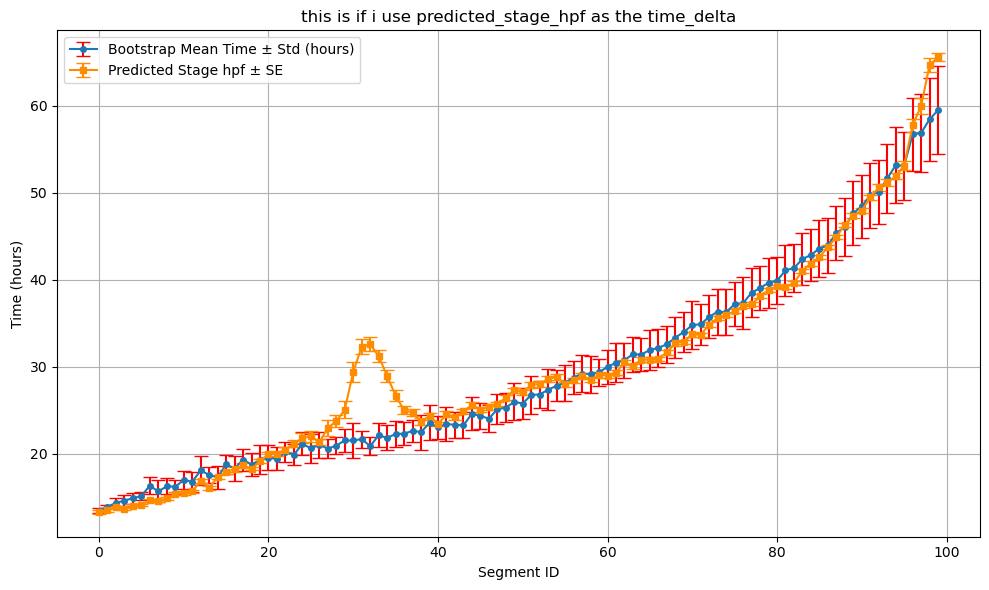

In [176]:


summary_df["mean_time_hours"] = (summary_df["mean_time"] - 13.483655) * 3600 + 13.483655

# 1. Convert bootstrap time (seconds) to hours
time_init = df_augmented[df_augmented["segment_id"] == 0]["predicted_stage_hpf"].mean()
summary_df["mean_time_hours"] = summary_df["mean_time"]  + time_init
summary_df["std_time_hours"] = summary_df["std_time"]

# 2. Compute mean predicted_stage_hpf and standard error by segment
pred_stats = (
    df_augmented.groupby("segment_id")["predicted_stage_hpf"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
pred_stats.columns = ["segment_id", "mean_pred_hpf", "std_pred_hpf", "count_pred"]
pred_stats["se_pred_hpf"] = pred_stats["std_pred_hpf"] / np.sqrt(pred_stats["count_pred"])

# 3. Merge the predicted stats with the summary of bootstrap times
plot_df = pd.merge(summary_df, pred_stats, on="segment_id", how="left")

# 4. Plot the bootstrap times (hours) with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(
    plot_df["segment_id"],
    plot_df["mean_time_hours"],
    yerr=plot_df["std_time_hours"],
    fmt='-o',
    ecolor='red',
    capsize=5,
    markersize=4,
    label='Bootstrap Mean Time ± Std (hours)'
)

# 5. Plot predicted stage hpf (also in hours) with standard error
plt.errorbar(
    plot_df["segment_id"],
    plot_df["mean_pred_hpf"],
    yerr=plot_df["se_pred_hpf"],
    fmt='-s',
    color='darkorange',
    capsize=5,
    markersize=4,
    label='Predicted Stage hpf ± SE'
)

# 6. Final formatting
plt.title("this is if i use predicted_stage_hpf as the time_delta")
plt.xlabel("Segment ID")
plt.ylabel("Time (hours)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Calculate the deltat_ts within an embryo_df and then color by "predicted_stage_hpf" x axis will be delta_predicted_stage_hpf, y axsist is delta_experiment_time (convert this to hours)

/tmp/9164297.1.trapnell-login.q/ipykernel_470004/4076089708.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/9164297.1.trapnell-login.q/ipykernel_470004/4076089708.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/9164297.1.trapnell-login.q/ipykernel_470004/4076089708.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

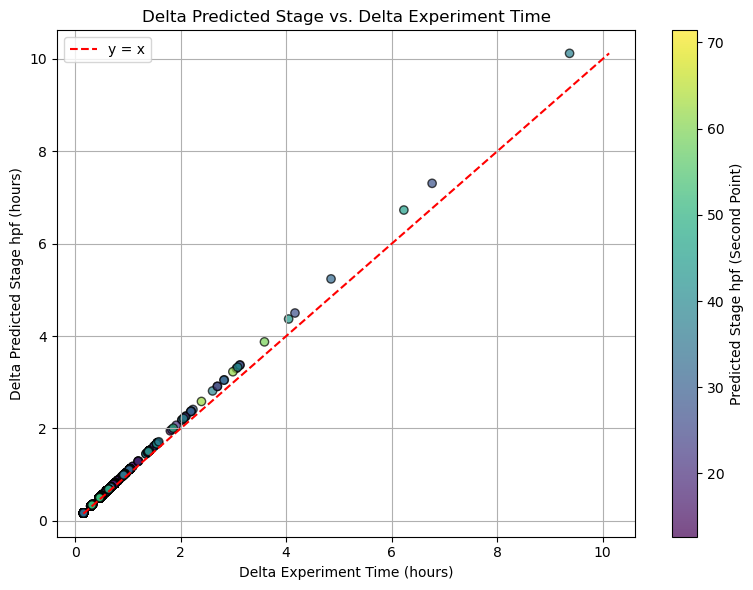

In [152]:


def plot_delta_predicted_vs_experiment(df_augmented):
    """
    Calculate deltas (Delta Predicted Stage hpf vs. Delta Experiment Time) within each embryo
    and plot a scatter diagram colored by the second point's predicted_stage_hpf.

    Parameters
    ----------
    df_augmented : pd.DataFrame
        Must have columns: 
            - embryo_id (str or int): identifies the embryo
            - experiment_time (float): time in seconds
            - predicted_stage_hpf (float): predicted stage in hours post-fertilization
        Rows for multiple embryo_ids are allowed.
    """

    # 1. Group by embryo_id and sort each group by experiment_time
    grouped = df_augmented.groupby("embryo_id", group_keys=True)

    delta_records = []

    for embryo_id, group in grouped:
        # Sort by experiment_time ascending
        group = group.sort_values(by="experiment_time").reset_index(drop=True)
        # Compute deltas
        group["delta_predicted_stage_hpf"] = group["predicted_stage_hpf"].diff()
        group["delta_experiment_time_hours"] = group["experiment_time"].diff() / 3600.0
        
        # The color will be the "second" point's predicted_stage_hpf in the pair
        # i.e., shift predicted_stage_hpf up by -1 so that delta row has the next row's value
        group["color_pred_hpf"] = group["predicted_stage_hpf"].shift(-1)
        
        # Drop NaNs (first row has no delta)
        deltas = group.dropna(
            subset=["delta_predicted_stage_hpf", "delta_experiment_time_hours", "color_pred_hpf"]
        )
        # Add embryo_id info if desired
        deltas["embryo_id"] = embryo_id
        
        delta_records.append(deltas[[
            "embryo_id",
            "delta_predicted_stage_hpf",
            "delta_experiment_time_hours",
            "color_pred_hpf"
        ]])

    # 2. Concatenate all delta records
    if len(delta_records) == 0:
        print("No valid delta rows found.")
        return

    df_deltas = pd.concat(delta_records, ignore_index=True)

    # 3. Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        y=df_deltas["delta_predicted_stage_hpf"],
        x=df_deltas["delta_experiment_time_hours"],
        c=df_deltas["color_pred_hpf"], 
        cmap='viridis',
        alpha=0.7,
        edgecolor='k'
    )
    plt.colorbar(scatter, label='Predicted Stage hpf (Second Point)')

    plt.ylabel("Delta Predicted Stage hpf (hours)")
    plt.xlabel("Delta Experiment Time (hours)")
    plt.title("Delta Predicted Stage vs. Delta Experiment Time")

    # 4. Add y = x reference line
    min_val = min(df_deltas["delta_predicted_stage_hpf"].min(),
                  df_deltas["delta_experiment_time_hours"].min())
    max_val = max(df_deltas["delta_predicted_stage_hpf"].max(),
                  df_deltas["delta_experiment_time_hours"].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage Example (assuming df_augmented is already loaded with the required columns):
plot_delta_predicted_vs_experiment(df_augmented)

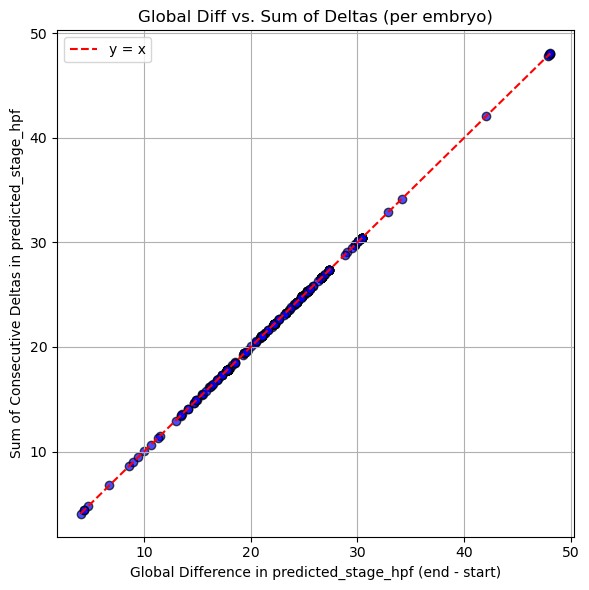

In [153]:

import numpy as np


def plot_sum_of_deltas_vs_global_diff(df_augmented):
    """
    For each embryo_id in df_augmented, compare:
      - Global difference in predicted_stage_hpf (end - start)
      - Sum of consecutive deltas in predicted_stage_hpf.
    Scatter plot these two values (x=global diff, y=sum of deltas),
    and draw an x=y line to show if they match.

    Parameters
    ----------
    df_augmented : pd.DataFrame
        Must have columns:
            - embryo_id: identifies embryo
            - experiment_time (seconds): used to sort time points in ascending order
            - predicted_stage_hpf (hours): predicted stage in hours
    """

    # Group by embryo_id
    grouped = df_augmented.groupby("embryo_id", group_keys=True)
    
    records = []
    for emb_id, group in grouped:
        # Sort by experiment_time ascending
        group = group.sort_values(by="experiment_time").reset_index(drop=True)
        
        if len(group) < 2:
            # Not enough points to compute deltas
            continue
        
        # Global difference = last predicted_stage_hpf - first predicted_stage_hpf
        global_diff = group["predicted_stage_hpf"].iloc[-1] - group["predicted_stage_hpf"].iloc[0]
        
        # Sum of consecutive deltas
        # consecutive_deltas = sum( predicted_stage_hpf[i+1] - predicted_stage_hpf[i] )
        group["delta_predicted_stage"] = group["predicted_stage_hpf"].diff()
        sum_of_deltas = group["delta_predicted_stage"].iloc[1:].sum()  # skip NaN in first row
        
        records.append({
            "embryo_id": emb_id,
            "global_diff": global_diff,
            "sum_of_deltas": sum_of_deltas
        })
    
    if not records:
        print("No embryos with at least two time points. Nothing to plot.")
        return
    
    results_df = pd.DataFrame(records)
    
    # Scatter plot: X = global_diff, Y = sum_of_deltas
    plt.figure(figsize=(6, 6))
    plt.scatter(results_df["global_diff"], results_df["sum_of_deltas"], 
                c='blue', alpha=0.7, edgecolors='k')
    
    # Optional: color by embryo_id if you prefer
    # e.g. using a categorical colormap

    # Draw x=y line
    min_val = min(results_df["global_diff"].min(), results_df["sum_of_deltas"].min())
    max_val = max(results_df["global_diff"].max(), results_df["sum_of_deltas"].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
    
    plt.xlabel("Global Difference in predicted_stage_hpf (end - start)")
    plt.ylabel("Sum of Consecutive Deltas in predicted_stage_hpf")
    plt.title("Global Diff vs. Sum of Deltas (per embryo)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_sum_of_deltas_vs_global_diff(df_augmented)

In [178]:
summary_df

segment_id  mean_time  std_time  count  mean_time_hours  std_time_hours
0          0.0   0.127549  0.312322    118        13.456918        0.312322
1          1.0   0.580407  0.181113     28        13.909775        0.181113
2          2.0   1.014570  0.589358    114        14.343939        0.589358
3          3.0   1.289333  0.635334     54        14.618701        0.635334
4          4.0   1.555177  0.605772     46        14.884545        0.605772
..         ...        ...       ...    ...              ...             ...
95        95.0  39.769038  3.880156    378        53.098407        3.880156
96        96.0  43.372282  4.154203    306        56.701651        4.154203
97        97.0  43.534506  4.477366    344        56.863874        4.477366
98        98.0  45.106744  4.764492    200        58.436112        4.764492
99        99.0  46.156859  5.028035    100        59.486227        5.028035

[100 rows x 6 columns]

In [179]:
df_augmented 

Unnamed: 0                 snip_id         embryo_id  experiment_time  \
28553       28553  20231110_A08_e00_t0000  20231110_A08_e00      1919.332160   
28554       28554  20231110_A08_e00_t0001  20231110_A08_e00      4951.991120   
28555       28555  20231110_A08_e00_t0003  20231110_A08_e00     10012.480400   
28556       28556  20231110_A08_e00_t0004  20231110_A08_e00     12550.292000   
28557       28557  20231110_A08_e00_t0005  20231110_A08_e00     15075.814400   
...           ...                     ...               ...              ...   
89859       89859  20241023_H06_e00_t0038  20241023_H06_e00     64127.787030   
89860       89860  20241023_H06_e00_t0039  20241023_H06_e00     65796.455422   
89861       89861  20241023_H06_e00_t0040  20241023_H06_e00     67465.614316   
89862       89862  20241023_H06_e00_t0041  20241023_H06_e00     69139.277532   
89863       89863  20241023_H06_e00_t0042  20241023_H06_e00     70809.139389   

      experiment_date  temperature  medium short_pert_name  control_flag  \
28553        20231110           30  MC_015          wt_wik             0   
28554        20231110           30  MC_015          wt_wik             0   
28555        20231110           30  MC_015          wt_wik             0   
28556        20231110           30  MC_015          wt_wik             0   
28557        20231110           30  MC_015          wt_wik             0   
...               ...          ...     ...             ...           ...   
89859        20241023           30      EM           wt_ab             0   
89860        20241023           30      EM           wt_ab             0   
89861        20241023           30      EM           wt_ab             0   
89862        20241023           30      EM           wt_ab             0   
89863        20241023           30      EM           wt_ab             0   

      phenotype  ...  UMAP_00_bio_3  UMAP_01_bio_3  UMAP_02_bio_3  \
28553        wt  ...      10.700978       8.723147      10.477208   
28554        wt  ...      10.319400       9.870806      10.282644   
28555        wt  ...       8.951474      10.274587       8.712678   
28556        wt  ...       8.928264      10.396387       9.037141   
28557        wt  ...       9.055897      10.474813       8.812095   
...         ...  ...            ...            ...            ...   
89859        wt  ...      -3.510522       2.098943       5.409442   
89860        wt  ...      -3.581279       1.981138       5.413172   
89861        wt  ...      -3.573022       2.037959       5.372482   
89862        wt  ...      -3.617301       1.922169       5.419991   
89863        wt  ...      -3.620532       1.969520       5.424538   

       UMAP_00_n_3 UMAP_01_n_3  UMAP_02_n_3     PCA_1     PCA_2     PCA_3  \
28553    10.679155   -4.802779    -4.433194  1.511702  2.285598  1.036647   
28554    10.943745   -4.694721    -3.991637  1.202090  2.255699  1.025285   
28555    11.248224   -4.139891    -3.759362  1.069783  2.334876  0.095826   
28556    11.379410   -4.602105    -3.708758  0.987037  2.415847  0.192335   
28557    11.234025   -3.839176    -3.316388  0.896327  2.364889  0.135872   
...            ...         ...          ...       ...       ...       ...   
89859     7.236939   -3.941631     4.800729  1.656356 -0.672436 -0.691350   
89860     7.237512   -3.960831     4.848146  1.734373 -0.616559 -0.762965   
89861     7.235272   -3.946346     4.822878  1.734032 -0.615701 -0.744531   
89862     7.232148   -3.952456     4.860742  1.805131 -0.565237 -0.801984   
89863     7.199991   -3.947567     4.906851  1.772709 -0.542734 -0.812728   

       segment_id  
28553        11.0  
28554        12.0  
28555        18.0  
28556        18.0  
28557        18.0  
...           ...  
89859        89.0  
89860        90.0  
89861        89.0  
89862        90.0  
89863        90.0  

[13163 rows x 235 columns]

# Invesigate lmx1b Developmental shft 


In [3]:
# Specify the minimum number of snip_ids per embryo_id
pert_comparisons = ["wt","lmx1b", "inj-ctrl"]

min_snips = 20

# Filter the DataFrame to only include embryo_id with at least `min_snips` snip_ids
df    = df_orig.groupby('embryo_id').filter(lambda x: len(x) >= min_snips)
df_30 = df[df["temperature"]==30.0]
df_22 = df[df["temperature"]==22.0]


df_30   = apply_pca_on_pert_comparisons(df_30  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
# df_22   = apply_pca_on_pert_comparisons(df_22  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
# df      = apply_pca_on_pert_comparisons(df_orig,z_mu_biological_columns,pert_comparisons=pert_comparisons )

Using specified perturbations for PCA: ['wt', 'lmx1b', 'inj-ctrl']

PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 85.35%

Principal Component Explained Variance Ratio
              PCA_1                   41.39%
              PCA_2                   33.56%
              PCA_3                   10.41%
----------------------------



/tmp/9264373.1.trapnell-login.q/ipykernel_2545814/620442685.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pcs[:, i]


In [4]:
pert_splines, df_augmented, segment_info_df = build_splines_and_segments(
    df=df_30,
    comparisons=pert_comparisons,
    save_dir=save_dir,
    model_index=model_index,
    LocalPrincipalCurveClass=LocalPrincipalCurve,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=100
)

Using specified comparisons for spline building: ['wt', 'lmx1b', 'inj-ctrl']
Building spline data for each phenotype...


Creating splines for each phenotype:   0%|                                                                                                                                  | 0/3 [00:00<?, ?it/s]

Starting point not in dataset. Using closest point: [ 1.48969681  1.78109378 -0.85248292]


Creating splines for each phenotype:  33%|████████████████████████████████████████▋                                                                                 | 1/3 [00:05<00:11,  5.79s/it]

Starting point not in dataset. Using closest point: [ 1.58724164  1.9738906  -0.48371219]


Creating splines for each phenotype:  67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 2/3 [00:11<00:05,  5.97s/it]

Starting point not in dataset. Using closest point: [ 1.41584415  1.84864023 -1.20365681]


Creating splines for each phenotype: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.44s/it]


Spline DataFrame 'pert_splines' saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/pert_splines_74_unique.csv
Assigning segments and building segment_info_df...


Processing phenotypes:  33%|█████████████████████████████████████████████▎                                                                                          | 1/3 [01:00<02:01, 60.53s/it]/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
Processing phenotypes:  67%|██████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2/3 [01:37<00:46, 46.95s/it]/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/covariance/_robus

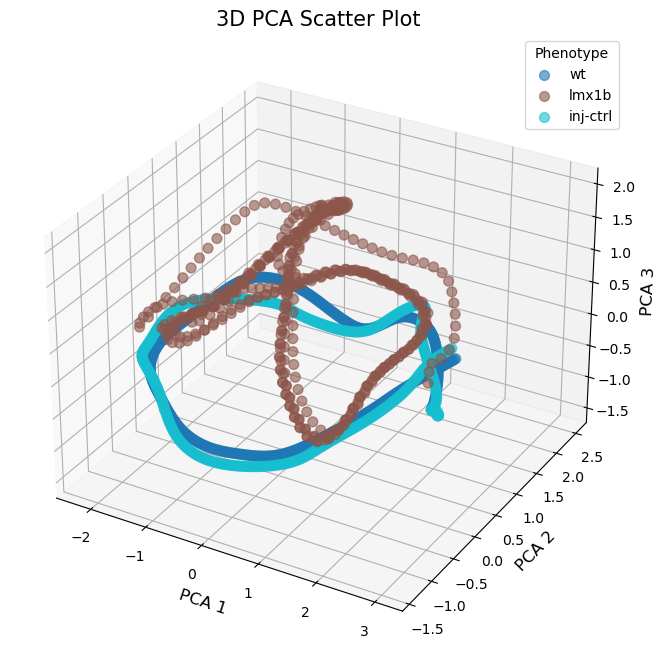

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the figure and 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get unique phenotypes for coloring
phenotypes = pert_splines['phenotype'].unique()
colors = plt.cm.get_cmap('tab10', len(phenotypes))

# Plot each phenotype separately for distinct colors and labels
for idx, phenotype in enumerate(phenotypes):
    subset = pert_splines[pert_splines['phenotype'] == phenotype]
    ax.scatter(
        subset['PCA_1'],
        subset['PCA_2'],
        subset['PCA_3'],
        label=phenotype,
        color=colors(idx),
        s=50,       # Size of points
        alpha=0.6   # Transparency
    )

# Set labels and title
ax.set_xlabel('PCA 1', fontsize=12)
ax.set_ylabel('PCA 2', fontsize=12)
ax.set_zlabel('PCA 3', fontsize=12)
ax.set_title('3D PCA Scatter Plot', fontsize=15)

# Add legend
ax.legend(title='Phenotype')

# Show plot
plt.show()

In [183]:
# Suppose we have:
# df_augmented       -> your main augmented DataFrame with "wt" and "lmx1b" (and others)
# segment_info_df    -> from create_spline_segments_for_df
# We pick "wt" splines for reference:
wt_splines_n_planes = segment_info_df[segment_info_df["phenotype"] == "wt"]



# A) Points from "wt" itself
wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]
wt_projection_to_wt = project_points_onto_reference_spline(
    wt_pert_df,
    wt_splines_n_planes
)

# B) Points from "lmx1b"
lmx1b_pert_df = df_augmented[df_augmented["phenotype"] == "lmx1b"]
lmx1b_projection_to_wt = project_points_onto_reference_spline(
    lmx1b_pert_df,
    wt_splines_n_planes
)


inj_ctrl_df = df_augmented[df_augmented["phenotype"]=="inj-ctrl"]
inj_ctrl_projection_to_wt = project_points_onto_reference_spline(
    inj_ctrl_df,
    wt_splines_n_planes
)

In [190]:
# Select necessary columns

# Merge
df_merged = df_augmented.merge(
    wt_projection_to_wt[["snip_id", "ref_seg_id"]],
    on="snip_id",
    how="left"
)

df_merged

Unnamed: 0                 snip_id         embryo_id  experiment_time  \
0           28553  20231110_A08_e00_t0000  20231110_A08_e00      1919.332160   
1           28554  20231110_A08_e00_t0001  20231110_A08_e00      4951.991120   
2           28555  20231110_A08_e00_t0003  20231110_A08_e00     10012.480400   
3           28556  20231110_A08_e00_t0004  20231110_A08_e00     12550.292000   
4           28557  20231110_A08_e00_t0005  20231110_A08_e00     15075.814400   
...           ...                     ...               ...              ...   
21879       89859  20241023_H06_e00_t0038  20241023_H06_e00     64127.787030   
21880       89860  20241023_H06_e00_t0039  20241023_H06_e00     65796.455422   
21881       89861  20241023_H06_e00_t0040  20241023_H06_e00     67465.614316   
21882       89862  20241023_H06_e00_t0041  20241023_H06_e00     69139.277532   
21883       89863  20241023_H06_e00_t0042  20241023_H06_e00     70809.139389   

      experiment_date  temperature  medium short_pert_name  control_flag  \
0            20231110           30  MC_015          wt_wik             0   
1            20231110           30  MC_015          wt_wik             0   
2            20231110           30  MC_015          wt_wik             0   
3            20231110           30  MC_015          wt_wik             0   
4            20231110           30  MC_015          wt_wik             0   
...               ...          ...     ...             ...           ...   
21879        20241023           30      EM           wt_ab             0   
21880        20241023           30      EM           wt_ab             0   
21881        20241023           30      EM           wt_ab             0   
21882        20241023           30      EM           wt_ab             0   
21883        20241023           30      EM           wt_ab             0   

      phenotype  ...  UMAP_01_bio_3  UMAP_02_bio_3  UMAP_00_n_3  UMAP_01_n_3  \
0            wt  ...       8.723147      10.477208    10.679155    -4.802779   
1            wt  ...       9.870806      10.282644    10.943745    -4.694721   
2            wt  ...      10.274587       8.712678    11.248224    -4.139891   
3            wt  ...      10.396387       9.037141    11.379410    -4.602105   
4            wt  ...      10.474813       8.812095    11.234025    -3.839176   
...         ...  ...            ...            ...          ...          ...   
21879        wt  ...       2.098943       5.409442     7.236939    -3.941631   
21880        wt  ...       1.981138       5.413172     7.237512    -3.960831   
21881        wt  ...       2.037959       5.372482     7.235272    -3.946346   
21882        wt  ...       1.922169       5.419991     7.232148    -3.952456   
21883        wt  ...       1.969520       5.424538     7.199991    -3.947567   

      UMAP_02_n_3     PCA_1     PCA_2     PCA_3  segment_id  ref_seg_id  
0       -4.433194  1.528529  2.348438 -0.364068         7.0         7.0  
1       -3.991637  1.216828  2.259482 -0.873235         8.0         8.0  
2       -3.759362  1.104138  2.368745 -0.593103         9.0         9.0  
3       -3.708758  1.017172  2.434480 -0.643576        10.0        10.0  
4       -3.316388  0.928436  2.387777 -0.658034        10.0        10.0  
...           ...       ...       ...       ...         ...         ...  
21879    4.800729  1.791822 -0.534471  0.414896        88.0        88.0  
21880    4.848146  1.869478 -0.466536  0.536987        89.0        89.0  
21881    4.822878  1.869079 -0.467593  0.501714        89.0        89.0  
21882    4.860742  1.939469 -0.411696  0.578579        90.0        90.0  
21883    4.906851  1.906649 -0.392898  0.521124        90.0        90.0  

[21884 rows x 236 columns]

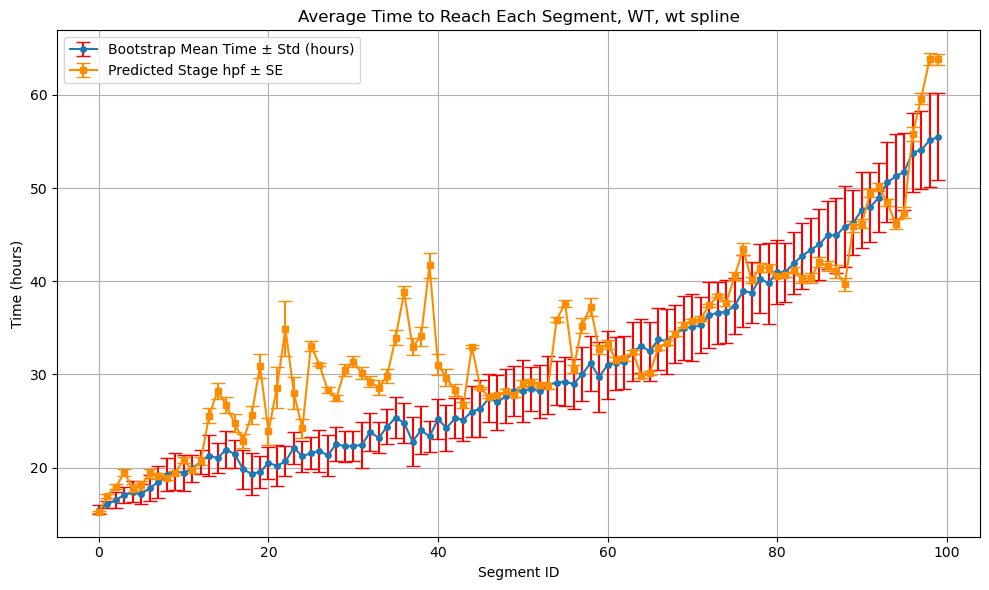

In [264]:
df_merged = df_augmented.merge(
    wt_projection_to_wt[["snip_id", "ref_seg_id"]],
    on="snip_id",
    how="left"
)


df_merged_wt = df_merged[df_merged["phenotype"]=="wt"]
# Run bootstrap journeys
num_journeys =  100 # Adjust based on computational resources


journeys_df_wt = run_bootstrap_journeys(
    df_augmented=df_merged_wt, #subset to perturbation you want to caluclate spline for 
    num_journeys=num_journeys,
    start_segment=0,
    end_segment=None,  # Defaults to max segment
    random_seed=42,
    time_column = "experiment_time",
    segment_id_col = "ref_seg_id"
)
summary_df_wt_calc = summarize_journeys(journeys_df_wt)

plot_summary(summary_df_wt_calc, df_merged, title="Average Time to Reach Each Segment, WT, wt spline")




In [254]:
summary_df_wt_calc

segment_id      mean_time      std_time  count  mean_time_hours  \
0          0.0     925.346006   1595.364138    150        15.552623   
1          1.0    2901.780818   1265.826935     66        16.101633   
2          2.0    4737.120766   3045.221192     38        16.611450   
3          3.0    6624.403172   2980.135509     54        17.135695   
4          4.0    7870.785247   3974.845819     42        17.481912   
..         ...            ...           ...    ...              ...   
95        95.0  131509.836044  14878.954680    231        51.826093   
96        96.0  138804.664926  15246.728780    353        53.852434   
97        97.0  139851.745173  15066.963329    194        54.143290   
98        98.0  143550.272428  18180.604784    286        55.170659   
99        99.0  144914.722918  16775.993225    100        55.549673   

    std_time_hours  
0         0.443157  
1         0.351619  
2         0.845895  
3         0.827815  
4         1.104124  
..             ...  
95        4.133043  
96        4.235202  
97        4.185268  
98        5.050168  
99        4.659998  

[100 rows x 6 columns]

In [246]:
summary_df_wt_calc

segment_id      mean_time      std_time  count  mean_time_hours  \
0          0.0     925.346006   1595.364138    150        15.552623   
1          1.0    2901.780818   1265.826935     66        16.101633   
2          2.0    4737.120766   3045.221192     38        16.611450   
3          3.0    6624.403172   2980.135509     54        17.135695   
4          4.0    7870.785247   3974.845819     42        17.481912   
..         ...            ...           ...    ...              ...   
95        95.0  131509.836044  14878.954680    231        51.826093   
96        96.0  138804.664926  15246.728780    353        53.852434   
97        97.0  139851.745173  15066.963329    194        54.143290   
98        98.0  143550.272428  18180.604784    286        55.170659   
99        99.0  144914.722918  16775.993225    100        55.549673   

    std_time_hours  
0         0.443157  
1         0.351619  
2         0.845895  
3         0.827815  
4         1.104124  
..             ...  
95        4.133043  
96        4.235202  
97        4.185268  
98        5.050168  
99        4.659998  

[100 rows x 6 columns]

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning:

invalid value encountered in reduce

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning:

invalid value encountered in reduce



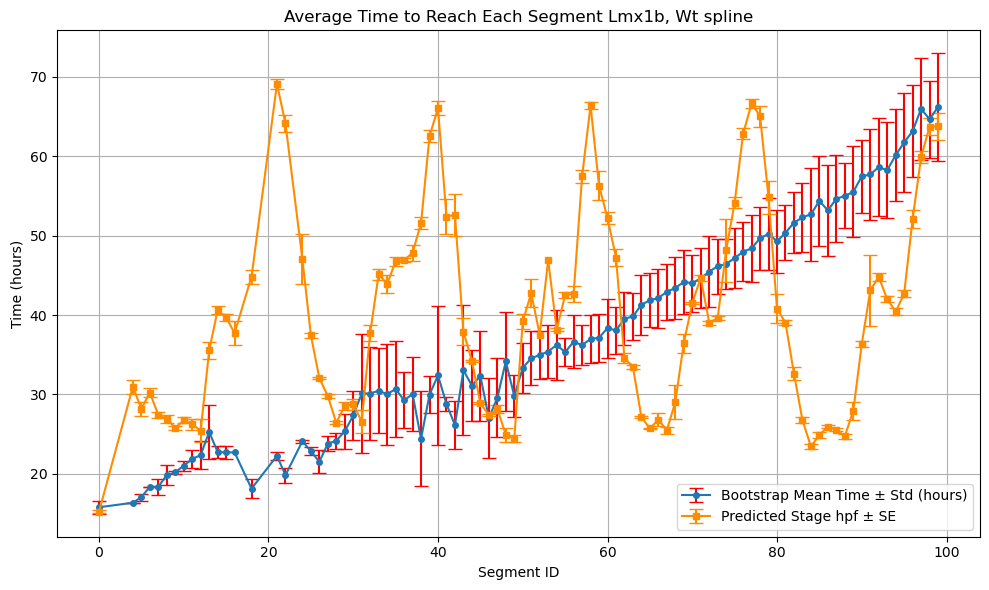

In [263]:
df_merged = df_augmented.merge(
    lmx1b_projection_to_wt[["snip_id", "ref_seg_id"]],
    on="snip_id",
    how="left"
)

df_merged_lmx1b = df_merged[df_merged["phenotype"]=="lmx1b"]

journeys_df = run_bootstrap_journeys(
    df_augmented = df_merged_lmx1b, #subset to perturbation you want to caluclate spline for 
    num_journeys=num_journeys,
    start_segment=0,
    end_segment=None,  # Defaults to max segment
    random_seed=42,
    time_column = "experiment_time",
    segment_id_col = "ref_seg_id"
)

summary_df_lmx1b_calc = summarize_journeys(journeys_df)

plot_summary(summary_df_lmx1b_calc, df_merged_lmx1b, title="Average Time to Reach Each Segment Lmx1b, Wt spline")

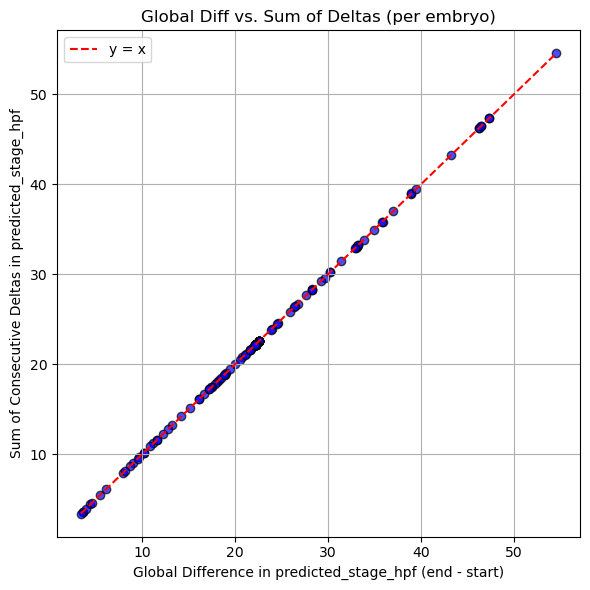

In [265]:
plot_sum_of_deltas_vs_global_diff(df_merged_lmx1b)

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning:

invalid value encountered in reduce

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning:

invalid value encountered in reduce



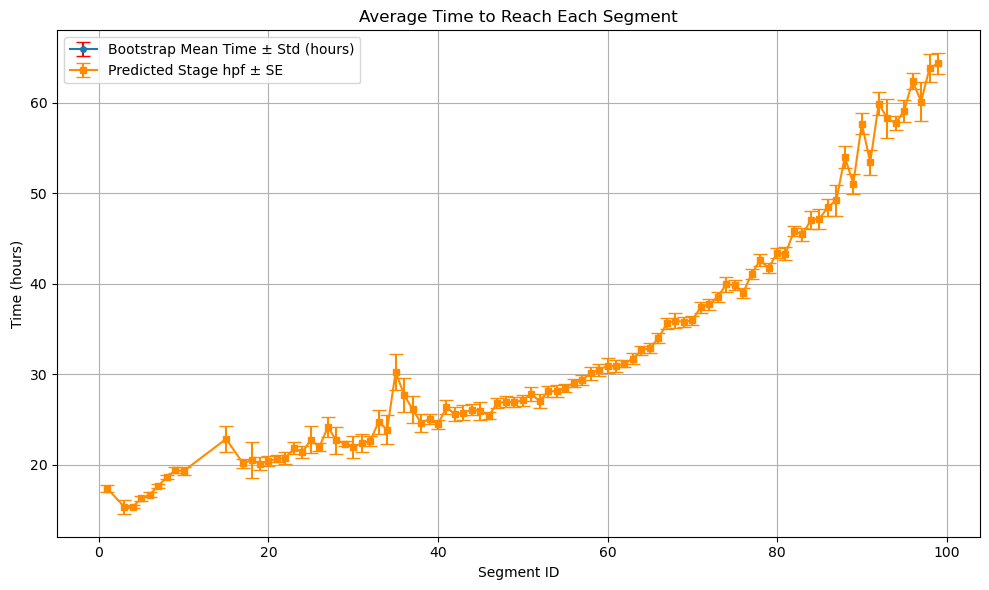

In [251]:
df_merged = df_augmented.merge(
    inj_ctrl_projection_to_wt[["snip_id", "ref_seg_id"]],
    on="snip_id",
    how="left"
)

df_merged = df_merged[df_merged["phenotype"]=="inj-ctrl"]

journeys_df_injctrl = run_bootstrap_journeys(
    df_augmented = df_merged, #subset to perturbation you want to caluclate spline for 
    num_journeys=num_journeys,
    start_segment=0,
    end_segment=None,  # Defaults to max segment
    random_seed=42,
    time_column = "experiment_time",
    segment_id_col = "ref_seg_id"
)

summary_df_inj_ctrl_calc = summarize_journeys(journeys_df_injctrl)

plot_summary(summary_df_inj_ctrl_calc, df_merged, title="Average Time to Reach Each Segment")

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning:

invalid value encountered in reduce

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning:

invalid value encountered in reduce



NameError: name 'title' is not defined

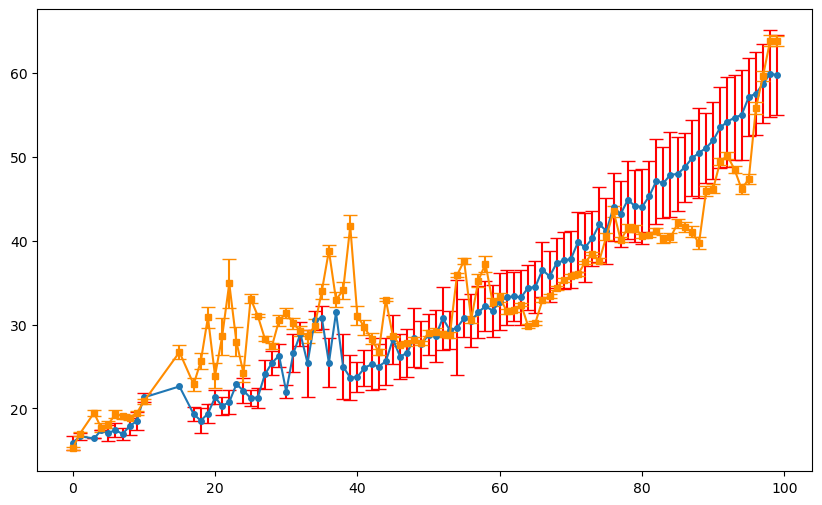

In [257]:
summary_df = summary_df_inj_ctrl_calc 
starting_seg =int(min(summary_df["segment_id"]))
time_init = df_augmented[df_augmented["segment_id"] == starting_seg]["predicted_stage_hpf"].mean()

summary_df["mean_time_hours"] = summary_df["mean_time"] / 3600.0 + time_init
summary_df["std_time_hours"] = summary_df["std_time"] / 3600.0

# 2. Compute mean predicted_stage_hpf and standard error by segment
pred_stats = (
    df_augmented.groupby("segment_id")["predicted_stage_hpf"]
    .agg(["mean", "std", "count"])
    .reset_index()
)


pred_stats.columns = ["segment_id", "mean_pred_hpf", "std_pred_hpf", "count_pred"]
pred_stats["se_pred_hpf"] = pred_stats["std_pred_hpf"] / np.sqrt(pred_stats["count_pred"])


# 3. Merge the predicted stats with the summary of bootstrap times
plot_df = pd.merge(summary_df, pred_stats, on="segment_id", how="left")

# 4. Plot the bootstrap times (hours) with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(
    plot_df["segment_id"],
    plot_df["mean_time_hours"],
    yerr=plot_df["std_time_hours"],
    fmt='-o',
    ecolor='red',
    capsize=5,
    markersize=4,
    label='Bootstrap Mean Time ± Std (hours)'
)

# 5. Plot predicted stage hpf (also in hours) with standard error
plt.errorbar(
    plot_df["segment_id"],
    plot_df["mean_pred_hpf"],
    yerr=plot_df["se_pred_hpf"],
    fmt='-s',
    color='darkorange',
    capsize=5,
    markersize=4,
    label='Predicted Stage hpf ± SE'
)

# 6. Final formatting
plt.title(title)
plt.xlabel("Segment ID")
plt.ylabel("Time (hours)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [100]:


def plot_multi_bootstrap(
    data_list,
    labels,
    title="Comparison of Average Times for Different Conditions",
    use_time_init=True
):
    """
    Plot multiple bootstrap time curves (mean ± std) on a single figure.
    
    Parameters
    ----------
    data_list : list of tuples
        Each element is (summary_df, df_augmented) for a particular condition.
        - summary_df must have columns ['segment_id', 'mean_time', 'std_time'].
          'mean_time' and 'std_time' are in seconds, aggregated over bootstrap journeys.
        - df_augmented must have at least ['segment_id', 'predicted_stage_hpf'] 
          if using time_init. If 'use_time_init' is False, df_augmented can be None.
          
    labels : list of str
        Labels for each condition (used in legend). Must match length of `data_list`.
        
    title : str
        Title for the final plot.
        
    use_time_init : bool
        If True, shifts the bootstrap mean_time by the average predicted_stage_hpf
        at the first segment found in 'summary_df'. If False, no offset is added.
    
    Returns
    -------
    None (displays a matplotlib figure)
    """
    if len(data_list) != len(labels):
        raise ValueError("data_list and labels must have the same length.")

    plt.figure(figsize=(10, 6))

    for (summary_df, df_aug), cond_label in zip(data_list, labels):
        summary_df = summary_df.copy()

        # Convert from seconds to hours
        summary_df["mean_time_hours"] = summary_df["mean_time"] / 3600.0
        summary_df["std_time_hours"] = summary_df["std_time"] / 3600.0
        
        if use_time_init:
            # Shift by the average predicted_stage_hpf for the starting segment
            # found in summary_df
            start_seg = int(summary_df["segment_id"].min())
            if df_aug is not None:
                # Compute the offset time_init from the data
                seg_mask = (df_aug["segment_id"] == start_seg)
                # In case no rows match, we handle it safely
                if seg_mask.any():
                    time_init = df_aug.loc[seg_mask, "predicted_stage_hpf"].mean()
                else:
                    time_init = 0.0
            else:
                # If df_aug not provided, can't compute time_init
                time_init = 0.0
            
            summary_df["mean_time_hours"] += time_init

        # Plot the bootstrap times (hours) with error bars
        plt.errorbar(
            summary_df["segment_id"],
            summary_df["mean_time_hours"],
            yerr=summary_df["std_time_hours"],
            fmt='-o',
            capsize=5,
            markersize=4,
            label=cond_label
        )

    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning:

invalid value encountered in reduce

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning:

invalid value encountered in reduce



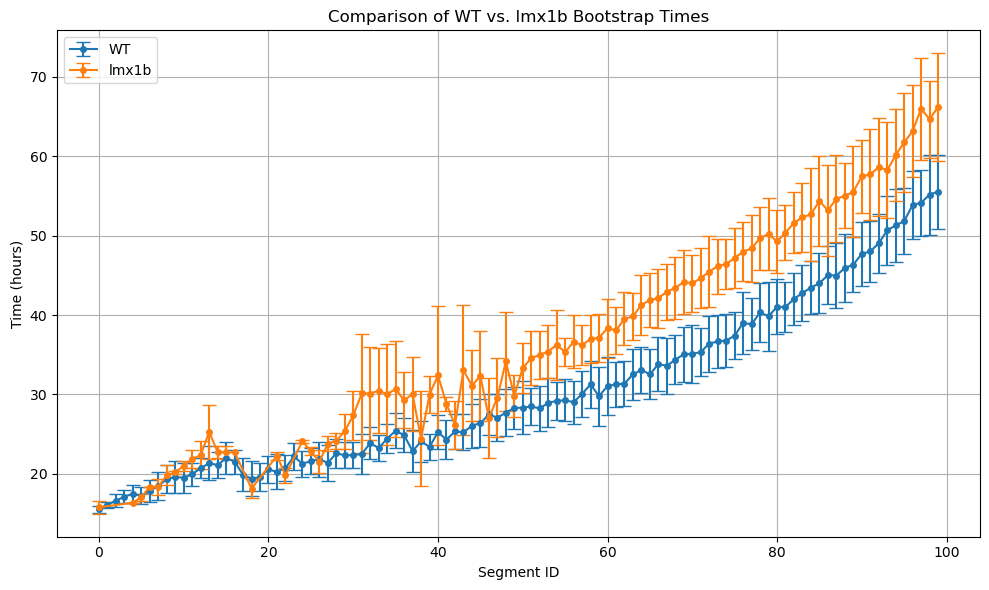

In [262]:
data_list = [
    (summary_df_wt_calc, df_merged_wt),
    (summary_df_lmx1b_calc, df_merged_lmx1b)
]

labels = ["WT", "lmx1b"]

plot_multi_bootstrap(
    data_list,
    labels,
    title="Comparison of WT vs. lmx1b Bootstrap Times",
    use_time_init=True  # or False, if you don't want an offset
)

In [266]:
projection_dfs = [
    wt_projection_to_wt,
    lmx1b_projection_to_wt,
    inj_ctrl_projection_to_wt,
    
    
    
    
    ]


fig = plot_3d_spline_and_projections(
    projection_dfs =projection_dfs,
    segment_info_df=wt_splines_n_planes,
    pert_splines=pert_splines,  # or None if you don't have/need them
    save_dir=save_dir,
    filename="3d_vis_spline_n_planes_wt_lmx1b_test_used for bootstral.html",
    k=None,
    title="My 3D Spline + Projection Visualization lmx1b and wt sued for bootstrap",
    plane_opacity=0.2,
    axis_length=0.5,
    show_legend=True
)

3D visualization saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/3d_vis_spline_n_planes_wt_lmx1b_test_used for bootstral.html


# Measuring the difference in delays

In [5]:
# Specify the minimum number of snip_ids per embryo_id
pert_comparisons = ["wt","lmx1b", "inj-ctrl"]

min_snips = 20

# Filter the DataFrame to only include embryo_id with at least `min_snips` snip_ids
df    = df_orig.groupby('embryo_id').filter(lambda x: len(x) >= min_snips)
df_30 = df[df["temperature"]==30.0]
df_22 = df[df["temperature"]==22.0]


df_30   = apply_pca_on_pert_comparisons(df_30  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
# df_22   = apply_pca_on_pert_comparisons(df_22  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
# df      = apply_pca_on_pert_comparisons(df_orig,z_mu_biological_columns,pert_comparisons=pert_comparisons )

Using specified perturbations for PCA: ['wt', 'lmx1b', 'inj-ctrl']

PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 85.35%

Principal Component Explained Variance Ratio
              PCA_1                   41.39%
              PCA_2                   33.56%
              PCA_3                   10.41%
----------------------------



/tmp/9264373.1.trapnell-login.q/ipykernel_2565702/902460450.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pcs[:, i]


In [14]:

import pandas as pd
import seaborn as sns


def plot_multi_bootstrap(
    data_list,
    labels,
    title="Comparison of Average Times for Different Conditions",
    use_time_init=True
):
    """
    Plot multiple bootstrap time curves (mean ± std) on a single figure.
    
    Parameters
    ----------
    data_list : list of tuples
        Each element is (summary_df, df_augmented) for a particular condition.
        - summary_df must have columns ['segment_id', 'mean_time', 'std_time'].
          'mean_time' and 'std_time' are in seconds, aggregated over bootstrap journeys.
        - df_augmented must have at least ['segment_id', 'predicted_stage_hpf'] 
          if using time_init. If 'use_time_init' is False, df_augmented can be None.
          
    labels : list of str
        Labels for each condition (used in legend). Must match length of `data_list`.
        
    title : str
        Title for the final plot.
        
    use_time_init : bool
        If True, shifts the bootstrap mean_time by the average predicted_stage_hpf
        at the first segment found in 'summary_df'. If False, no offset is added.
    
    Returns
    -------
    None (displays a matplotlib figure)
    """
    if len(data_list) != len(labels):
        raise ValueError("data_list and labels must have the same length.")

    plt.figure(figsize=(10, 6))

    for (summary_df, df_aug), cond_label in zip(data_list, labels):
        summary_df = summary_df.copy()

        # Convert from seconds to hours
        summary_df["mean_time_hours"] = summary_df["mean_time"] / 3600.0
        summary_df["std_time_hours"] = summary_df["std_time"] / 3600.0
        
        if use_time_init:
            # Shift by the average predicted_stage_hpf for the starting segment
            # found in summary_df
            start_seg = int(summary_df["segment_id"].min())
            if df_aug is not None:
                # Compute the offset time_init from the data
                seg_mask = (df_aug["segment_id"] == start_seg)
                # In case no rows match, we handle it safely
                if seg_mask.any():
                    time_init = df_aug.loc[seg_mask, "predicted_stage_hpf"].mean()
                else:
                    time_init = 0.0
            else:
                # If df_aug not provided, can't compute time_init
                time_init = 0.0
            
            summary_df["mean_time_hours"] += time_init

        # Plot the bootstrap times (hours) with error bars
        plt.errorbar(
            summary_df["segment_id"],
            summary_df["mean_time_hours"],
            yerr=summary_df["std_time_hours"],
            fmt='-o',
            capsize=5,
            markersize=4,
            label=cond_label
        )

    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_developmental_shifts(df_embryos, summary_df_wt_calc, color_by="phenotype"):
    """
    For each embryo_id in df_embryos:
      1) Identify earliest and latest time points (by experiment_time).
      2) Compute embryo's morphological velocity = (Delta time in hours) / (Delta segment).
      3) Compute reference morphological velocity for the same segment range
         using summary_df_wt_calc's mean_time_hours.
      4) developmental_shift = ref_morph_velocity - embryo_morph_velocity.

    Returns a DataFrame with columns:
      [
        "embryo_id", 
        "earliest_segment", 
        "latest_segment", 
        "embryo_morph_velocity", 
        "ref_morph_velocity", 
        "developmental_shift", 
        color_by
      ]
    One row per embryo_id.
    
    Parameters
    ----------
    df_embryos : pd.DataFrame
        Must have columns:
          - embryo_id
          - experiment_time (seconds)
          - ref_seg_id
          - plus the column for coloring (e.g., phenotype)
    summary_df_wt_calc : pd.DataFrame
        Must have columns:
          - segment_id
          - mean_time_hours (average time to that segment, in hours)
    color_by : str
        Column name in df_embryos to use for coloring or grouping in the histogram.
    """
    results = []
    
    grouped = df_embryos.groupby("embryo_id")
    for emb_id, group in grouped:
        # Sort by time
        group_sorted = group.sort_values("experiment_time")
        if len(group_sorted) < 2:
            # Not enough data points to define earliest and latest
            continue
        
        # Earliest & latest rows
        first_row = group_sorted.iloc[0]
        last_row  = group_sorted.iloc[-1]
        
        # Convert time to hours
        time_early_hrs = first_row["experiment_time"] / 3600.0
        time_late_hrs  = last_row["experiment_time"]  / 3600.0
        delta_time_hrs = time_late_hrs - time_early_hrs
        
        # Earliest & latest ref_seg_id
        seg_early = first_row["ref_seg_id"]
        seg_late  = last_row["ref_seg_id"]
        
        # If the earliest segment or latest segment is NaN or there's no difference, skip
        if pd.isnull(seg_early) or pd.isnull(seg_late) or seg_early == seg_late:
            continue
        
        # Delta in segment space
        delta_seg = seg_late - seg_early
        
        # Embryo morphological velocity
        embryo_morph_velocity =  delta_seg / delta_time_hrs
        
        # Reference morphological velocity:
        #   We find the reference's average time for earliest & latest segment
        #   from summary_df_wt_calc. Then compute the difference and scale by delta_seg.
        #   i.e. ref_morph_velocity = (ref_time_late - ref_time_early) / delta_seg
        ref_row_early = summary_df_wt_calc.loc[summary_df_wt_calc["segment_id"] == seg_early]
        ref_row_late  = summary_df_wt_calc.loc[summary_df_wt_calc["segment_id"] == seg_late]
        if len(ref_row_early) == 0 or len(ref_row_late) == 0:
            # The reference summary might not have these segments
            continue
        
        ref_time_early = ref_row_early["mean_time_hours"].iloc[0]
        ref_time_late  = ref_row_late["mean_time_hours"].iloc[0]
        ref_delta_time = ref_time_late - ref_time_early
        
        ref_morph_velocity =  delta_seg / ref_delta_time
        
        # Developmental shift
        developmental_shift =  embryo_morph_velocity - ref_morph_velocity
        
        # Grab the color-by value from either the first or last row
        # (assuming it's consistent for the entire embryo)
        col_value = first_row.get(color_by, np.nan)
        
        results.append({
            "embryo_id": emb_id,
            "earliest_segment": seg_early,
            "latest_segment": seg_late,
            "embryo_morph_velocity": embryo_morph_velocity,
            "ref_morph_velocity": ref_morph_velocity,
            "developmental_shift": developmental_shift,
            color_by: col_value
        })
    
    return pd.DataFrame(results)

def plot_developmental_shifts_violin(shift_df, color_by="phenotype", show_dots=True, remove_outliers=True):
    """
    Given a DataFrame with a 'developmental_shift' column and a grouping column (color_by),
    plot a violin plot of the developmental shifts, grouped by the specified column,
    with an option to overlay individual points as a strip plot and to remove extreme outliers.
    
    Parameters
    ----------
    shift_df : pd.DataFrame
        Must have columns ['developmental_shift', color_by].
    color_by : str
        Column name in shift_df to group by for the violin plot.
    show_dots : bool, optional
        Whether to overlay individual points on the violin plot (default: True).
    remove_outliers : bool, optional
        Whether to remove extreme outliers based on the IQR method (default: True).
    """
    # Optionally remove outliers
    if remove_outliers:
        q1 = shift_df["developmental_shift"].quantile(0.25)
        q3 = shift_df["developmental_shift"].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        shift_df = shift_df[(shift_df["developmental_shift"] >= lower_bound) & 
                            (shift_df["developmental_shift"] <= upper_bound)]
    
    plt.figure(figsize=(8, 6))

    # Create violin plot
    sns.violinplot(
        data=shift_df,
        x=color_by,
        y="developmental_shift",
        inner="box",  # Show quartiles and medians inside violins
        scale="width",  # Adjust violin width by number of observations per group
        palette="muted"
    )
    
    # Optionally overlay individual points
    if show_dots:
        sns.stripplot(
            data=shift_df,
            x=color_by,
            y="developmental_shift",
            color="black",  # Black dots
            alpha=0.6,      # Semi-transparent for overlapping points
            jitter=True,    # Add jitter to spread points horizontally
            dodge=True      # Separate points slightly for each hue group (if applicable)
        )

    # Customize plot
    plt.title("Developmental Shift Distribution by " + color_by.capitalize())
    plt.xlabel(color_by.capitalize())
    plt.ylabel("Developmental Shift (ref_morph_velocity - embryo_morph_velocity)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [6]:
pert_splines, df_augmented, segment_info_df = build_splines_and_segments(
    df=df_30,
    comparisons=pert_comparisons,
    save_dir=save_dir,
    model_index=model_index,
    LocalPrincipalCurveClass=LocalPrincipalCurve,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=50
)

Using specified comparisons for spline building: ['wt', 'lmx1b', 'inj-ctrl']
Building spline data for each phenotype...


Creating splines for each phenotype:   0%|                                                                                                                                  | 0/3 [00:00<?, ?it/s]

Starting point not in dataset. Using closest point: [ 1.48969681  1.78109378 -0.85248292]


Creating splines for each phenotype:  33%|████████████████████████████████████████▋                                                                                 | 1/3 [00:06<00:13,  6.71s/it]

Starting point not in dataset. Using closest point: [ 1.58724164  1.9738906  -0.48371219]


Creating splines for each phenotype:  67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 2/3 [00:14<00:07,  7.07s/it]

Starting point not in dataset. Using closest point: [ 1.41584415  1.84864023 -1.20365681]


Creating splines for each phenotype: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.25s/it]


Spline DataFrame 'pert_splines' saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/pert_splines_74_unique.csv
Assigning segments and building segment_info_df...


Processing phenotypes: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:06<00:00, 22.15s/it]


In [7]:
wt_splines_n_planes = segment_info_df[segment_info_df["phenotype"] == "wt"]

# A) Points from "wt" itself
# wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]
df_points = project_points_onto_reference_spline(
    df_augmented,
    wt_splines_n_planes
)

In [8]:
df_augmented_projec_wt = pd.merge(
    df_augmented, 
    df_points.drop(columns=[col for col in df_points.columns if col in df_augmented.columns and col != "snip_id"]),
    on="snip_id"
)

In [9]:
df_augmented_projec_wt

Unnamed: 0                 snip_id         embryo_id  experiment_time  \
0           28553  20231110_A08_e00_t0000  20231110_A08_e00      1919.332160   
1           28554  20231110_A08_e00_t0001  20231110_A08_e00      4951.991120   
2           28555  20231110_A08_e00_t0003  20231110_A08_e00     10012.480400   
3           28556  20231110_A08_e00_t0004  20231110_A08_e00     12550.292000   
4           28557  20231110_A08_e00_t0005  20231110_A08_e00     15075.814400   
...           ...                     ...               ...              ...   
21879       89859  20241023_H06_e00_t0038  20241023_H06_e00     64127.787030   
21880       89860  20241023_H06_e00_t0039  20241023_H06_e00     65796.455422   
21881       89861  20241023_H06_e00_t0040  20241023_H06_e00     67465.614316   
21882       89862  20241023_H06_e00_t0041  20241023_H06_e00     69139.277532   
21883       89863  20241023_H06_e00_t0042  20241023_H06_e00     70809.139389   

      experiment_date  temperature  medium short_pert_name  control_flag  \
0            20231110           30  MC_015          wt_wik             0   
1            20231110           30  MC_015          wt_wik             0   
2            20231110           30  MC_015          wt_wik             0   
3            20231110           30  MC_015          wt_wik             0   
4            20231110           30  MC_015          wt_wik             0   
...               ...          ...     ...             ...           ...   
21879        20241023           30      EM           wt_ab             0   
21880        20241023           30      EM           wt_ab             0   
21881        20241023           30      EM           wt_ab             0   
21882        20241023           30      EM           wt_ab             0   
21883        20241023           30      EM           wt_ab             0   

      phenotype  ...  ref_seg_id  closest_on_spline_x  closest_on_spline_y  \
0            wt  ...           3             1.190960             2.137454   
1            wt  ...           4             1.162123             2.164221   
2            wt  ...           4             1.015367             2.299769   
3            wt  ...           5             0.955834             2.330261   
4            wt  ...           5             0.910098             2.351846   
...         ...  ...         ...                  ...                  ...   
21879        wt  ...          44             2.001059            -0.554223   
21880        wt  ...          44             2.112583            -0.494011   
21881        wt  ...          44             2.097938            -0.501917   
21882        wt  ...          45             2.191328            -0.449942   
21883        wt  ...          45             2.156886            -0.469772   

       closest_on_spline_z plane_point_x  plane_point_y  plane_point_z  \
0                -0.740238      1.250699       2.184132      -0.800249   
1                -0.733356      1.244330       2.276340      -0.828889   
2                -0.698438      1.029524       2.323010      -0.713413   
3                -0.678068      0.981727       2.409437      -0.716426   
4                -0.661953      0.919452       2.381430      -0.676498   
...                    ...           ...            ...            ...   
21879             0.142845      1.942366      -0.436091       0.151103   
21880             0.224246      2.040451      -0.354805       0.237394   
21881             0.213557      2.026552      -0.364684       0.225778   
21882             0.283892      2.099327      -0.345748       0.265669   
21883             0.257029      2.049032      -0.334158       0.242418   

       distance_to_plane  distance_to_axis  hypotenuse  
0               0.542623          0.144243    0.561467  
1               0.054838          0.189618    0.197388  
2               0.148773          0.123837    0.193569  
3               0.084798          0.110737    0.139475  
4               0.0214

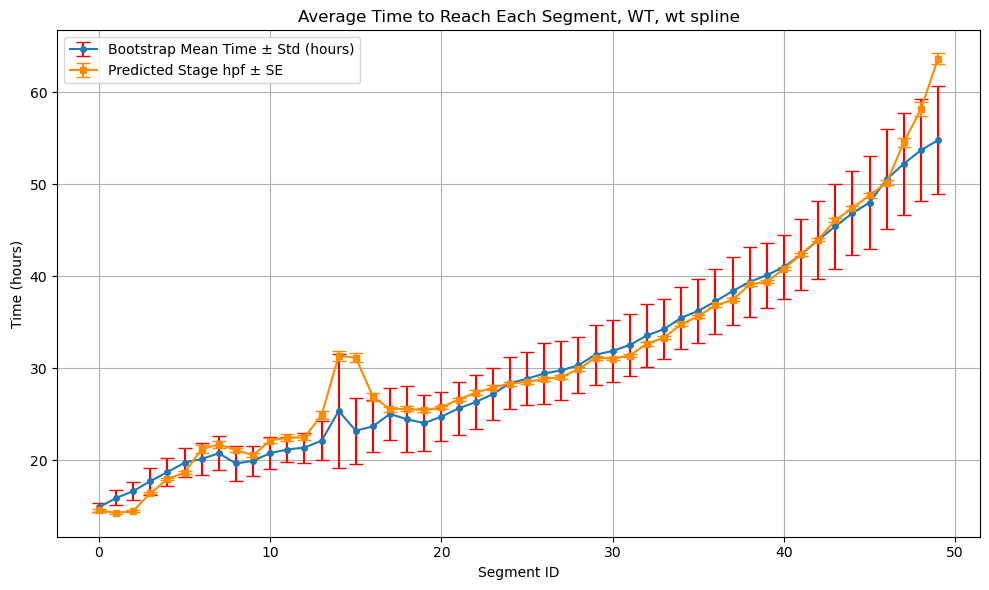

In [10]:



df_augmented_wt = df_augmented_projec_wt[df_augmented_projec_wt["phenotype"]=="wt"]
# Run bootstrap journeys
num_journeys =  500 # Adjust based on computational resources


journeys_df_wt = run_bootstrap_journeys(
    df_augmented=df_augmented_wt, #subset to perturbation you want to caluclate spline for 
    num_journeys=num_journeys,
    start_segment=0,
    end_segment=None,  # Defaults to max segment
    random_seed=42,
    time_column = "experiment_time",
    segment_id_col = "ref_seg_id"
)

summary_df_wt_calc = summarize_journeys(journeys_df_wt)

plot_summary(summary_df_wt_calc, df_augmented_wt, title="Average Time to Reach Each Segment, WT, wt spline")



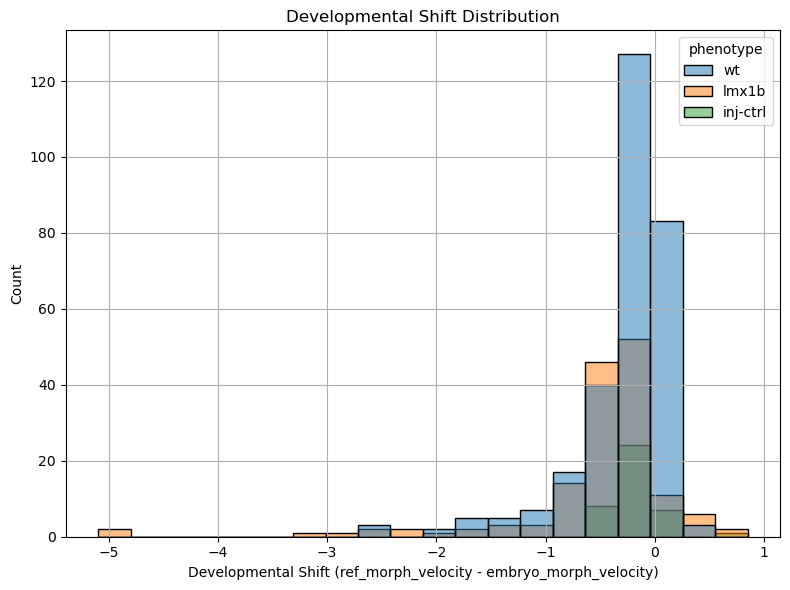

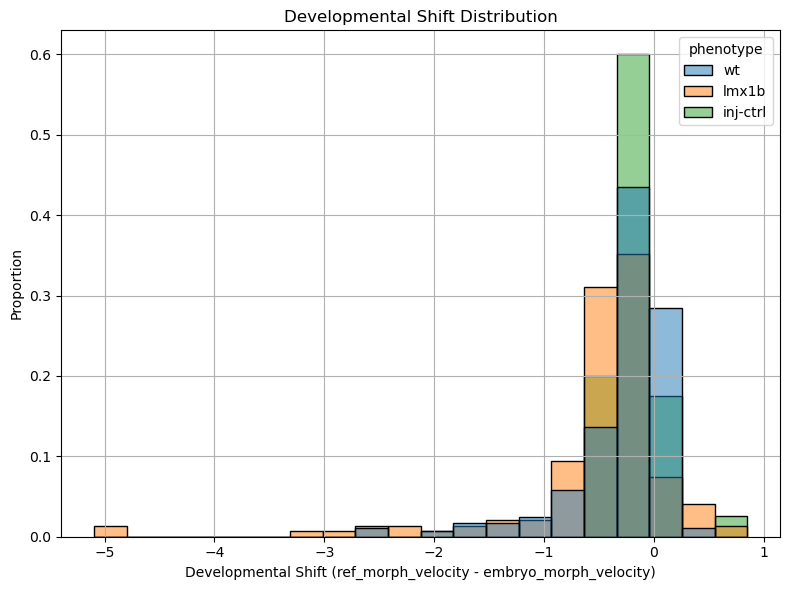

In [34]:

import seaborn as sns

def plot_developmental_shifts(
    shift_df, 
    color_by="phenotype", 
    bins=20, 
    normalize=False
):
    """
    Given a DataFrame with a 'developmental_shift' column and a grouping column (color_by),
    plot a histogram of the developmental shifts, coloring/hue by color_by using seaborn.
    
    Parameters
    ----------
    shift_df : pd.DataFrame
        Must have columns ['developmental_shift', color_by]
    color_by : str
        Column name to color by in the histogram.
    bins : int
        Number of bins in the histogram.
    normalize : bool
        If True, the histogram is normalized so that the total area is 1 (per hue category).
        If False, it plots raw counts.
    """
    plt.figure(figsize=(8, 6))

    if normalize:
        # Plot proportion (0 to 1), total area per hue category = 1
        # Set `common_norm=True` if you want *all* hue categories collectively 
        # to sum to 1 instead of each category individually. 
        sns.histplot(
            data=shift_df, 
            x="developmental_shift", 
            hue=color_by, 
            bins=bins, 
            kde=False,
            stat="probability",   # Normalized histogram
            common_norm=False     # Each hue level sums to 1
        )
        plt.ylabel("Proportion")
    else:
        # Plot raw counts
        sns.histplot(
            data=shift_df, 
            x="developmental_shift", 
            hue=color_by, 
            bins=bins, 
            kde=False,
            stat="count"
        )
        plt.ylabel("Count")

    plt.title("Developmental Shift Distribution")
    plt.xlabel("Developmental Shift (ref_morph_velocity - embryo_morph_velocity)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()ther (or the same) set of embryos in df_augmented_any

# Let's compute the shifts for df_augmented_wt itself, colored by "phenotype".

shift_df = compute_developmental_shifts(
    df_embryos=df_augmented_projec_wt,
    summary_df_wt_calc=summary_df_wt_calc,
    color_by="phenotype"
)

# Now plot them
plot_developmental_shifts(
    shift_df=shift_df,
    color_by="phenotype",
    bins=20  # pick # of bins to taste
)

# Now plot them
plot_developmental_shifts(
    shift_df=shift_df,
    color_by="phenotype",
    bins=20,
    normalize = True  
)


/tmp/9264373.1.trapnell-login.q/ipykernel_2565702/2005811164.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/9264373.1.trapnell-login.q/ipykernel_2565702/2005811164.py:22: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


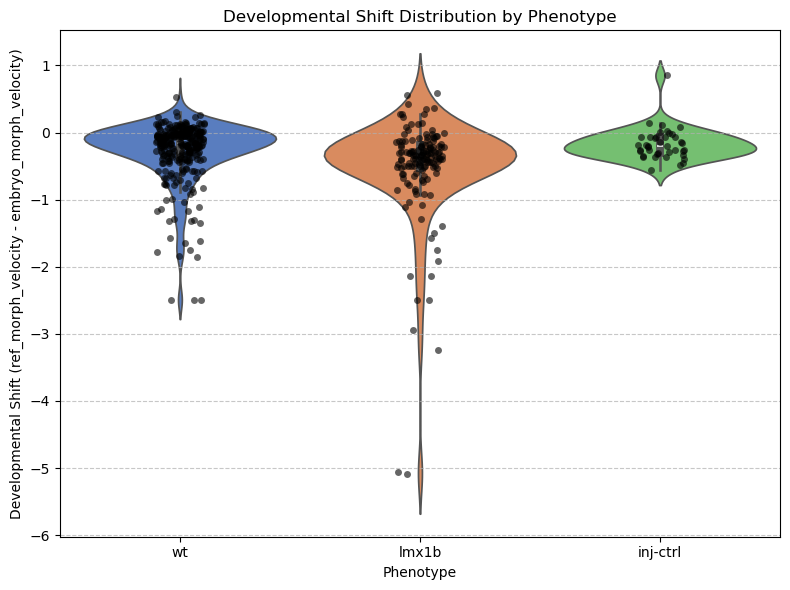

In [52]:
# Assuming shift_df is your DataFrame
plot_developmental_shifts_violin(shift_df, color_by="phenotype")# Assuming shift_df is your DataFrame

In [ ]:
df

In [21]:
shift_df[shift_df["embryo_id"]=="20240509_E11_e00"]
shift_df

embryo_id  earliest_segment  latest_segment  \
0     20230525_A03_e00                 4              44   
1     20230525_A05_e00                 6              25   
2     20230525_A06_e00                 4              25   
3     20230525_A07_e00                 4              42   
4     20230525_A09_e00                 2              44   
...                ...               ...             ...   
1020  20241023_G06_e00                31              44   
1021  20241023_H02_e00                28              45   
1022  20241023_H04_e00                29              46   
1023  20241023_H05_e00                31              44   
1024  20241023_H06_e00                28              45   

      embryo_morph_velocity  ref_morph_velocity  developmental_shift  \
0                  0.799936            1.368273            -0.568338   
1                  0.991245            2.143501            -1.152256   
2                  1.200008            2.121115            -0.921107   
3                  0.949946            1.498759            -0.548813   
4                  0.854181            1.403377            -0.549195   
...                     ...                 ...                  ...   
1020               1.039863            0.850387             0.189476   
1021               0.872987            0.944875            -0.071888   
1022               0.940511            0.818992             0.121519   
1023               0.667984            0.850387            -0.182404   
1024               0.873518            0.944875            -0.071357   

      phenotype  
0     wt_temp22  
1     wt_temp22  
2     wt_temp22  
3     wt_temp22  
4     wt_temp22  
...         ...  
1020  wt_temp30  
1021  wt_temp30  
1022  wt_temp30  
1023  wt_temp30  
1024  wt_temp30  

[1025 rows x 7 columns]

In [67]:
import pandas as pd
import seaborn as sns
from typing import Union, List

def plot_stage_vs_ref_seg(
    df: pd.DataFrame,
    embryo_ids: Union[str, List[str]],
    imp_cols: List[str] = ["phenotype","embryo_id","snip_id","predicted_stage_hpf","ref_seg_id"],
    sort_by_x: bool = True,
    save_path: str = None
):
    """
    Plots 'predicted_stage_hpf' on the x-axis and 'ref_seg_id' on the y-axis for the given embryo_id(s).
    Each embryo_id is represented by a connected line on the same figure, colored by embryo_id.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data.
    embryo_ids : str or list of str
        A single embryo_id or a list of embryo_ids to plot.
    imp_cols : list of str, optional
        List of important columns to filter and use for plotting. 
        Default: ["phenotype", "embryo_id", "snip_id", "predicted_stage_hpf", "ref_seg_id"].
    sort_by_x : bool, optional
        Whether to sort the data by 'predicted_stage_hpf' before plotting, ensuring a proper left-to-right line.
        Default: True.
    save_path : str, optional
        If provided, saves the plot to the specified path. 
        Otherwise, the plot is displayed.

    Returns
    -------
    None
    """
    # Ensure embryo_ids is a list
    if isinstance(embryo_ids, str):
        embryo_ids = [embryo_ids]
    elif isinstance(embryo_ids, list):
        if not all(isinstance(eid, str) for eid in embryo_ids):
            raise ValueError("All embryo_ids must be strings.")
    else:
        raise TypeError("embryo_ids must be a string or a list of strings.")

    # Filter the DataFrame for the given embryo_ids
    df_filtered = df.loc[df["embryo_id"].isin(embryo_ids), imp_cols].copy()
    if df_filtered.empty:
        raise ValueError("No data found for the provided embryo_id(s).")

    # Optionally sort by predicted_stage_hpf so lines go left-to-right
    if sort_by_x:
        df_filtered.sort_values(by=["embryo_id", "predicted_stage_hpf"], inplace=True)

    # Initialize plot style
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Create a line plot (connected lines) for each embryo_id, colored by embryo_id
    sns.lineplot(
        data=df_filtered,
        x="predicted_stage_hpf",
        y="ref_seg_id",
        hue="embryo_id",
        marker="o"  # optional, to show markers at data points
    )

    # Labeling
    plt.xlabel("Predicted Stage (HPF)")
    plt.ylabel("Ref Seg ID")
    plt.title("Ref Seg ID vs. Predicted Stage HPF")

    # Adjust legend and layout
    plt.legend(title="Embryo ID", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

###############################################################################
def get_equally_spaced_embryo_ids(
    df: pd.DataFrame, 
    col_dev_shift: str = "developmental_shift", 
    n: int = 10
) -> list:
    """
    Returns n embryo_ids equally spaced along the 'col_dev_shift' range.
    
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing at least 'embryo_id' and 'col_dev_shift' columns.
    col_dev_shift : str, optional
        The column in df representing the developmental shift. Default: 'developmental_shift'.
    n : int, optional
        The number of equally spaced embryo_ids to return. Default: 10.
    
    Returns
    -------
    list
        A list of embryo_ids equally spaced across the 'col_dev_shift' range.
    """
    # Check columns
    if "embryo_id" not in df.columns:
        raise KeyError("Column 'embryo_id' is not present in the DataFrame.")
    if col_dev_shift not in df.columns:
        raise KeyError(f"Column '{col_dev_shift}' is not present in the DataFrame.")

    # Drop rows with missing values in the relevant columns
    df_clean = df.dropna(subset=["embryo_id", col_dev_shift]).copy()
    if df_clean.empty:
        raise ValueError("No valid rows in the DataFrame after dropping NA values.")

    # Sort by developmental shift in ascending order
    df_clean.sort_values(by=col_dev_shift, inplace=True, ascending=True)
    
    # If multiple rows share the same embryo_id, pick a representative row
    df_unique = df_clean.drop_duplicates(subset=["embryo_id"]).reset_index(drop=True)

    # If the number of unique embryo_ids < n, return them all
    if len(df_unique) <= n:
        return df_unique["embryo_id"].tolist()
    
    # Calculate equally spaced indices
    indices = np.linspace(0, len(df_unique) - 1, n, dtype=int)
    selected_embryo_ids = df_unique.iloc[indices]["embryo_id"].tolist()
    
    return selected_embryo_ids


In [68]:
# Ensure the column name is correct. Replace 'developmental_shift' with 'developmental_delay' if needed.
column_name = 'developmental_shift'  # or 'developmental_delay'

# Handle missing values by dropping them
shift_df_clean = shift_df.dropna(subset=[column_name, 'embryo_id'])

# Sort the DataFrame for "slow" embryos (highest developmental_shift)
embryo_id_list_fast = shift_df_clean.sort_values(by=column_name, ascending=False)["embryo_id"].head(5).tolist()

# Sort the DataFrame for "fast" embryos (lowest developmental_shift)
embryo_id_list_slow = shift_df_clean.sort_values(by=column_name, ascending=True)["embryo_id"].head(5).tolist()

# Determine the median developmental_shift
median_shift = shift_df_clean[column_name].median()

# Select embryos within a range around the median for "average" (e.g., ±10% of median)
tolerance = .1 * median_shift
embryo_id_list_avg = shift_df_clean[
    (shift_df_clean[column_name] <= (median_shift - tolerance)) &
    (shift_df_clean[column_name] >= (median_shift + tolerance))
]["embryo_id"].head(5).tolist()
# Combine lists (optional)



# Display the lists
print("Slow Embryo IDs:", embryo_id_list_slow)
print("Fast Embryo IDs:", embryo_id_list_fast)
print("Average Embryo IDs:", embryo_id_list_avg)

embryo_id_list_spaced = get_equally_spaced_embryo_ids(
    df=shift_df,                 # <-- Replace 'shift_df' with your DataFrame
    col_dev_shift="developmental_shift",  # Ensure this column exists
    n=20
)

Slow Embryo IDs: ['20240509_E11_e00', '20240306_C07_e00', '20240306_E11_e00', '20240509_C02_e00', '20240306_H05_e00']
Fast Embryo IDs: ['20240306_H10_e00', '20230602_C10_e00', '20240404_B02_e00', '20241023_A02_e00', '20240509_G01_e00']
Average Embryo IDs: ['20230525_F04_e00', '20230531_A02_e00', '20230531_A03_e00', '20230531_A08_e00', '20230531_A12_e00']


In [54]:
shift_df_clean.sort_values(by=column_name, ascending=True)

embryo_id  earliest_segment  latest_segment  \
675  20240509_E11_e00                13              14   
494  20240306_C07_e00                13              14   
513  20240306_E11_e00                17              11   
644  20240509_C02_e00                10              14   
531  20240306_H05_e00                18              15   
..                ...               ...             ...   
688  20240509_G01_e00                 5              41   
981  20241023_A02_e00                30              48   
561  20240404_B02_e00                21              47   
153  20230602_C10_e00                 2              35   
534  20240306_H10_e00                21              39   

     embryo_morph_velocity  ref_morph_velocity  developmental_shift  \
675               0.048719            6.054054            -6.005335   
494               0.058331            6.054054            -5.995722   
513              -1.415196            2.579125            -3.994321   
644               0.194566            4.135406            -3.940840   
531              -0.954761            2.842075            -3.796836   
..                     ...                 ...                  ...   
688               1.750822            1.517818             0.233005   
981               0.924442            0.685308             0.239134   
561               1.130867            0.881577             0.249289   
153               2.267150            1.802104             0.465046   
534               1.685136            1.198007             0.487130   

           phenotype  
675        wt_temp30  
494     lmx1b_temp30  
513     lmx1b_temp30  
644     lmx1b_temp30  
531     lmx1b_temp30  
..               ...  
688  inj-ctrl_temp30  
981        wt_temp30  
561        wt_temp30  
153        wt_temp22  
534     lmx1b_temp30  

[1025 rows x 7 columns]

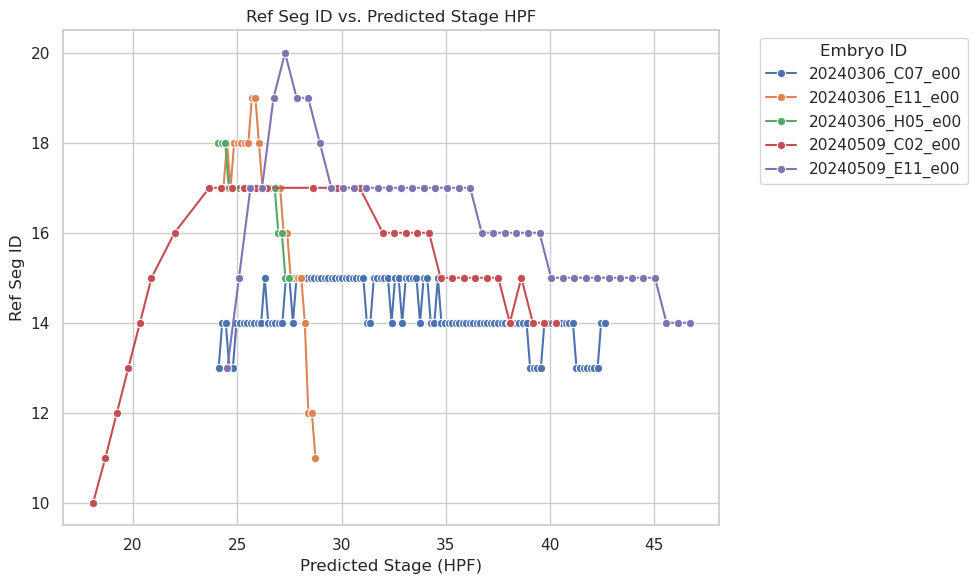

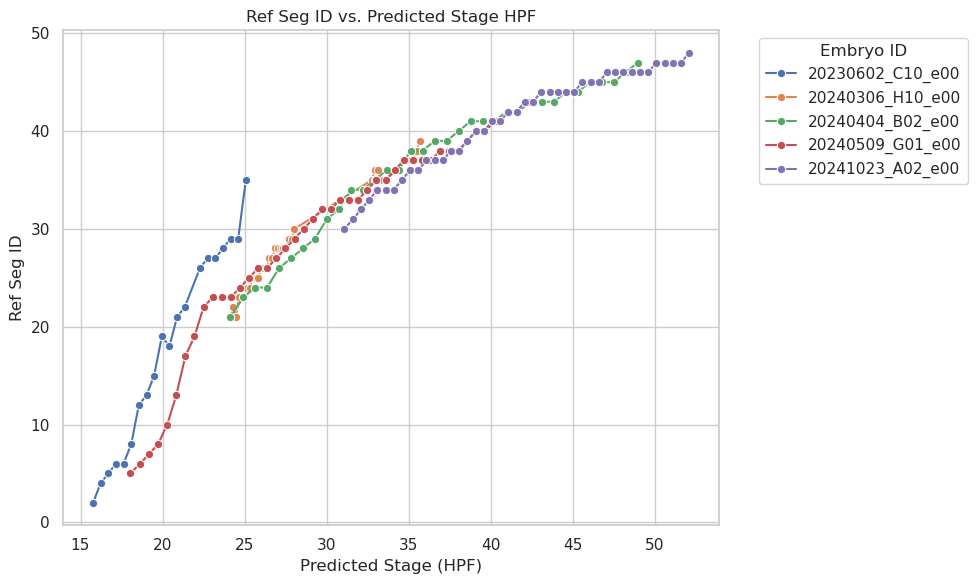

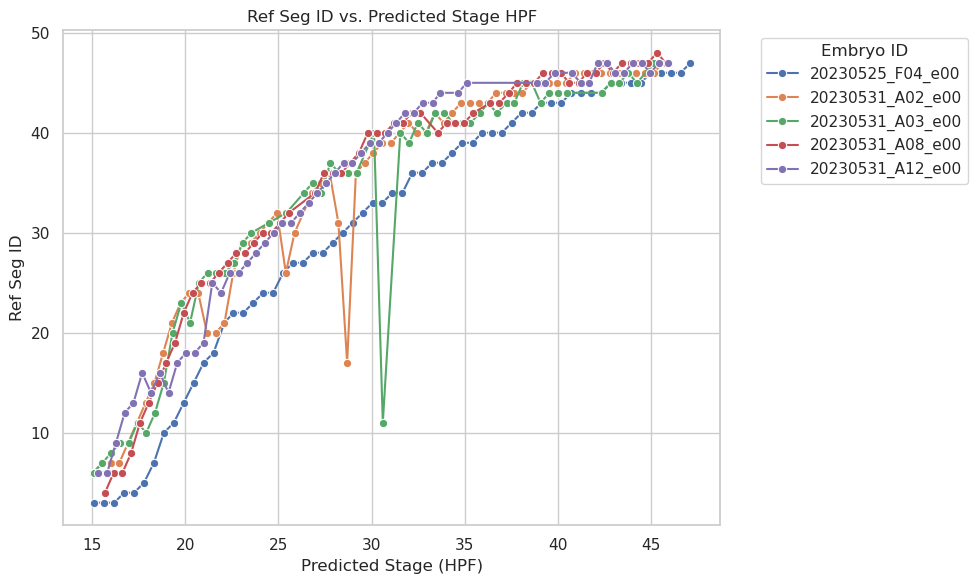

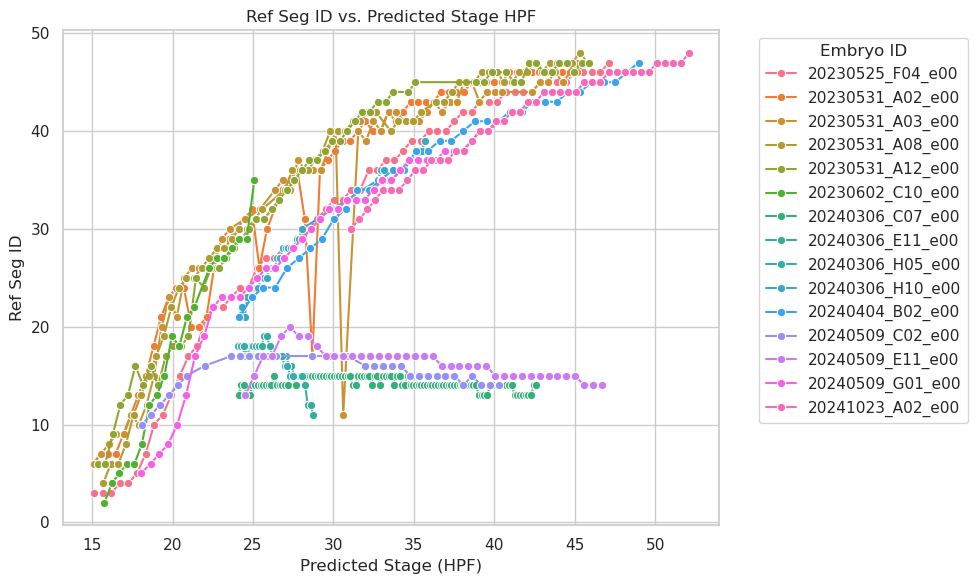

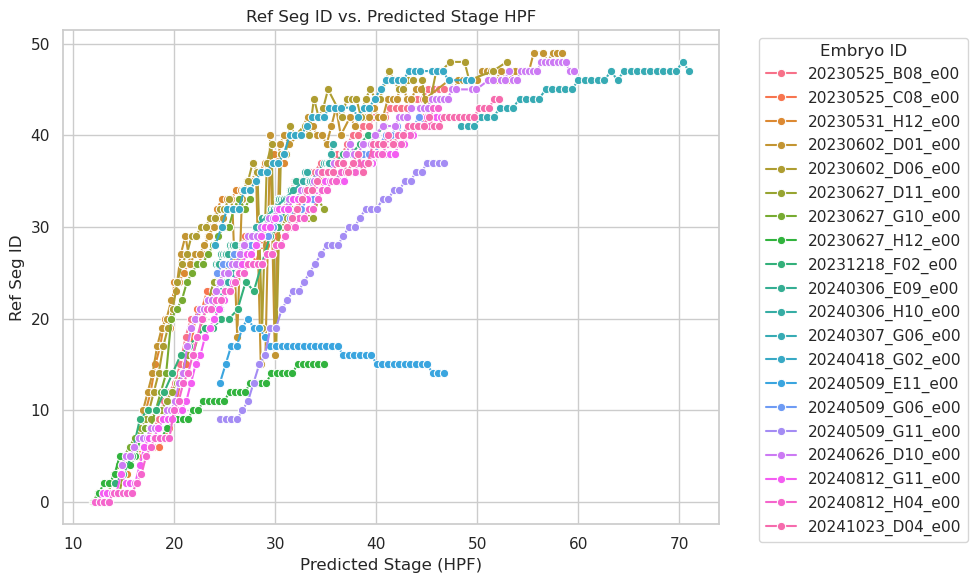

In [69]:
# Plot Slow Embryos
plot_stage_vs_ref_seg(
    df=df_augmented_projec_wt,
    embryo_ids=embryo_id_list_slow,
)

# Plot Fast Embryos
plot_stage_vs_ref_seg(
    df=df_augmented_projec_wt,
    embryo_ids=embryo_id_list_fast,
)

# Plot Average Embryos
plot_stage_vs_ref_seg(
    df=df_augmented_projec_wt,
    embryo_ids=embryo_id_list_avg,
)

embryo_id_list_combined = embryo_id_list_slow + embryo_id_list_fast + embryo_id_list_avg
# Or plot all together
plot_stage_vs_ref_seg(
    df=df_augmented_projec_wt,
    embryo_ids=embryo_id_list_combined,
)
plot_stage_vs_ref_seg(
    df=df_augmented_projec_wt,
    embryo_ids=embryo_id_list_spaced,
)

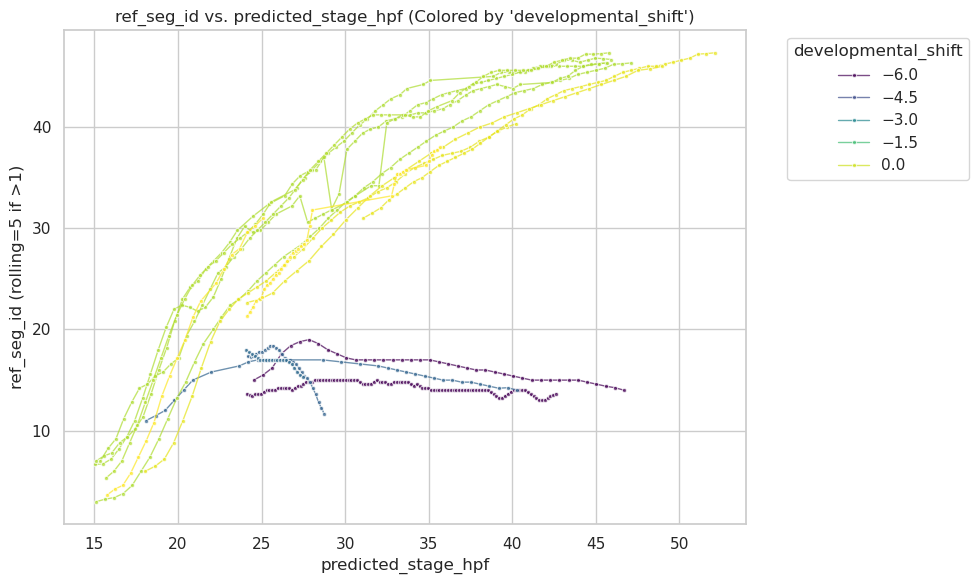

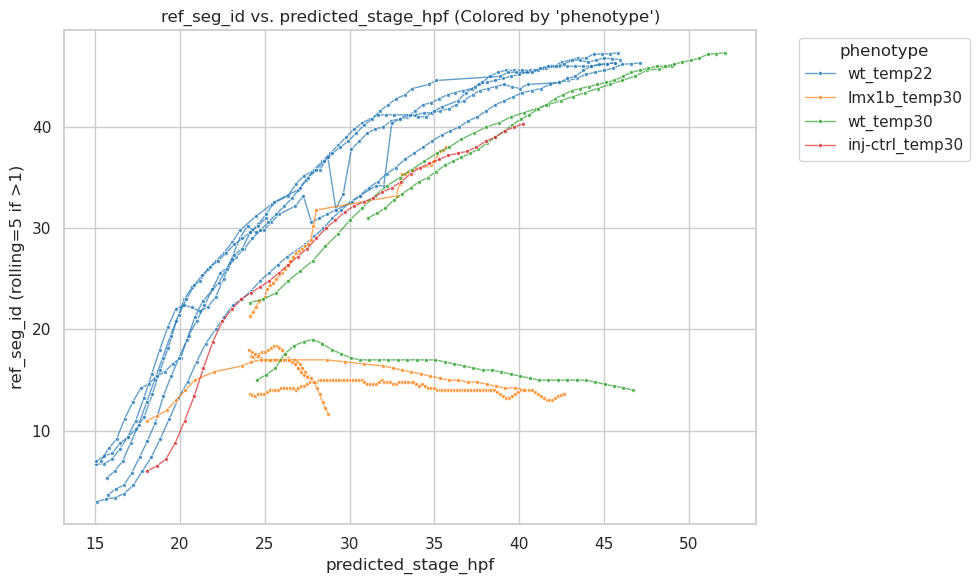

Done plotting!


In [116]:
import pandas as pd
import seaborn as sns

import seaborn as sns
from pandas.api.types import is_numeric_dtype
from typing import Union, List

def plot_stage_vs_ref_seg_hue_by(
    df_main: pd.DataFrame,
    df_info: pd.DataFrame,
    embryo_ids: Union[str, List[str]],
    color_col: str,
    x_col: str = "predicted_stage_hpf",
    y_col: str = "ref_seg_id",
    sort_by_x: bool = True,
    palette: str = None,
    save_path: str = None,
    rolling_window: int = 5,  # rolling average window, default=3
    line_alpha: float = 0.7,  # line transparency
    line_width: float = 1.0,  # line thickness
    marker_size: float = 3.0  # marker size
):
    """
    Plots one line per embryo_id (i.e., separate lines), coloring each line by
    the column 'color_col'. If 'color_col' is numeric, we use a continuous
    colormap so that each unique value is mapped in a gradient. If 'color_col'
    is categorical, we use a discrete palette, so lines sharing the same
    color_col value share the same color.

    The legend shows only the unique values of color_col (not every embryo).
    Thus, if there are 2 unique phenotype values, the legend has 2 color entries
    no matter how many embryo_ids you plot.

    If 'color_col' is missing from df_main, we merge from df_info on 'embryo_id'.
    For example, if df_main has your x/y data, while df_info (shift_df) has
    'phenotype' or 'developmental_shift'.

    Optionally applies a rolling average on the y-values to reduce noise.

    Parameters
    ----------
    df_main : pd.DataFrame
        Must have columns 'embryo_id', x_col, y_col, etc.
    df_info : pd.DataFrame
        Must have 'embryo_id' and color_col if it's missing from df_main.
    embryo_ids : str or list of str
        Which embryo IDs to plot lines for.
    color_col : str
        Column used to color lines (e.g. 'phenotype' or 'developmental_shift').
    x_col : str, optional
        X-axis variable. Default: "predicted_stage_hpf".
    y_col : str, optional
        Y-axis variable. Default: "ref_seg_id".
    sort_by_x : bool, optional
        Whether to sort each embryo's data by x_col before plotting. Default: True.
    palette : str, optional
        If None, we auto-pick "viridis" for numeric, "tab10" for categorical.
    save_path : str, optional
        If provided, saves the plot. Otherwise displays it.
    rolling_window : int, optional
        Window size for rolling average on y_col. If <= 1, no rolling average.
    line_alpha : float, optional
        Transparency for lines (0 to 1). Default=0.7.
    line_width : float, optional
        Line thickness. Default=1.0.
    marker_size : float, optional
        Marker size. Default=3.0.

    Returns
    -------
    None
    """

    # -------------------------------------------------------------------------
    # 1) Convert single embryo_id to list
    # -------------------------------------------------------------------------
    if isinstance(embryo_ids, str):
        embryo_ids = [embryo_ids]
    else:
        embryo_ids = [str(eid) for eid in embryo_ids]  # ensure they're strings

    # -------------------------------------------------------------------------
    # 2) Filter df_main to these embryo_ids
    # -------------------------------------------------------------------------
    if "embryo_id" not in df_main.columns:
        raise KeyError("df_main must have a 'embryo_id' column.")
    df_plot = df_main[df_main["embryo_id"].isin(embryo_ids)].copy()

    # -------------------------------------------------------------------------
    # 3) Merge color_col from df_info if missing in df_main
    # -------------------------------------------------------------------------
    if color_col not in df_plot.columns:
        if ("embryo_id" not in df_info.columns) or (color_col not in df_info.columns):
            raise KeyError(
                f"Column '{color_col}' is not found in df_main or df_info. Cannot color by it."
            )
        # Merge from df_info
        df_plot = pd.merge(
            df_plot,
            df_info[["embryo_id", color_col]].drop_duplicates("embryo_id"),
            on="embryo_id",
            how="left",
            suffixes=("", "_info")
        )

    if color_col not in df_plot.columns:
        raise ValueError(f"'{color_col}' is still missing after merge. Check your data.")

    # -------------------------------------------------------------------------
    # 4) Ensure x_col, y_col exist and drop rows missing those or color_col
    # -------------------------------------------------------------------------
    for col in [x_col, y_col, color_col]:
        if col not in df_plot.columns:
            raise KeyError(f"Column '{col}' not found. Check df_main/df_info.")

    df_plot.dropna(subset=[x_col, y_col, color_col], inplace=True)
    if df_plot.empty:
        raise ValueError(
            f"No rows remain after dropping NA in {x_col}, {y_col}, {color_col}."
        )

    # -------------------------------------------------------------------------
    # 5) Sort data by embryo_id, x_col if requested
    # -------------------------------------------------------------------------
    if sort_by_x:
        df_plot.sort_values(by=["embryo_id", x_col], inplace=True)

    # -------------------------------------------------------------------------
    # 6) Rolling average on the y_col if rolling_window > 1
    # -------------------------------------------------------------------------
    if rolling_window > 1:
        y_smooth_col = y_col + "_smooth"
        # Group by embryo_id, apply rolling average
        df_plot[y_smooth_col] = (
            df_plot.groupby("embryo_id")[y_col]
                   .transform(lambda s: s.rolling(rolling_window, center=True, min_periods=1).mean())
        )
        y_plot_col = y_smooth_col
    else:
        y_plot_col = y_col

    # -------------------------------------------------------------------------
    # 7) Setup a continuous vs. discrete palette
    # -------------------------------------------------------------------------
    is_numeric = is_numeric_dtype(df_plot[color_col])
    if palette is None:
        palette = "viridis" if is_numeric else "tab10"

    # -------------------------------------------------------------------------
    # 8) Create the plot
    # -------------------------------------------------------------------------
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    ax = sns.lineplot(
        data=df_plot,
        x=x_col,
        y=y_plot_col,
        hue=color_col,
        palette=palette,
        units="embryo_id",       # separate line for each embryo_id
        estimator=None,          # no averaging across lines
        marker="o",
        markersize=marker_size,
        linewidth=line_width,
        alpha=line_alpha
    )

    plt.xlabel(x_col)
    plt.ylabel(f"{y_col} (rolling={rolling_window} if >1)")
    plt.title(f"{y_col} vs. {x_col} (Colored by '{color_col}')")

    # -------------------------------------------------------------------------
    # 9) Legend formatting
    # -------------------------------------------------------------------------
    plt.legend(title=color_col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

    # -------------------------------------------------------------------------
    # 10) Save or show
    # -------------------------------------------------------------------------
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"Plot saved to '{save_path}'.")
    else:
        plt.show()
###############################################################################
# EXAMPLE USAGE

# Suppose:
#   df_augmented_projec_wt => x/y data: embryo_id, predicted_stage_hpf, ref_seg_id
#   shift_df => info data: embryo_id, phenotype (categorical), developmental_shift (numeric)
#   embryo_id_list => list of embryo IDs to plot

# 1) Plot color by numeric 'developmental_shift'
#    => Each embryo is a separate line, but lines with lower/higher shift
#       values appear on a continuous colormap.
plot_stage_vs_ref_seg_hue_by(
    df_main=df_augmented_projec_wt,
    df_info=shift_df,
    embryo_ids=embryo_id_list_combined,
    color_col="developmental_shift",  # numeric => continuous colormap
    x_col="predicted_stage_hpf",
    y_col="ref_seg_id",
    palette=None,  # auto-select 'viridis'
    # save_path="colored_by_devshift.png"
)

# 2) Plot color by categorical 'phenotype'
#    => If there are only 2 phenotype values, you'll see exactly 2 colors,
#       no matter how many embryo_ids are plotted.
plot_stage_vs_ref_seg_hue_by(
    df_main=df_augmented_projec_wt,
    df_info=shift_df,
    embryo_ids=embryo_id_list_combined,
    color_col="phenotype",   # categorical => discrete palette
    x_col="predicted_stage_hpf",
    y_col="ref_seg_id",
    palette=None,  # auto-select 'tab10'
    # save_path="colored_by_phenotype.png"
)

print("Done plotting!")

In [113]:
shift_df["phenotype"].unique()

array(['wt_temp22', 'wt_temp30', 'lmx1b_temp30', 'inj-ctrl_temp30',
       'wt_temp29'], dtype=object)

167


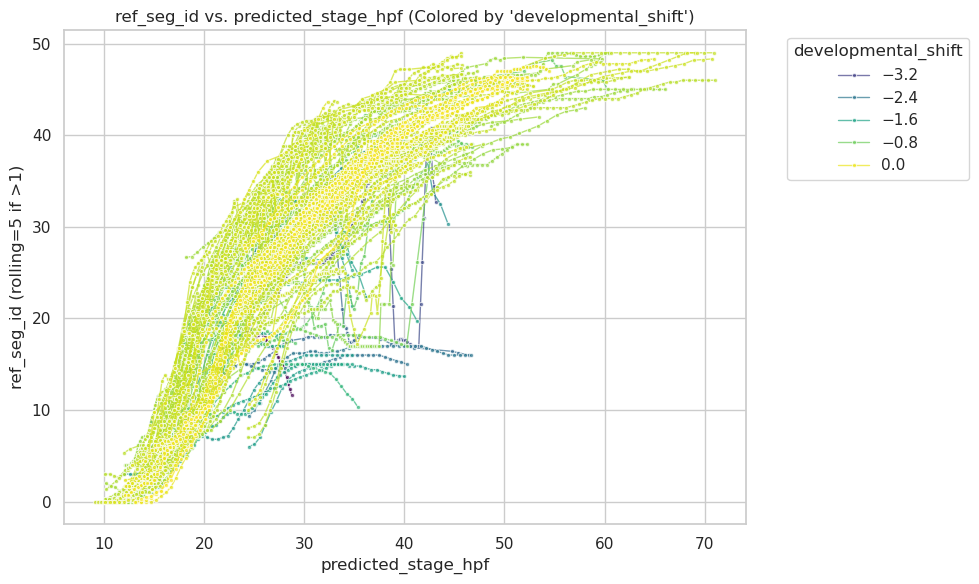

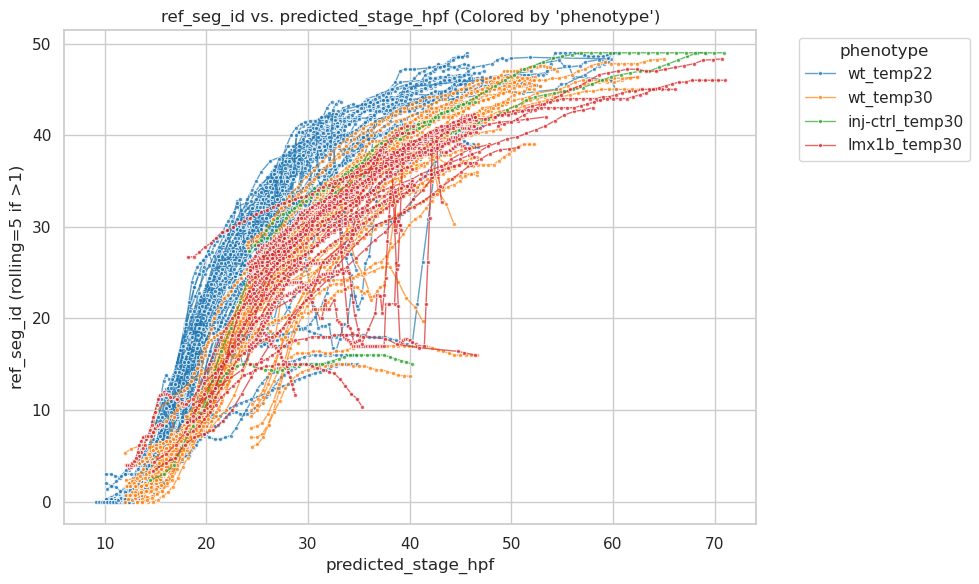

In [117]:
lmx1b_wt_embryo_ids = shift_df[shift_df["phenotype"].isin(["wt_temp30","lmx1b_temp30","wt_temp22","inj-ctrl_temp30"])].sample(frac=.2)["embryo_id"].to_list()
print(len(lmx1b_wt_embryo_ids))

plot_stage_vs_ref_seg_hue_by(
    df_main=df_augmented_projec_wt,
    df_info=shift_df,
    embryo_ids=lmx1b_wt_embryo_ids,
    color_col="developmental_shift",  # numeric => continuous colormap
    x_col="predicted_stage_hpf",
    y_col="ref_seg_id",
    palette=None,  # auto-select 'viridis'
    # save_path="colored_by_devshift.png"
)

# 2) Plot color by categorical 'phenotype'
#    => If there are only 2 phenotype values, you'll see exactly 2 colors,
#       no matter how many embryo_ids are plotted.
plot_stage_vs_ref_seg_hue_by(
    df_main=df_augmented_projec_wt,
    df_info=shift_df,
    embryo_ids=lmx1b_wt_embryo_ids,
    color_col="phenotype",   # categorical => discrete palette
    x_col="predicted_stage_hpf",
    y_col="ref_seg_id",
    palette=None,  # auto-select 'tab10'
    # save_path="colored_by_phenotype.png"
)

In [ ]:
shift_df[shift_df["phenotype"].isin(["wt_temp30","lmx1b_temp30","wt_temp22"])]["embryo_id"].to_list()

/tmp/9345736.1.trapnell-login.q/ipykernel_2200385/1166704668.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  embryo_list = shift_df.sample(frac=1)[shift_df["phenotype"].isin(["lmx1b_temp30"])]["embryo_id"].to_list()


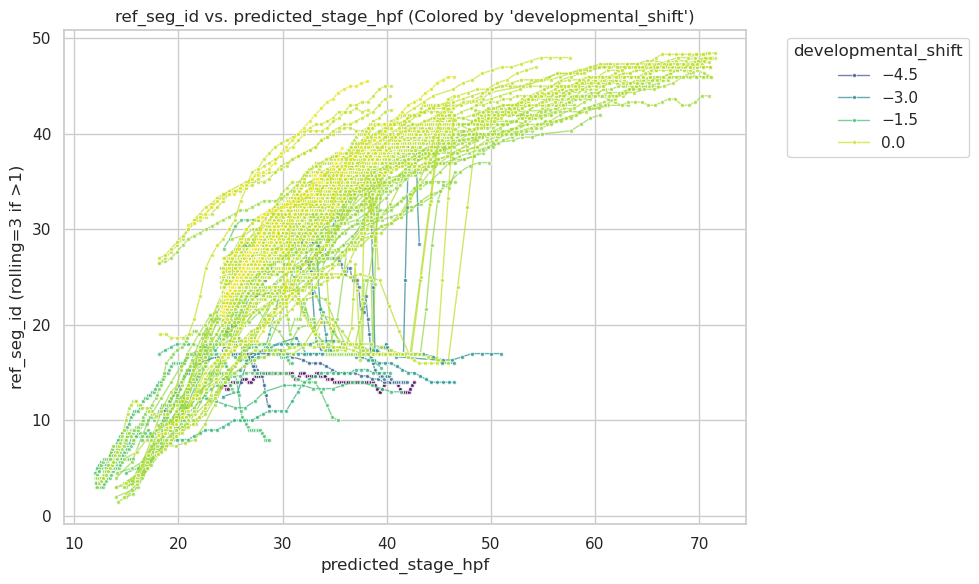

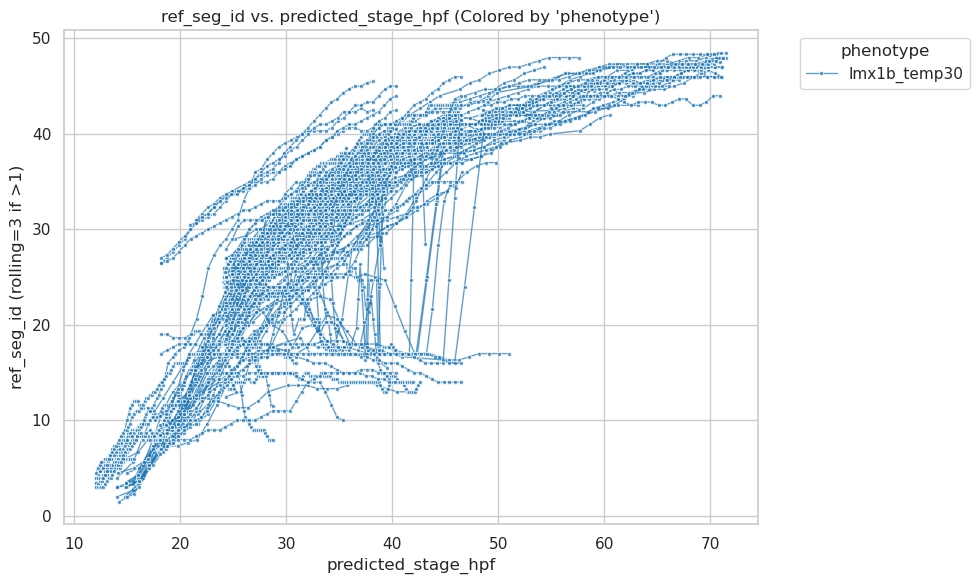

/tmp/9345736.1.trapnell-login.q/ipykernel_2200385/1166704668.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  embryo_list = shift_df.sample(frac=1)[shift_df["phenotype"].isin(["wt_temp30"])]["embryo_id"].to_list()


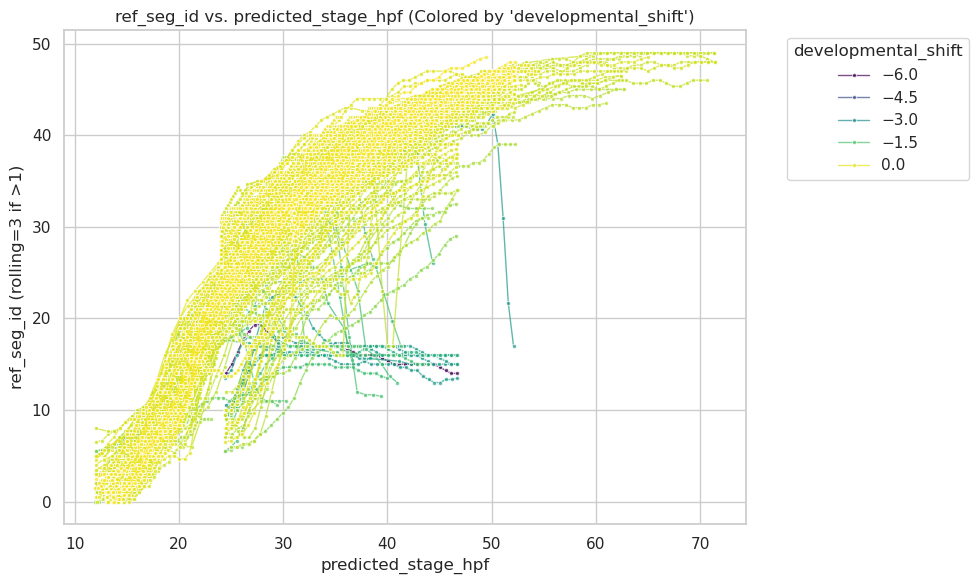

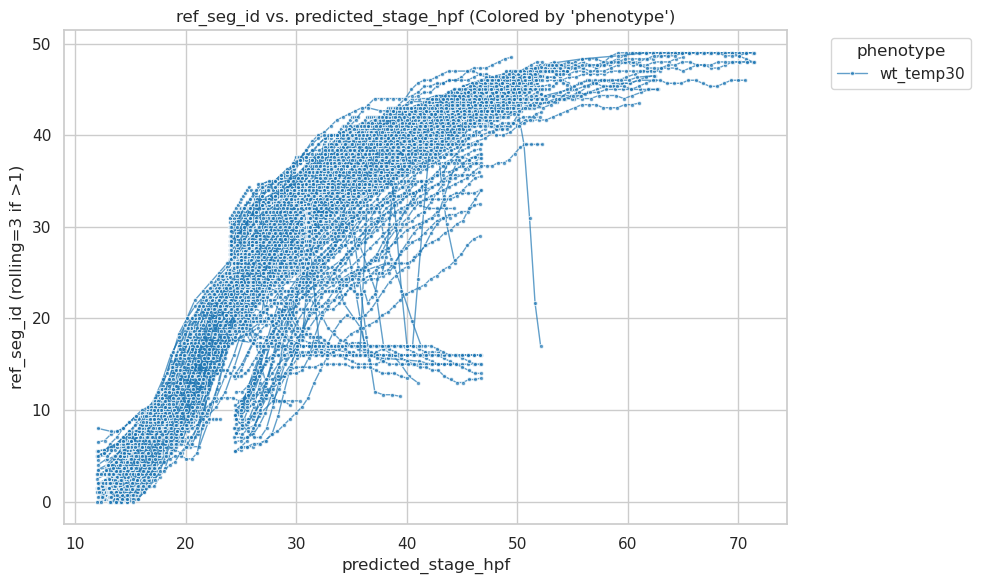

In [107]:
embryo_list = shift_df.sample(frac=1)[shift_df["phenotype"].isin(["lmx1b_temp30"])]["embryo_id"].to_list()

plot_stage_vs_ref_seg_hue_by(
    df_main=df_augmented_projec_wt,
    df_info=shift_df,
    embryo_ids=embryo_list,
    color_col="developmental_shift",  # numeric => continuous colormap
    x_col="predicted_stage_hpf",
    y_col="ref_seg_id",
    palette=None,  # auto-select 'viridis'
    # save_path="colored_by_devshift.png"
)

# 2) Plot color by categorical 'phenotype'
#    => If there are only 2 phenotype values, you'll see exactly 2 colors,
#       no matter how many embryo_ids are plotted.
plot_stage_vs_ref_seg_hue_by(
    df_main=df_augmented_projec_wt,
    df_info=shift_df,
    embryo_ids=embryo_list,
    color_col="phenotype",   # categorical => discrete palette
    x_col="predicted_stage_hpf",
    y_col="ref_seg_id",
    palette=None,  # auto-select 'tab10'
    # save_path="colored_by_phenotype.png"
)

embryo_list = shift_df.sample(frac=1)[shift_df["phenotype"].isin(["wt_temp30"])]["embryo_id"].to_list()

plot_stage_vs_ref_seg_hue_by(
    df_main=df_augmented_projec_wt,
    df_info=shift_df,
    embryo_ids=embryo_list,
    color_col="developmental_shift",  # numeric => continuous colormap
    x_col="predicted_stage_hpf",
    y_col="ref_seg_id",
    palette=None,  # auto-select 'viridis'
    # save_path="colored_by_devshift.png"
)

# 2) Plot color by categorical 'phenotype'
#    => If there are only 2 phenotype values, you'll see exactly 2 colors,
#       no matter how many embryo_ids are plotted.
plot_stage_vs_ref_seg_hue_by(
    df_main=df_augmented_projec_wt,
    df_info=shift_df,
    embryo_ids=embryo_list,
    color_col="phenotype",   # categorical => discrete palette
    x_col="predicted_stage_hpf",
    y_col="ref_seg_id",
    palette=None,  # auto-select 'tab10'
    # save_path="colored_by_phenotype.png"
)

/tmp/9345736.1.trapnell-login.q/ipykernel_2200385/2476636179.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  embryo_list = shift_df.sample(frac=1)[shift_df["phenotype"].isin(["wt_temp22"])]["embryo_id"].to_list()


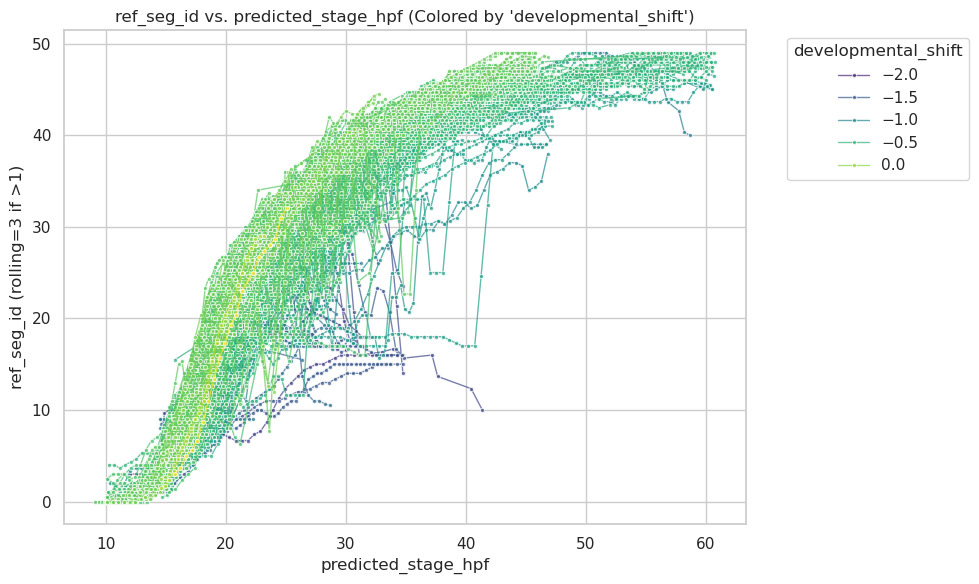

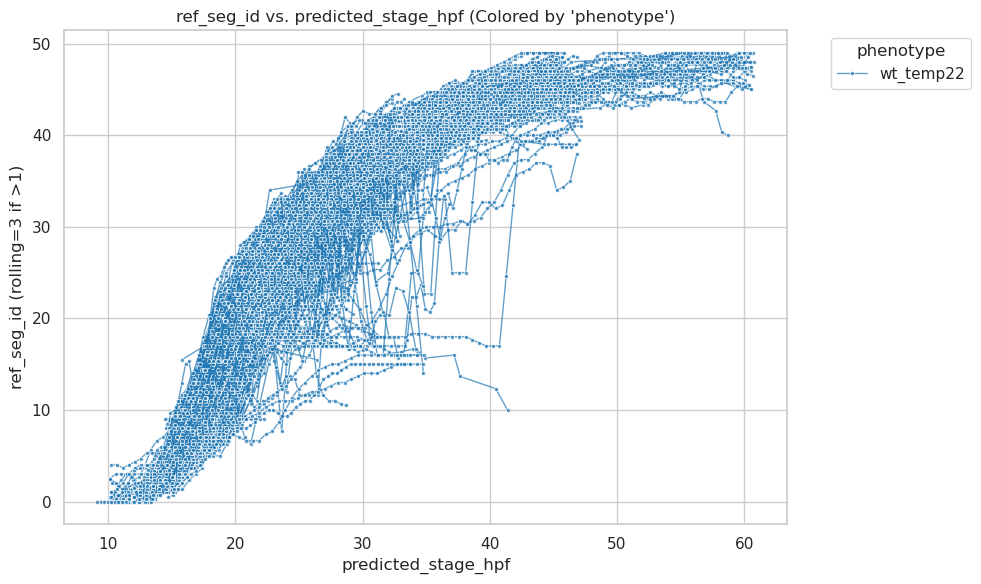

In [108]:

embryo_list = shift_df.sample(frac=1)[shift_df["phenotype"].isin(["wt_temp22"])]["embryo_id"].to_list()

plot_stage_vs_ref_seg_hue_by(
    df_main=df_augmented_projec_wt,
    df_info=shift_df,
    embryo_ids=embryo_list,
    color_col="developmental_shift",  # numeric => continuous colormap
    x_col="predicted_stage_hpf",
    y_col="ref_seg_id",
    palette=None,  # auto-select 'viridis'
    # save_path="colored_by_devshift.png"
)

# 2) Plot color by categorical 'phenotype'
#    => If there are only 2 phenotype values, you'll see exactly 2 colors,
#       no matter how many embryo_ids are plotted.
plot_stage_vs_ref_seg_hue_by(
    df_main=df_augmented_projec_wt,
    df_info=shift_df,
    embryo_ids=embryo_list,
    color_col="phenotype",   # categorical => discrete palette
    x_col="predicted_stage_hpf",
    y_col="ref_seg_id",
    palette=None,  # auto-select 'tab10'
    # save_path="colored_by_phenotype.png"
)

In [99]:

import seaborn as sns

def plot_developmental_shifts(
    shift_df, 
    color_by="phenotype", 
    bins=20, 
    normalize=False
):
    """
    Given a DataFrame with a 'developmental_shift' column and a grouping column (color_by),
    plot a histogram of the developmental shifts, coloring/hue by color_by using seaborn,
    with side-by-side bars (no overlap).

    Parameters
    ----------
    shift_df : pd.DataFrame
        Must have columns ['developmental_shift', color_by].
    color_by : str
        Column name to color by in the histogram.
    bins : int
        Number of bins in the histogram.
    normalize : bool
        If True, the histogram is normalized so that each hue category sums to 1 (per bin),
        with side-by-side bars. If False, it plots raw counts, also side-by-side.
    """
    plt.figure(figsize=(8, 6))

    if normalize:
        # Plot proportion (0 to 1) per hue category, with side-by-side bars
        sns.histplot(
            data=shift_df, 
            x="developmental_shift", 
            hue=color_by, 
            bins=bins, 
            kde=False,
            stat="probability",   # Normalized histogram
            common_norm=False,    # Each hue level sums to 1 on its own
            multiple="dodge",     # Place bars side by side
            shrink=0.8            # Adjust bar width for spacing
        )
        plt.ylabel("Proportion")
    else:
        # Plot raw counts, side by side
        sns.histplot(
            data=shift_df, 
            x="developmental_shift", 
            hue=color_by, 
            bins=bins, 
            kde=False,
            stat="count",
            multiple="dodge",  # Side by side
            shrink=0.8         # Slightly narrower bars for spacing
        )
        plt.ylabel("Count")

    plt.title("Developmental Shift Distribution")
    plt.xlabel("Developmental Shift (ref_morph_velocity - embryo_morph_velocity)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [97]:
shift_df[shift_df["column_name"].isin(["wt_temp22"])]

KeyError: 'column_name'

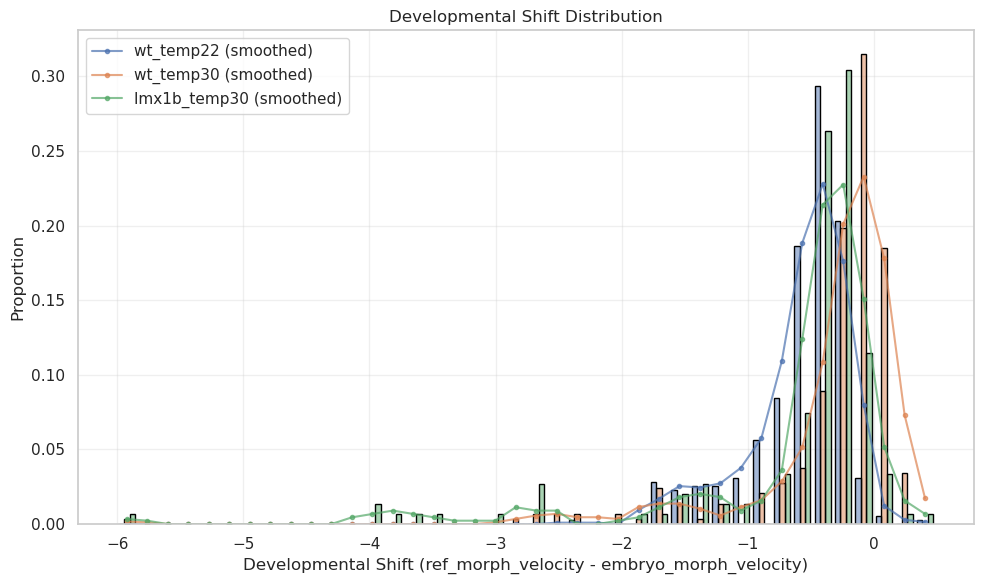

In [120]:



# Now plot them
plot_developmental_shifts(
    shift_df=shift_df[shift_df["phenotype"].isin(["wt_temp30","wt_temp22","lmx1b_temp30"])],
    color_by="phenotype",
    bins=40,
    normalize = True  
)

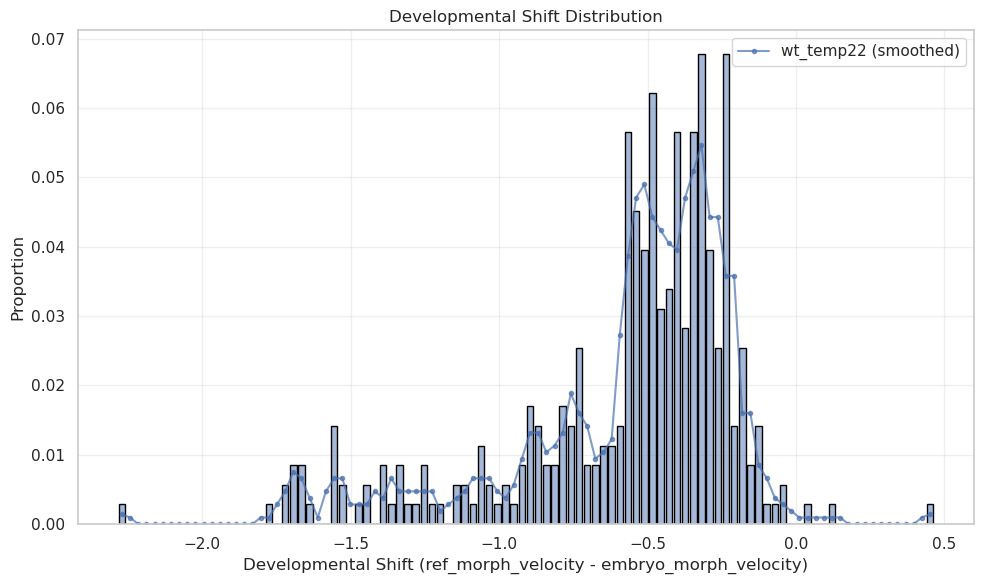

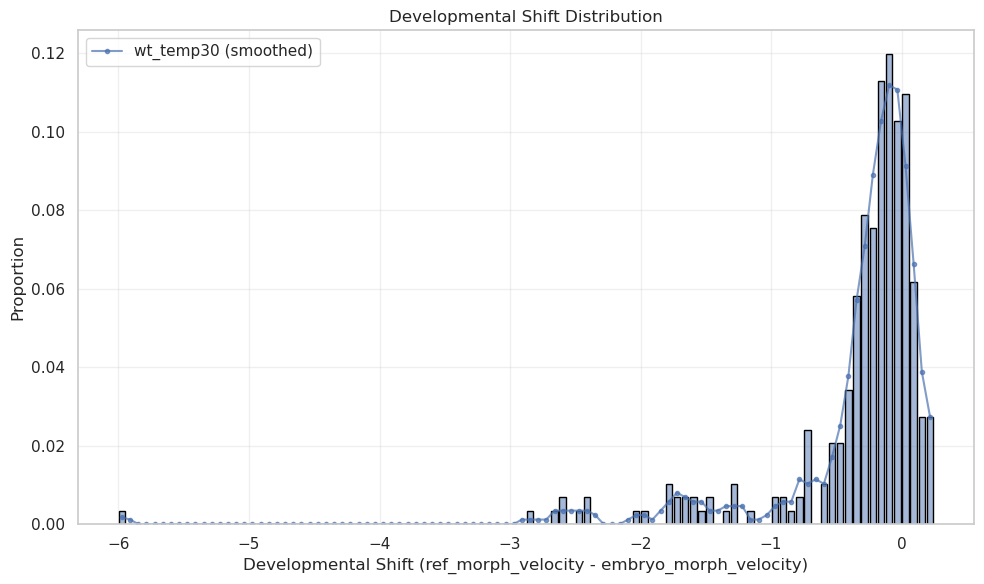

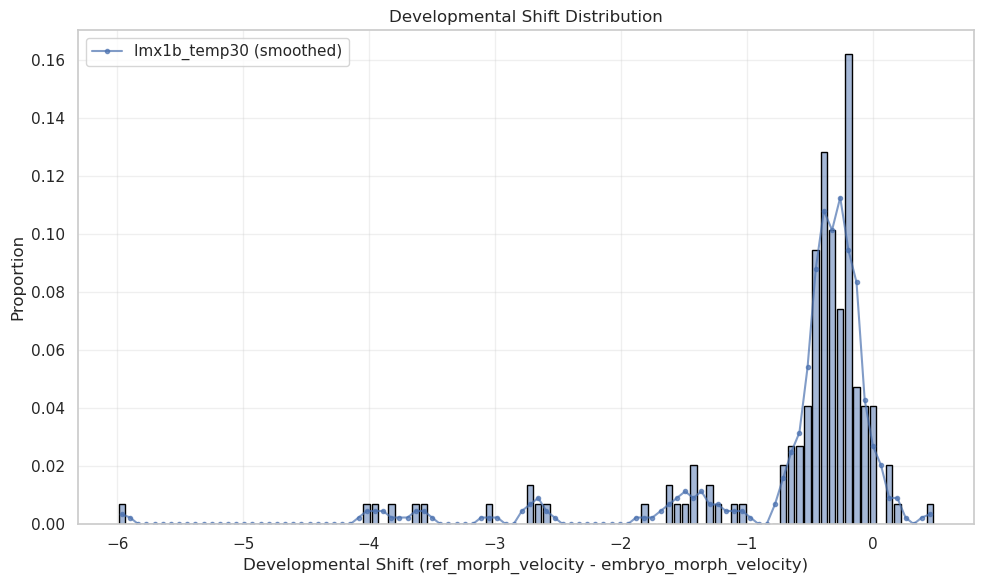

In [125]:

# Now plot them
plot_developmental_shifts(
    shift_df=shift_df[shift_df["phenotype"].isin(["wt_temp22"])],
    color_by="phenotype",
    bins=100,
    normalize = True  
)


# Now plot them
plot_developmental_shifts(
    shift_df=shift_df[shift_df["phenotype"].isin(["wt_temp30"])],
    color_by="phenotype",
    bins=100,
    normalize = True  
)


# Now plot them
plot_developmental_shifts(
    shift_df=shift_df[shift_df["phenotype"].isin(["lmx1b_temp30"])],
    color_by="phenotype",
    bins=100,
    normalize = True  
)

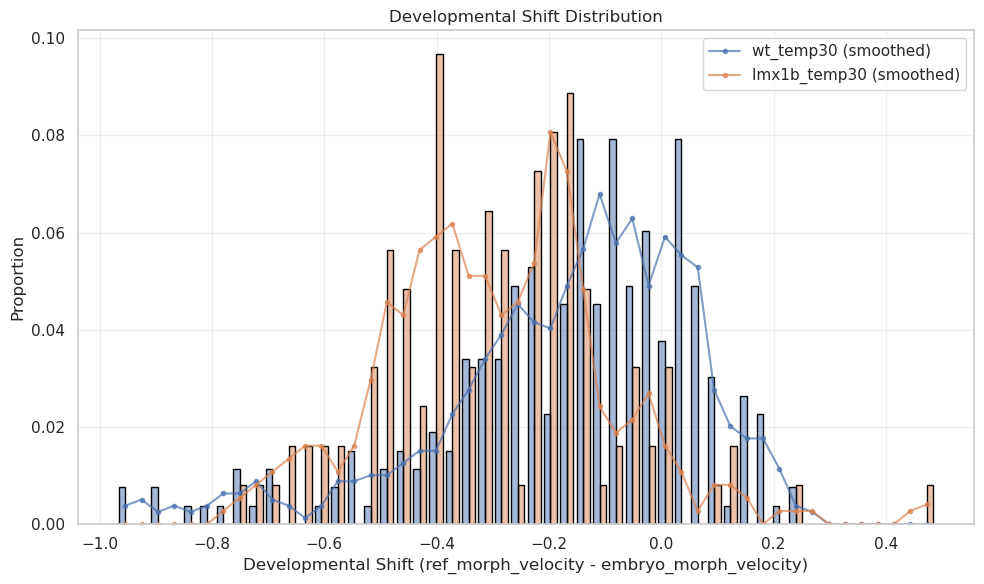

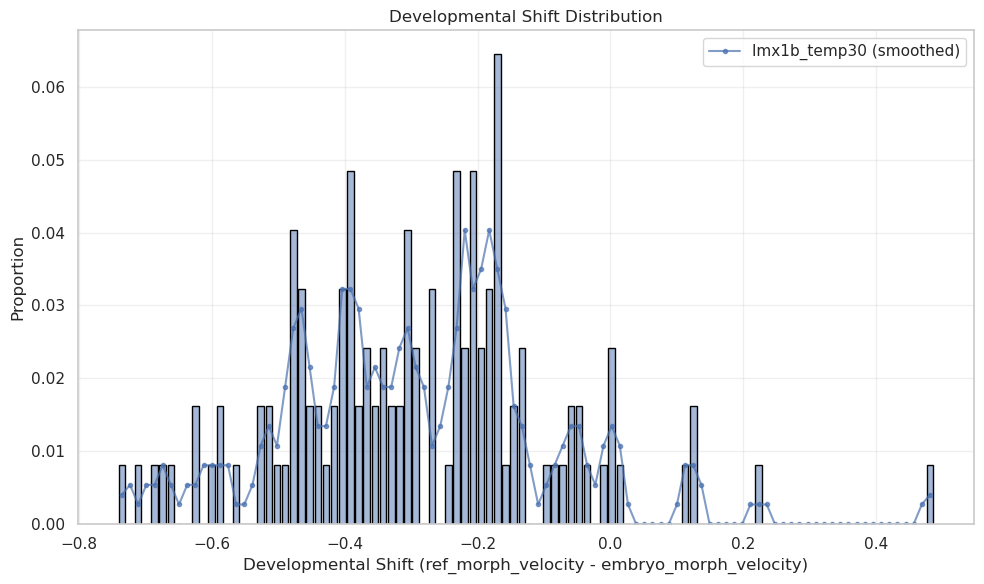

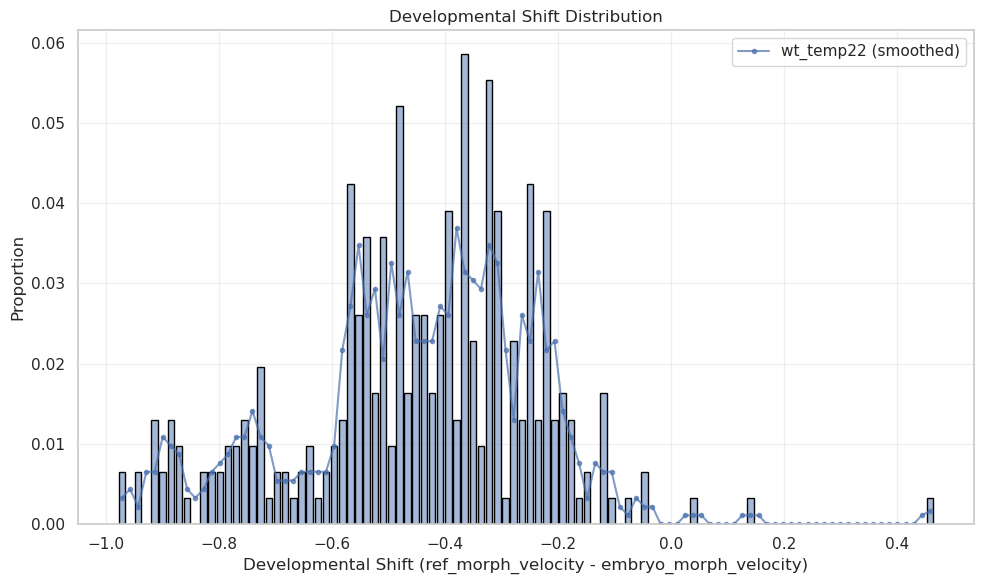

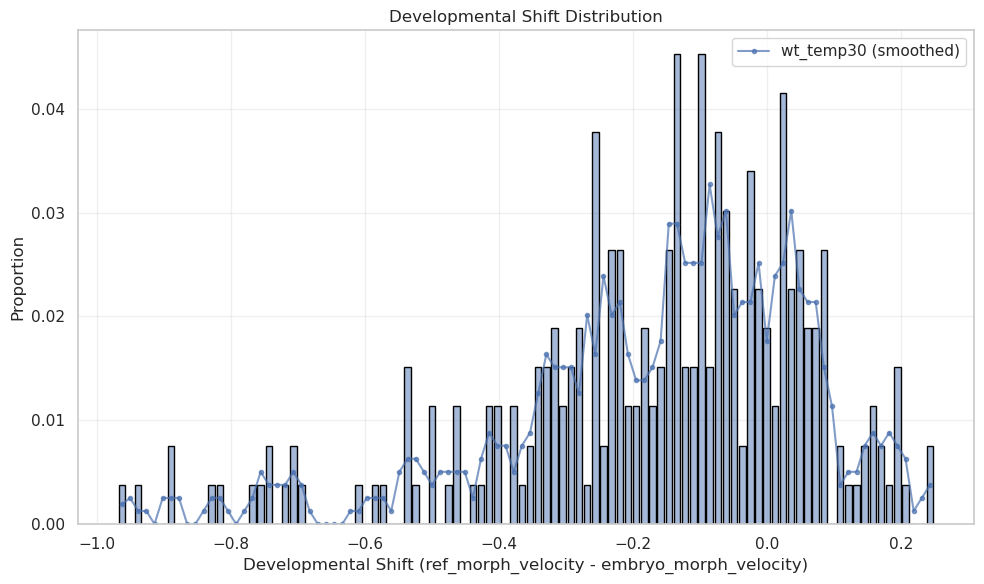

In [131]:
# Correctly subset shift_df to include only rows where |developmental_shift| < 1
shift_df_zoom = shift_df[shift_df["developmental_shift"].abs() <= 1]

# Now plot them
plot_developmental_shifts(
    shift_df=shift_df_zoom[shift_df_zoom["phenotype"].isin(["wt_temp30", "lmx1b_temp30"])],
    color_by="phenotype",
    bins=50,
    normalize=True  
)

plot_developmental_shifts(
    shift_df=shift_df_zoom[shift_df_zoom["phenotype"].isin(["lmx1b_temp30"])],
    color_by="phenotype",
    bins=100,
    normalize = True  
)



# Plot for phenotype "wt_temp22"
plot_developmental_shifts(
    shift_df=shift_df_zoom[shift_df_zoom["phenotype"].isin(["wt_temp22"])],
    color_by="phenotype",
    bins=100,
    normalize=True  
)

# Plot for phenotype "wt_temp22"
plot_developmental_shifts(
    shift_df=shift_df_zoom[shift_df_zoom["phenotype"].isin(["wt_temp30"])],
    color_by="phenotype",
    bins=100,
    normalize=True  
)

=== WT_TEMP30 ===
======= GMM Fit Comparison =======
Data points: 265
Single Gaussian:
  BIC = -13.56, AIC = -20.72
Two Gaussians:
  BIC = -46.24, AIC = -64.14
By BIC => 2-component GMM fits better.
By AIC => 2-component GMM fits better.



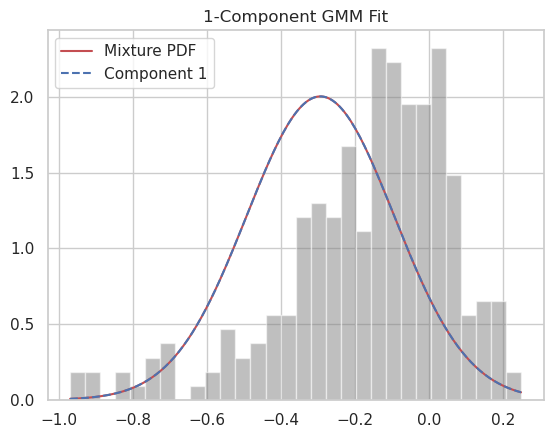

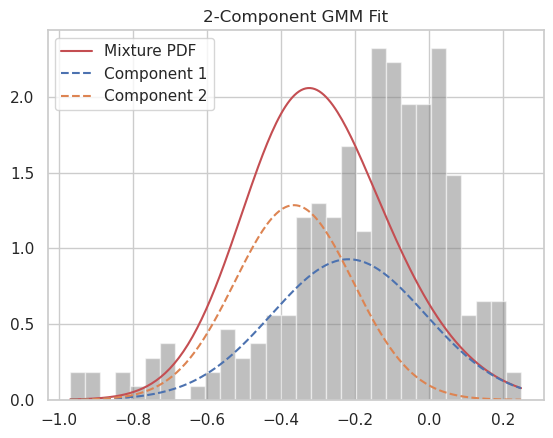

=== LMX1B_TEMP30 ===
======= GMM Fit Comparison =======
Data points: 124
Single Gaussian:
  BIC = -38.58, AIC = -44.22
Two Gaussians:
  BIC = -25.91, AIC = -40.01
By BIC => 1-component GMM fits better.
By AIC => 1-component GMM fits better.



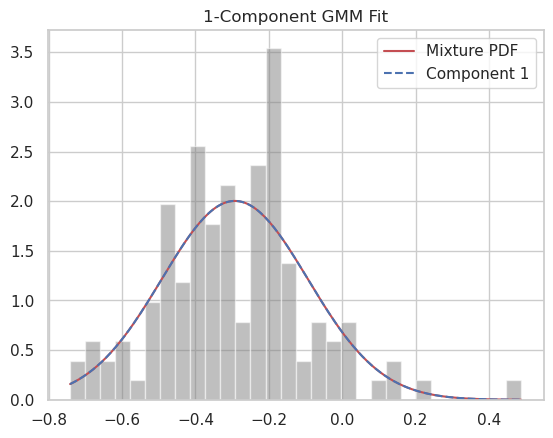

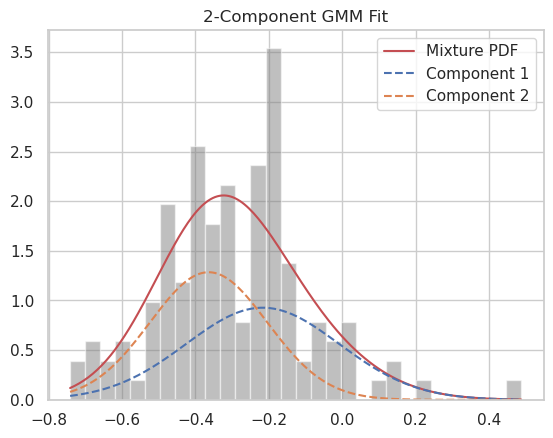

In [139]:

from sklearn.mixture import GaussianMixture

def compare_gaussian_models(data, random_state=42):
    """
    Compare the fit of a 1-component vs. 2-component Gaussian Mixture Model (GMM)
    on the given 1D numeric array `data`.
    
    Prints out BIC and AIC for both models and indicates which model is better
    according to each criterion.

    Parameters
    ----------
    data : array-like
        A 1D array of numeric values (e.g. your 'developmental_shift' column).
    random_state : int
        Seed for reproducibility in the GMM fitting.

    Returns
    -------
    None (prints results).
    """
    data_ = np.array(data, dtype=float)
    data_ = data_[~np.isnan(data_)]  # drop NaNs
    if data_.size == 0:
        print("No valid data points to fit.")
        return
    
    # Reshape to 2D for sklearn
    data_ = data_.reshape(-1, 1)
    
    # 1-Component GMM
    gmm1 = GaussianMixture(n_components=1, random_state=random_state)
    gmm1.fit(data_)
    bic1 = gmm1.bic(data_)
    aic1 = gmm1.aic(data_)

    # 2-Component GMM
    gmm2 = GaussianMixture(n_components=2, random_state=random_state)
    gmm2.fit(data_)
    bic2 = gmm2.bic(data_)
    aic2 = gmm2.aic(data_)

    print("======= GMM Fit Comparison =======")
    print(f"Data points: {data_.size}")
    print("Single Gaussian:")
    print(f"  BIC = {bic1:.2f}, AIC = {aic1:.2f}")
    print("Two Gaussians:")
    print(f"  BIC = {bic2:.2f}, AIC = {aic2:.2f}")

    # Compare BIC
    if bic2 < bic1:
        print("By BIC => 2-component GMM fits better.")
    elif np.isclose(bic2, bic1, atol=1e-2):
        print("By BIC => The fits are essentially the same.")
    else:
        print("By BIC => 1-component GMM fits better.")
    
    # Compare AIC
    if aic2 < aic1:
        print("By AIC => 2-component GMM fits better.")
    elif np.isclose(aic2, aic1, atol=1e-2):
        print("By AIC => The fits are essentially the same.")
    else:
        print("By AIC => 1-component GMM fits better.")
    print("==================================\n")

# SHIFT_DF_ZOOM is your DataFrame, 
# containing the 'developmental_shift' column, 
# filtered so that abs(shift_df["developmental_shift"]) < 1

# Let's compare 'wt_temp30' vs. 'lmx1b_temp30' distributions

# 1) Subset for wt_temp30
data_wt = shift_df_zoom.loc[shift_df_zoom["phenotype"] == "wt_temp30", "developmental_shift"]
print("=== WT_TEMP30 ===")
compare_gaussian_models(data_wt)


# Fit 1-component GMM to wt_temp30 data
gmm1 = GaussianMixture(n_components=1, random_state=42).fit(data_lmx.dropna().values.reshape(-1,1))

plot_gmm_fit(data_wt, gmm1, bins=30)


# Fit 1-component GMM to wt_temp30 data
gmm2 = GaussianMixture(n_components=2, random_state=42).fit(data_lmx.dropna().values.reshape(-1,1))

plot_gmm_fit(data_wt, gmm2, bins=30)




# 2) Subset for lmx1b_temp30
data_lmx = shift_df_zoom.loc[shift_df_zoom["phenotype"] == "lmx1b_temp30", "developmental_shift"]
print("=== LMX1B_TEMP30 ===")
compare_gaussian_models(data_lmx)

# Fit 1-component GMM to lmx1b_temp30 data
gmm1 = GaussianMixture(n_components=1, random_state=42).fit(data_lmx.dropna().values.reshape(-1,1))

plot_gmm_fit(data_lmx, gmm1, bins=30)
# Fit 2-component GMM to lmx1b_temp30 data
gmm2 = GaussianMixture(n_components=2, random_state=42).fit(data_lmx.dropna().values.reshape(-1,1))

plot_gmm_fit(data_lmx, gmm2, bins=30)





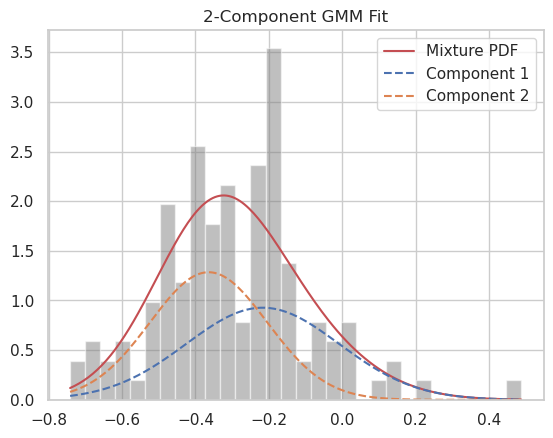

In [138]:
import numpy as np
import matplotlib.pyplot as plt


def plot_gmm_fit(data, gmm, bins=30):
    data_clean = np.array(data.dropna())  # drop NaNs
    data_clean = data_clean.reshape(-1,1)
    x = np.linspace(data_clean.min(), data_clean.max(), 200).reshape(-1,1)

    # Overall mixture PDF
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)

    plt.hist(data_clean, bins=bins, density=True, alpha=0.5, color='gray')
    plt.plot(x, pdf, 'r-', label='Mixture PDF')
    
    # Plot each component
    means = gmm.means_.ravel()
    stds = np.sqrt(gmm.covariances_).ravel()
    weights = gmm.weights_.ravel()
    
    for i in range(gmm.n_components):
        comp_pdf = (weights[i] *
                    (1.0 / (stds[i]*np.sqrt(2*np.pi))) *
                    np.exp(-0.5 * ((x - means[i]) / stds[i])**2))
        plt.plot(x, comp_pdf, '--', label=f'Component {i+1}')
    
    plt.legend()
    plt.title(f"{gmm.n_components}-Component GMM Fit")
    plt.show()

# Fit 2-component GMM to lmx1b_temp30 data
gmm2 = GaussianMixture(n_components=2, random_state=42).fit(data_lmx.dropna().values.reshape(-1,1))

plot_gmm_fit(data_lmx, gmm2, bins=30)

wt_temp22


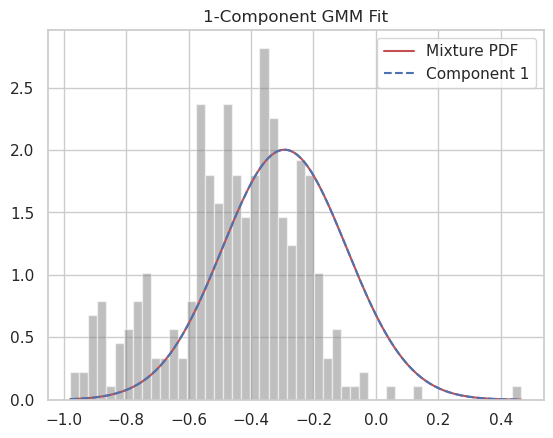

Means: [-0.21688226 -0.36414709]
Stds : [0.20855698 0.15996072]
Weights: [0.48489681 0.51510319]


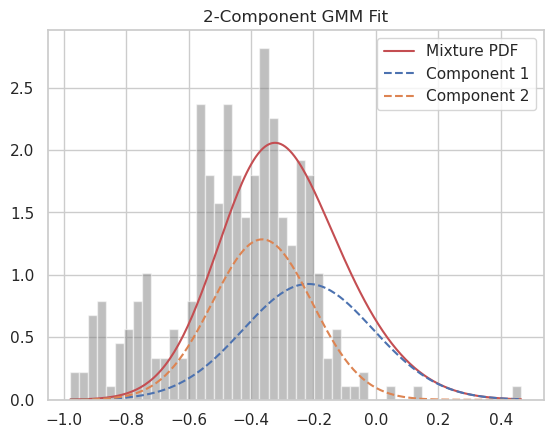

Dip statistic = 0.0000, p-value = 1.0000
wt_temp30


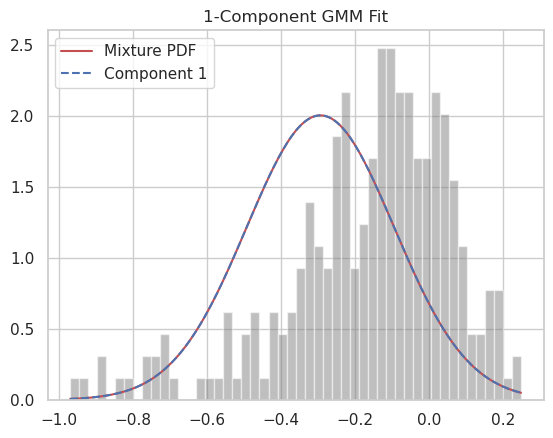

Means: [-0.21688226 -0.36414709]
Stds : [0.20855698 0.15996072]
Weights: [0.48489681 0.51510319]


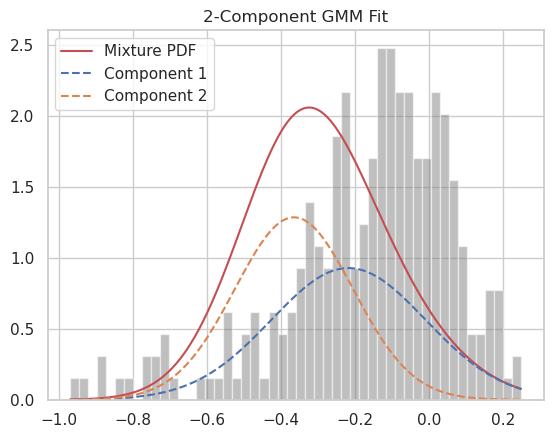

Dip statistic = 0.0000, p-value = 1.0000
lmx1b_temp30


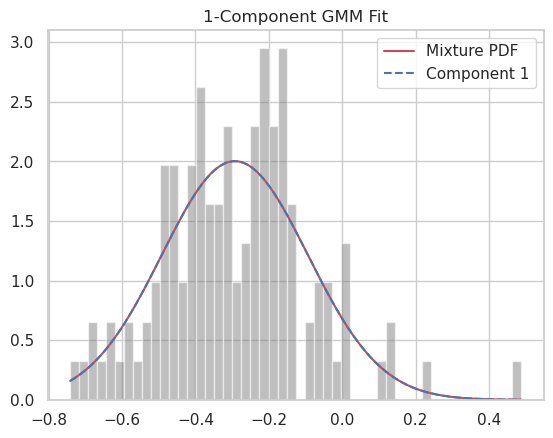

Means: [-0.21688226 -0.36414709]
Stds : [0.20855698 0.15996072]
Weights: [0.48489681 0.51510319]


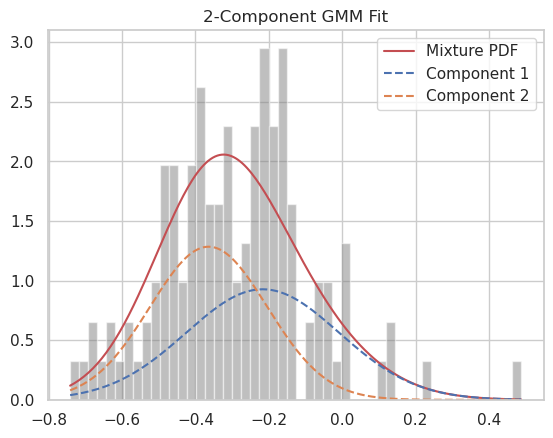

Dip statistic = 0.0000, p-value = 1.0000
inj-ctrl_temp30


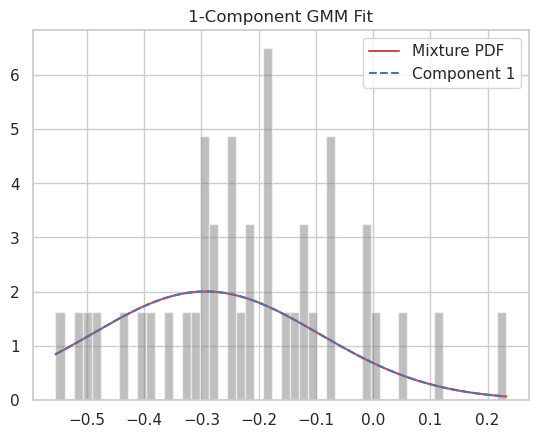

Means: [-0.21688226 -0.36414709]
Stds : [0.20855698 0.15996072]
Weights: [0.48489681 0.51510319]


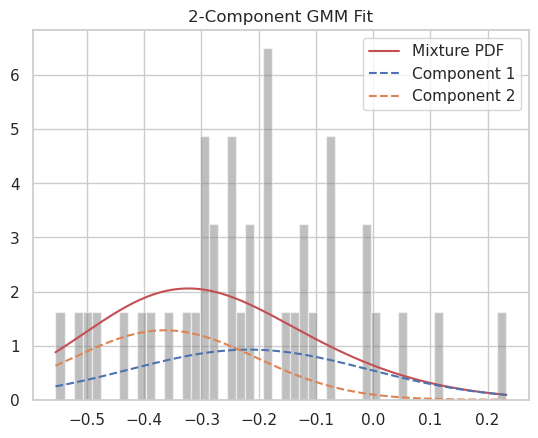

Dip statistic = 0.0000, p-value = 1.0000
wt_temp29


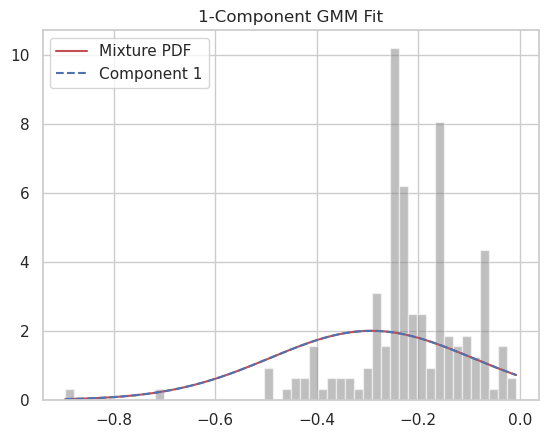

Means: [-0.21688226 -0.36414709]
Stds : [0.20855698 0.15996072]
Weights: [0.48489681 0.51510319]


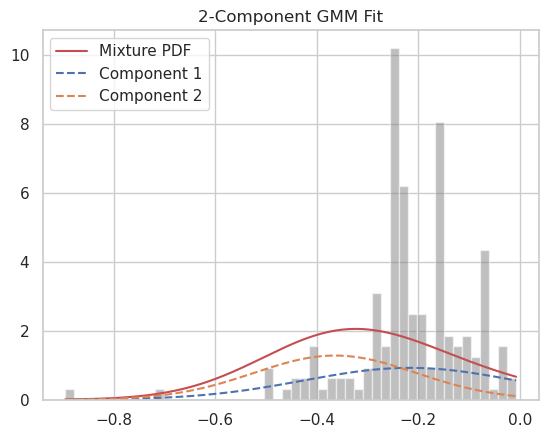

Dip statistic = 0.0000, p-value = 1.0000


In [152]:


phenos = shift_df_zoom["phenotype"].unique()
for ph in phenos:
    print(ph)
    data = shift_df_zoom.loc[shift_df_zoom["phenotype"] == ph, "developmental_shift"]
    
    # data = shift_df.loc[shift_df["phenotype"] == ph, "developmental_shift"]

    # Fit 1-component GMM to lmx1b_temp30 data
    gmm1 = GaussianMixture(n_components=1, random_state=42).fit(data_lmx.dropna().values.reshape(-1,1))

    plot_gmm_fit(data, gmm1, bins=50)
    # Fit 2-component GMM to lmx1b_temp30 data
    gmm2 = GaussianMixture(n_components=2, random_state=42).fit(data_lmx.dropna().values.reshape(-1,1))

    means = gmm2.means_.ravel()          # array of shape (2,)
    stds  = np.sqrt(gmm2.covariances_).ravel()  # array of shape (2,)
    weights = gmm2.weights_             # array of shape (2,)

    print("Means:", means)
    print("Stds :", stds)
    print("Weights:", weights)

    plot_gmm_fit(data, gmm2, bins=50)

    dip_val, p_val = diptest(data, n_boot=1000, random_state=42)
    print(f"Dip statistic = {dip_val:.4f}, p-value = {p_val:.4f}")



In [155]:
def fit_gmm_models(data: Union[pd.Series, np.ndarray], random_state: int = 42):
    """
    Fit 1-component and 2-component Gaussian Mixture Models (GMMs) to 1D data.

    Parameters
    ----------
    data : pd.Series or np.ndarray
        1D array-like data of numeric values.
    random_state : int, optional
        Seed for reproducibility. Default is 42.

    Returns
    -------
    gmm1 : GaussianMixture
        Fitted 1-component GMM.
    gmm2 : GaussianMixture
        Fitted 2-component GMM.
    loglike1 : float
        Total log-likelihood for the 1-component GMM.
    loglike2 : float
        Total log-likelihood for the 2-component GMM.
    """
    # Clean data: remove NaNs and reshape
    data_clean = np.array(data, dtype=float)
    data_clean = data_clean[~np.isnan(data_clean)].reshape(-1, 1)

    if data_clean.size == 0:
        raise ValueError("Input data contains no valid (non-NaN) values.")

    # Fit 1-component GMM
    gmm1 = GaussianMixture(n_components=1, random_state=random_state)
    gmm1.fit(data_clean)
    loglike1 = gmm1.score(data_clean) * data_clean.shape[0]  # Total log-likelihood

    # Fit 2-component GMM
    gmm2 = GaussianMixture(n_components=2, random_state=random_state)
    gmm2.fit(data_clean)
    loglike2 = gmm2.score(data_clean) * data_clean.shape[0]  # Total log-likelihood

    return gmm1, gmm2, loglike1, loglike2

def parametric_bootstrap_lrt(
    data: Union[pd.Series, np.ndarray],
    n_sims: int = 500,
    random_state: int = 42
):
    """
    Perform a parametric bootstrap likelihood ratio test comparing 1-component vs. 2-component GMMs.

    Parameters
    ----------
    data : pd.Series or np.ndarray
        1D array-like data of numeric values.
    n_sims : int, optional
        Number of bootstrap simulations. Default is 500.
    random_state : int, optional
        Seed for reproducibility. Default is 42.

    Returns
    -------
    delta_ll_observed : float
        Observed log-likelihood improvement from 1-component to 2-component GMM.
    sim_deltas : np.ndarray
        Array of simulated log-likelihood improvements from bootstrap samples.
    p_value : float
        p-value indicating the probability of observing such an improvement under the null hypothesis.
    """
    # Fit GMMs to real data
    gmm1, gmm2, ll1_real, ll2_real = fit_gmm_models(data, random_state=random_state)
    delta_ll_observed = ll2_real - ll1_real

    # Extract parameters from the 1-component GMM (null model)
    mean_null = gmm1.means_[0][0]
    cov_null = gmm1.covariances_[0][0]
    std_null = np.sqrt(cov_null)

    # Prepare for simulations
    rng = np.random.default_rng(seed=random_state)
    sim_deltas = []

    for i in range(n_sims):
        # Simulate data from the 1-component GMM
        sim_data = rng.normal(loc=mean_null, scale=std_null, size=data.shape[0]).reshape(-1, 1)

        # Fit GMMs to simulated data
        try:
            sim_gmm1, sim_gmm2, sim_ll1, sim_ll2 = fit_gmm_models(sim_data, random_state=random_state + i)
            sim_delta_ll = sim_ll2 - sim_ll1
            sim_deltas.append(sim_delta_ll)
        except Exception as e:
            print(f"Simulation {i+1}: Error fitting GMMs - {e}")
            continue

    sim_deltas = np.array(sim_deltas)

    # Calculate p-value
    p_value = np.mean(sim_deltas >= delta_ll_observed)

    return delta_ll_observed, sim_deltas, p_value

def plot_gmm_fit(
    data: Union[pd.Series, np.ndarray],
    gmm: GaussianMixture,
    bins: int = 30,
    title: str = "GMM Fit",
    color: str = "red"
):
    """
    Plot histogram of data with the fitted GMM PDF overlay.

    Parameters
    ----------
    data : pd.Series or np.ndarray
        1D array-like data of numeric values.
    gmm : GaussianMixture
        Fitted GMM model.
    bins : int, optional
        Number of histogram bins. Default is 30.
    title : str, optional
        Plot title. Default is "GMM Fit".
    color : str, optional
        Color for the GMM PDF line. Default is "red".
    """
    data_clean = np.array(data, dtype=float)
    data_clean = data_clean[~np.isnan(data_clean)]
    
    # Plot histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(data_clean, bins=bins, kde=False, stat='density', color='gray', edgecolor='black', alpha=0.6)
    
    # Generate range for PDF
    x = np.linspace(data_clean.min(), data_clean.max(), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    
    # Plot GMM PDF
    plt.plot(x, pdf, color=color, linewidth=2, label=f'{gmm.n_components}-Component GMM')
    
    plt.title(title)
    plt.xlabel("Developmental Shift")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_gmm_fit_detailed(
    data: Union[pd.Series, np.ndarray],
    gmm: GaussianMixture,
    bins: int = 30,
    title: str = "GMM Fit",
    colors: List[str] = ["red", "blue"]
):
    """
    Plot histogram of data with the fitted GMM PDF and individual component PDFs overlay.

    Parameters
    ----------
    data : pd.Series or np.ndarray
        1D array-like data of numeric values.
    gmm : GaussianMixture
        Fitted GMM model.
    bins : int, optional
        Number of histogram bins. Default is 30.
    title : str, optional
        Plot title. Default is "GMM Fit".
    colors : list of str, optional
        Colors for the overall GMM PDF and individual components. Default is ["red", "blue"].
    """
    data_clean = np.array(data, dtype=float)
    data_clean = data_clean[~np.isnan(data_clean)]
    
    plt.figure(figsize=(8, 6))
    sns.histplot(data_clean, bins=bins, kde=False, stat='density', color='gray', edgecolor='black', alpha=0.6)
    
    x = np.linspace(data_clean.min(), data_clean.max(), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    
    # Overall GMM PDF
    plt.plot(x, pdf, color=colors[0], linewidth=2, label=f'{gmm.n_components}-Component GMM')
    
    # Individual component PDFs
    for i in range(gmm.n_components):
        weight = gmm.weights_[i]
        mean = gmm.means_[i][0]
        cov = gmm.covariances_[i][0]
        std = np.sqrt(cov)
        component_pdf = weight * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
        plt.plot(x, component_pdf, linestyle='--', color=colors[i % len(colors)], label=f'Component {i+1}')
    
    plt.title(title)
    plt.xlabel("Developmental Shift")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

[41.95050324278345, 52.30362314514834]


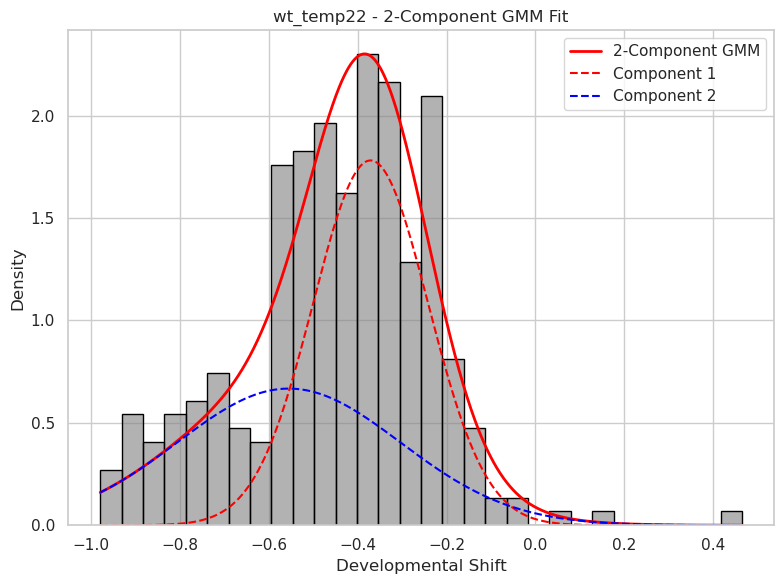

[12.359713654879524, 37.069680286354576]


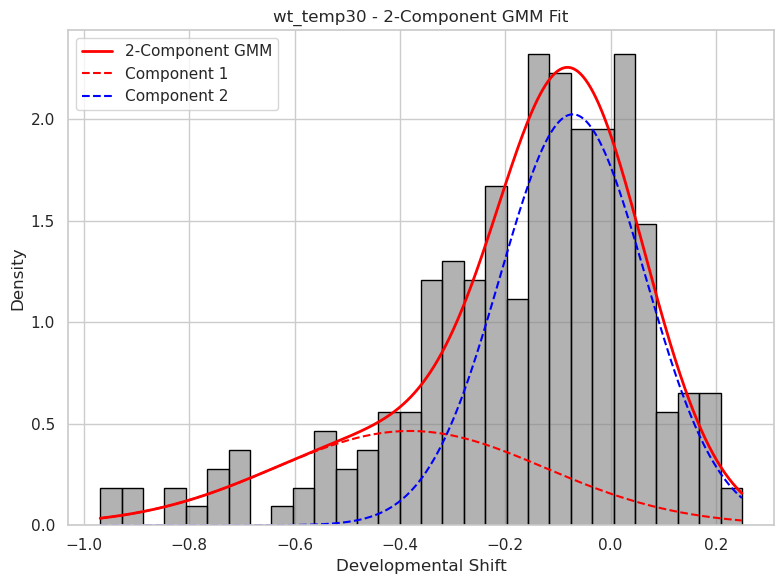

[24.108931497595034, 25.005089999793416]


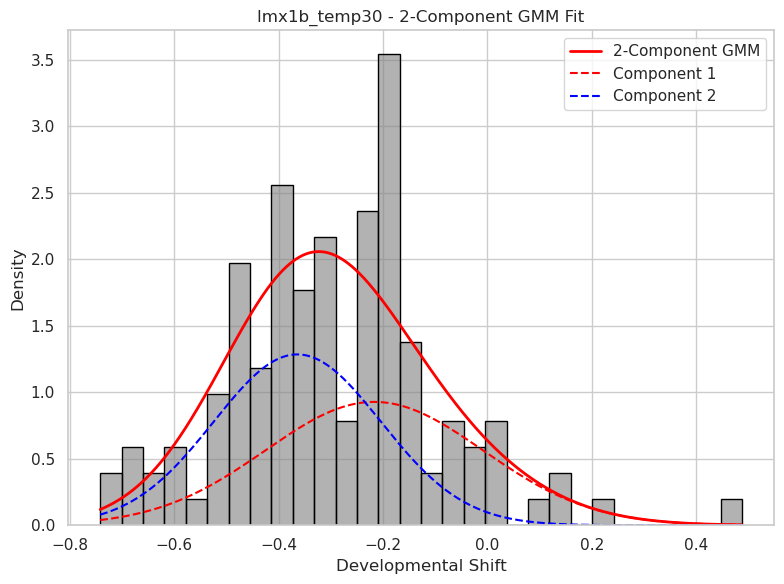

[13.228542807546987, 13.27427843401125]


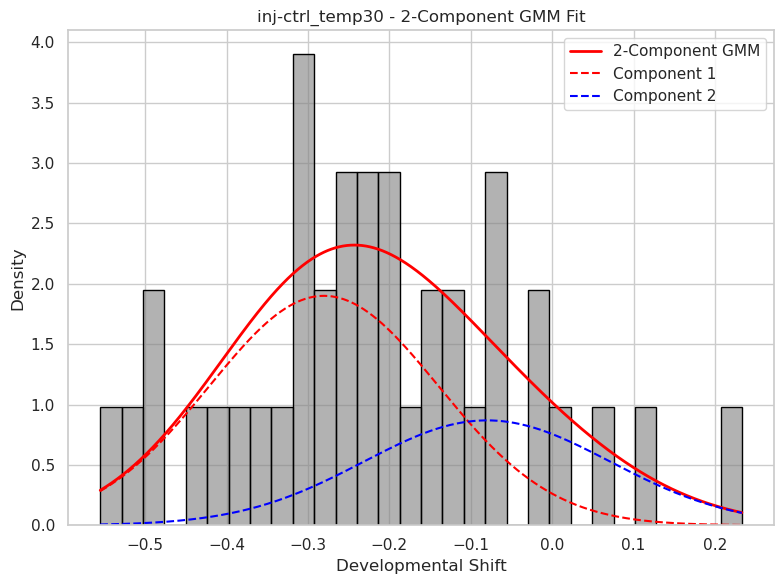

[130.5128649697545, 150.06928853731688]


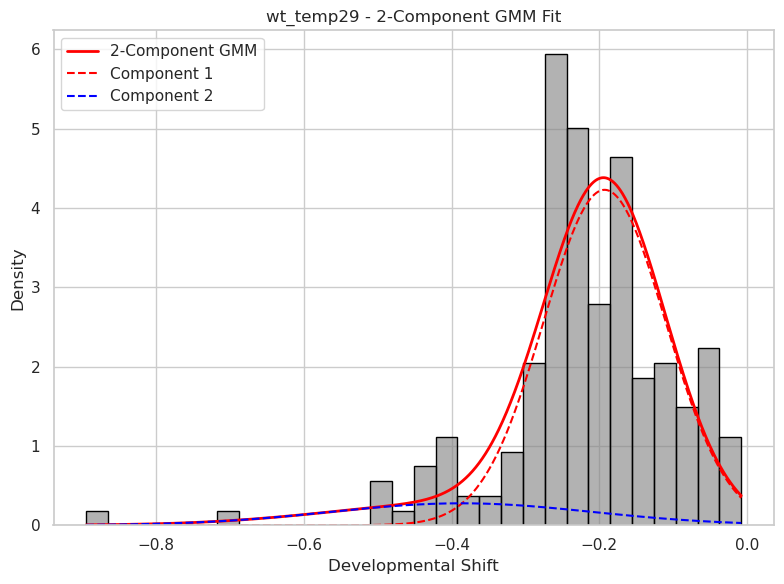

In [157]:

phenotypes_to_plot = shift_df_zoom["phenotype"].unique()


# Visualize with detailed component PDFs
for phenotype in phenotypes_to_plot:
    subset_df = shift_df_zoom[shift_df_zoom["phenotype"] == phenotype]["developmental_shift"]
    
    if subset_df.empty:
        continue
    
    try:
        gmm1, gmm2, ll1, ll2 = fit_gmm_models(subset_df, random_state=42)
        
        # Decide which model to visualize based on better fit
        if ll2 > ll1:
            best_gmm = gmm2
            model_label = "2-Component GMM"
        else:
            best_gmm = gmm1
            model_label = "1-Component GMM"
        print([ll1 ,ll2])
        
        # Plot the GMM fit with components
        plot_gmm_fit_detailed(
            data=subset_df,
            gmm=best_gmm,
            bins=30,
            title=f"{phenotype} - {model_label} Fit",
            colors=["red", "blue"]  # Adjust as needed
        )
    
    except Exception as e:
        print(f"Error visualizing GMM for phenotype {phenotype}: {e}\n")


phenos = shift_df_zoom["phenotype"].unique()

In [ ]:
data_1d

In [144]:


def dipstat(x):
    """
    Compute Hartigan's dip statistic for a 1D numpy array 'x'.
    
    Returns
    -------
    dip : float
        The dip statistic (0 <= dip <= 0.5).
    
    Notes
    -----
    - The dip statistic measures how far the empirical distribution is 
      from any unimodal distribution.
    - Typically, you would compare 'dip' to a distribution of dip values 
      under the null hypothesis of unimodality to get a p-value.
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        return 0.0

    # Sort the data
    x.sort()

    # The CDF step
    cdf = np.arange(1, n+1) / float(n)

    # 'fn' will be the empirical distribution function in sorted order
    fn = cdf

    # Some arrays to keep track of the lower and upper folds
    gcm = np.zeros(n, dtype=int)
    lcm = np.zeros(n, dtype=int)

    # Step 1: Greatest Convex Minorant (GCM)
    # Start from left
    gcm[0] = 0
    ig = 0
    for j in range(1, n):
        # incrementally build the convex hull
        while True:
            slope_new = (fn[j] - fn[gcm[ig]]) / (x[j] - x[gcm[ig]])
            if ig == 0:
                slope_old = -np.inf
            else:
                slope_old = (fn[gcm[ig]] - fn[gcm[ig-1]]) / (x[gcm[ig]] - x[gcm[ig-1]])
            if slope_new <= slope_old and ig > 0:
                ig -= 1
            else:
                break
        ig += 1
        gcm[ig] = j

    # 'ig' is the number of points in the GCM hull minus 1
    gcm = gcm[:ig+1]

    # Step 2: Least Concave Majorant (LCM)
    # Start from right
    lcm[-1] = n-1
    ih = n-1
    for j in range(n-2, -1, -1):
        while True:
            slope_new = (fn[j] - fn[lcm[ih]]) / (x[j] - x[lcm[ih]])
            if ih == n-1:
                slope_old = np.inf
            else:
                slope_old = (fn[lcm[ih]] - fn[lcm[ih+1]]) / (x[lcm[ih]] - x[lcm[ih+1]])
            if slope_new >= slope_old and ih < n-1:
                ih += 1
            else:
                break
        ih -= 1
        lcm[ih] = j
    lcm = lcm[ih:]

    # Step 3: Evaluate the maximum distance between these two hulls
    dip = 0.0
    # Merge the GCM & LCM points
    ig = 0
    ih = 0
    g_len = len(gcm)
    l_len = len(lcm)
    while ig < g_len-1 and ih < l_len-1:
        # find intersection interval
        left = max(gcm[ig], lcm[ih])
        right = min(gcm[ig+1], lcm[ih+1])
        if right <= left:
            if x[right] == x[left]:
                mid = left
            else:
                mid = (left + right)//2
            # compute vertical distance
            dip_temp = 0.0
            dip = max(dip, dip_temp)
            if x[gcm[ig+1]] < x[lcm[ih+1]]:
                ig += 1
            elif x[gcm[ig+1]] > x[lcm[ih+1]]:
                ih += 1
            else:
                ig += 1
                ih += 1
            continue

        # slopes for GCM
        slope_g = (fn[gcm[ig+1]] - fn[gcm[ig]]) / (x[gcm[ig+1]] - x[gcm[ig]])
        intercept_g = fn[gcm[ig]] - slope_g * x[gcm[ig]]

        # slopes for LCM
        slope_l = (fn[lcm[ih+1]] - fn[lcm[ih]]) / (x[lcm[ih+1]] - x[lcm[ih]])
        intercept_l = fn[lcm[ih]] - slope_l * x[lcm[ih]]

        # Evaluate difference on [left, right]
        xx_left  = x[left]
        xx_right = x[right]
        # The difference function between the two lines is (GCM - LCM).
        # We'll check the difference at endpoints
        g_left = slope_g*xx_left + intercept_g
        l_left = slope_l*xx_left + intercept_l
        diff_left = abs(g_left - l_left)

        g_right = slope_g*xx_right + intercept_g
        l_right = slope_l*xx_right + intercept_l
        diff_right = abs(g_right - l_right)

        # The difference might be max somewhere in the interior if slopes differ
        # If slope_g != slope_l, we can find the intersection point
        # but for simplicity, check just endpoints or do a small bracket
        dip_local = max(diff_left, diff_right)
        dip = max(dip, dip_local)

        # Move to next hull segments
        if x[gcm[ig+1]] < x[lcm[ih+1]]:
            ig += 1
        elif x[gcm[ig+1]] > x[lcm[ih+1]]:
            ih += 1
        else:
            ig += 1
            ih += 1

    return dip


def diptest(x, n_boot=1000, random_state=42):
    """
    Hartigan's Dip Test for unimodality, returning (dip, p_value).

    - dip: The dip statistic.
    - p_value: Approximate significance level via bootstrap.

    Parameters
    ----------
    x : array-like
        1D numeric array of data.
    n_boot : int
        Number of bootstrap simulations.
    random_state : int
        For reproducibility.

    Returns
    -------
    dip : float
        Hartigan's dip statistic.
    p_value : float
        Approximate p-value for the unimodality test.
    """
    rng = np.random.default_rng(random_state)
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if len(x) < 2:
        return 0.0, 1.0  # trivially unimodal with 1 or 0 points

    # Observed dip
    observed_dip = dipstat(x)

    # For parametric bootstrap, assume a single Gaussian 
    # (with sample mean & std dev).
    mu = np.mean(x)
    sigma = np.std(x, ddof=1)  # unbiased

    if sigma <= 1e-12:
        # All points are (nearly) identical => unimodal
        return observed_dip, 1.0

    # Generate bootstrap samples
    count_extreme = 0
    for _ in range(n_boot):
        # sample from normal with same mean & std
        sample = rng.normal(loc=mu, scale=sigma, size=len(x))
        boot_dip = dipstat(sample)
        if boot_dip >= observed_dip:
            count_extreme += 1

    p_value = (count_extreme + 1) / (n_boot + 1.0)
    return observed_dip, p_value


# Suppose you have a NumPy array or a pandas Series with your data
import numpy as np

data = np.random.normal(size=500)

dip_val, p_val = diptest(data, n_boot=2000, random_state=42)
print(f"Dip statistic = {dip_val:.4f}, p-value = {p_val:.4f}")

Dip statistic = 0.0000, p-value = 1.0000


In [137]:
# !pip install hyppo


data_1d = data[~np.isnan(data)]  # your 1D array of values
stat, p_value = DIP().test(data_1d)

print(f"Hartigan's Dip Statistic = {stat:.4f}, p-value = {p_value:.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 2.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.5 MB/s eta 0:00:00


ImportError: /net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/fft/_pocketfft/pypocketfft.cpython-39-x86_64-linux-gnu.so)

/tmp/9345736.1.trapnell-login.q/ipykernel_2200385/2403576159.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(shift_df.sample(frac=1)[shift_df["phenotype"].isin(["wt_temp30"])]["developmental_shift"])


(array([  1.,   0.,   0.,   0.,   0.,   7.,   9.,  10.,  39., 226.]),
 array([-6.00533486, -5.37987244, -4.75441002, -4.12894759, -3.50348517,
        -2.87802275, -2.25256033, -1.6270979 , -1.00163548, -0.37617306,
         0.24928937]),
 <BarContainer object of 10 artists>)

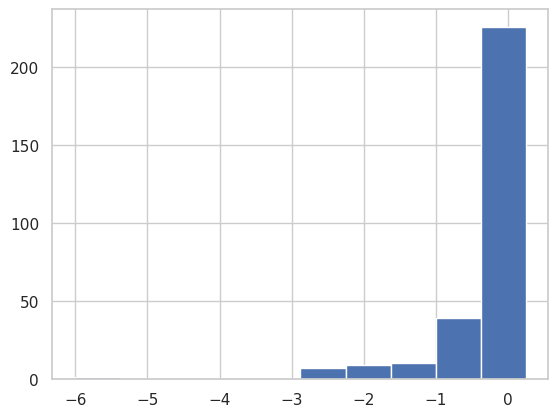

In [ ]:

plt.hist(shift_df.sample(frac=1)[shift_df["phenotype"].isin(["wt_temp30"])]["developmental_shift"])

In [ ]:

import seaborn as sns


def plot_multi_bootstrap(
    data_list,
    labels,
    title="Comparison of Average Times for Different Conditions",
    use_time_init=True
):
    """
    Plot multiple bootstrap time curves (mean ± std) on a single figure.
    
    Parameters
    ----------
    data_list : list of tuples
        Each element is (summary_df, df_augmented) for a particular condition.
        - summary_df must have columns ['segment_id', 'mean_time', 'std_time'].
          'mean_time' and 'std_time' are in seconds, aggregated over bootstrap journeys.
        - df_augmented must have at least ['segment_id', 'predicted_stage_hpf'] 
          if using time_init. If 'use_time_init' is False, df_augmented can be None.
          
    labels : list of str
        Labels for each condition (used in legend). Must match length of `data_list`.
        
    title : str
        Title for the final plot.
        
    use_time_init : bool
        If True, shifts the bootstrap mean_time by the average predicted_stage_hpf
        at the first segment found in 'summary_df'. If False, no offset is added.
    
    Returns
    -------
    None (displays a matplotlib figure)
    """
    if len(data_list) != len(labels):
        raise ValueError("data_list and labels must have the same length.")

    plt.figure(figsize=(10, 6))

    for (summary_df, df_aug), cond_label in zip(data_list, labels):
        summary_df = summary_df.copy()

        # Convert from seconds to hours
        summary_df["mean_time_hours"] = summary_df["mean_time"] / 3600.0
        summary_df["std_time_hours"] = summary_df["std_time"] / 3600.0
        
        if use_time_init:
            # Shift by the average predicted_stage_hpf for the starting segment
            # found in summary_df
            start_seg = int(summary_df["segment_id"].min())
            if df_aug is not None:
                # Compute the offset time_init from the data
                seg_mask = (df_aug["segment_id"] == start_seg)
                # In case no rows match, we handle it safely
                if seg_mask.any():
                    time_init = df_aug.loc[seg_mask, "predicted_stage_hpf"].mean()
                else:
                    time_init = 0.0
            else:
                # If df_aug not provided, can't compute time_init
                time_init = 0.0
            
            summary_df["mean_time_hours"] += time_init

        # Plot the bootstrap times (hours) with error bars
        plt.errorbar(
            summary_df["segment_id"],
            summary_df["mean_time_hours"],
            yerr=summary_df["std_time_hours"],
            fmt='-o',
            capsize=5,
            markersize=4,
            label=cond_label
        )

    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_developmental_shifts(df_embryos, summary_df_wt_calc, color_by="phenotype"):
    """
    For each embryo_id in df_embryos:
      1) Identify earliest and latest time points (by experiment_time).
      2) Compute embryo's morphological velocity = (Delta time in hours) / (Delta segment).
      3) Compute reference morphological velocity for the same segment range
         using summary_df_wt_calc's mean_time_hours.
      4) developmental_shift = ref_morph_velocity - embryo_morph_velocity.

    Returns a DataFrame with columns:
      [
        "embryo_id", 
        "earliest_segment", 
        "latest_segment", 
        "embryo_morph_velocity", 
        "ref_morph_velocity", 
        "developmental_shift", 
        color_by
      ]
    One row per embryo_id.
    
    Parameters
    ----------
    df_embryos : pd.DataFrame
        Must have columns:
          - embryo_id
          - experiment_time (seconds)
          - ref_seg_id
          - plus the column for coloring (e.g., phenotype)
    summary_df_wt_calc : pd.DataFrame
        Must have columns:
          - segment_id
          - mean_time_hours (average time to that segment, in hours)
    color_by : str
        Column name in df_embryos to use for coloring or grouping in the histogram.
    """
    results = []
    
    grouped = df_embryos.groupby("embryo_id")
    for emb_id, group in grouped:
        # Sort by time
        group_sorted = group.sort_values("experiment_time")
        if len(group_sorted) < 2:
            # Not enough data points to define earliest and latest
            continue
        
        # Earliest & latest rows
        first_row = group_sorted.iloc[0]
        last_row  = group_sorted.iloc[-1]
        
        # Convert time to hours
        time_early_hrs = first_row["experiment_time"] / 3600.0
        time_late_hrs  = last_row["experiment_time"]  / 3600.0
        delta_time_hrs = time_late_hrs - time_early_hrs
        
        # Earliest & latest ref_seg_id
        seg_early = first_row["ref_seg_id"]
        seg_late  = last_row["ref_seg_id"]
        
        # If the earliest segment or latest segment is NaN or there's no difference, skip
        if pd.isnull(seg_early) or pd.isnull(seg_late) or seg_early == seg_late:
            continue
        
        # Delta in segment space
        delta_seg = seg_late - seg_early
        
        # Embryo morphological velocity
        embryo_morph_velocity =  delta_seg / delta_time_hrs
        
        # Reference morphological velocity:
        #   We find the reference's average time for earliest & latest segment
        #   from summary_df_wt_calc. Then compute the difference and scale by delta_seg.
        #   i.e. ref_morph_velocity = (ref_time_late - ref_time_early) / delta_seg
        ref_row_early = summary_df_wt_calc.loc[summary_df_wt_calc["segment_id"] == seg_early]
        ref_row_late  = summary_df_wt_calc.loc[summary_df_wt_calc["segment_id"] == seg_late]
        if len(ref_row_early) == 0 or len(ref_row_late) == 0:
            # The reference summary might not have these segments
            continue
        
        ref_time_early = ref_row_early["mean_time_hours"].iloc[0]
        ref_time_late  = ref_row_late["mean_time_hours"].iloc[0]
        ref_delta_time = ref_time_late - ref_time_early
        
        ref_morph_velocity =  delta_seg / ref_delta_time
        
        # Developmental shift
        developmental_shift =  embryo_morph_velocity - ref_morph_velocity
        
        # Grab the color-by value from either the first or last row
        # (assuming it's consistent for the entire embryo)
        col_value = first_row.get(color_by, np.nan)
        
        results.append({
            "embryo_id": emb_id,
            "earliest_segment": seg_early,
            "latest_segment": seg_late,
            "embryo_morph_velocity": embryo_morph_velocity,
            "ref_morph_velocity": ref_morph_velocity,
            "developmental_shift": developmental_shift,
            color_by: col_value
        })
    
    return pd.DataFrame(results)

def plot_developmental_shifts_violin(shift_df, color_by="phenotype", show_dots=True, remove_outliers=True):
    """
    Given a DataFrame with a 'developmental_shift' column and a grouping column (color_by),
    plot a violin plot of the developmental shifts, grouped by the specified column,
    with an option to overlay individual points as a strip plot and to remove extreme outliers.
    
    Parameters
    ----------
    shift_df : pd.DataFrame
        Must have columns ['developmental_shift', color_by].
    color_by : str
        Column name in shift_df to group by for the violin plot.
    show_dots : bool, optional
        Whether to overlay individual points on the violin plot (default: True).
    remove_outliers : bool, optional
        Whether to remove extreme outliers based on the IQR method (default: True).
    """
    # Optionally remove outliers
    if remove_outliers:
        q1 = shift_df["developmental_shift"].quantile(0.25)
        q3 = shift_df["developmental_shift"].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        shift_df = shift_df[(shift_df["developmental_shift"] >= lower_bound) & 
                            (shift_df["developmental_shift"] <= upper_bound)]
    
    plt.figure(figsize=(8, 6))

    # Create violin plot
    sns.violinplot(
        data=shift_df,
        x=color_by,
        y="developmental_shift",
        inner="box",  # Show quartiles and medians inside violins
        scale="width",  # Adjust violin width by number of observations per group
        palette="muted"
    )
    
    # Optionally overlay individual points
    if show_dots:
        sns.stripplot(
            data=shift_df,
            x=color_by,
            y="developmental_shift",
            color="black",  # Black dots
            alpha=0.6,      # Semi-transparent for overlapping points
            jitter=True,    # Add jitter to spread points horizontally
            dodge=True      # Separate points slightly for each hue group (if applicable)
        )

    # Customize plot
    plt.title("Developmental Shift Distribution by " + color_by.capitalize())
    plt.xlabel(color_by.capitalize())
    plt.ylabel("Developmental Shift (ref_morph_velocity - embryo_morph_velocity)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [48]:
median_shift - tolerance

5.530704821834805

In [ ]:
median_shift

In [ ]:
# Corrected and optimized code to create embryo_id_list

# Ensure the column names are correctly spelled
embryo_id_list_slow = shift_df.sort_values(by='developmental_shift')["embryo_id"].head(5).tolist()
shift_df.sort_values(by='developmental_shift')
# Sort the DataFrame by 'developmental_delay' in descending order
embryo_id_list_fast = shift_df.sort_values(by='developmental_shift', ascending=False)["embryo_id"].head(5).tolist()
shift_df.sort_values(by='developmental_shift', ascending=False)

embryo_id_list_avg


plot_stage_vs_ref_seg(
    df=df_augmented_projec_wt,
    embryo_ids=embryo_id_list
)


embryo_id  earliest_segment  latest_segment  \
534  20240306_H10_e00                21              39   
153  20230602_C10_e00                 2              35   
561  20240404_B02_e00                21              47   
981  20241023_A02_e00                30              48   
688  20240509_G01_e00                 5              41   
..                ...               ...             ...   
531  20240306_H05_e00                18              15   
644  20240509_C02_e00                10              14   
513  20240306_E11_e00                17              11   
494  20240306_C07_e00                13              14   
675  20240509_E11_e00                13              14   

     embryo_morph_velocity  ref_morph_velocity  developmental_shift  \
534               1.685136            1.198007             0.487130   
153               2.267150            1.802104             0.465046   
561               1.130867            0.881577             0.249289   
981               0.924442            0.685308             0.239134   
688               1.750822            1.517818             0.233005   
..                     ...                 ...                  ...   
531              -0.954761            2.842075            -3.796836   
644               0.194566            4.135406            -3.940840   
513              -1.415196            2.579125            -3.994321   
494               0.058331            6.054054            -5.995722   
675               0.048719            6.054054            -6.005335   

           phenotype  
534     lmx1b_temp30  
153        wt_temp22  
561        wt_temp30  
981        wt_temp30  
688  inj-ctrl_temp30  
..               ...  
531     lmx1b_temp30  
644     lmx1b_temp30  
513     lmx1b_temp30  
494     lmx1b_temp30  
675        wt_temp30  

[1025 rows x 7 columns]

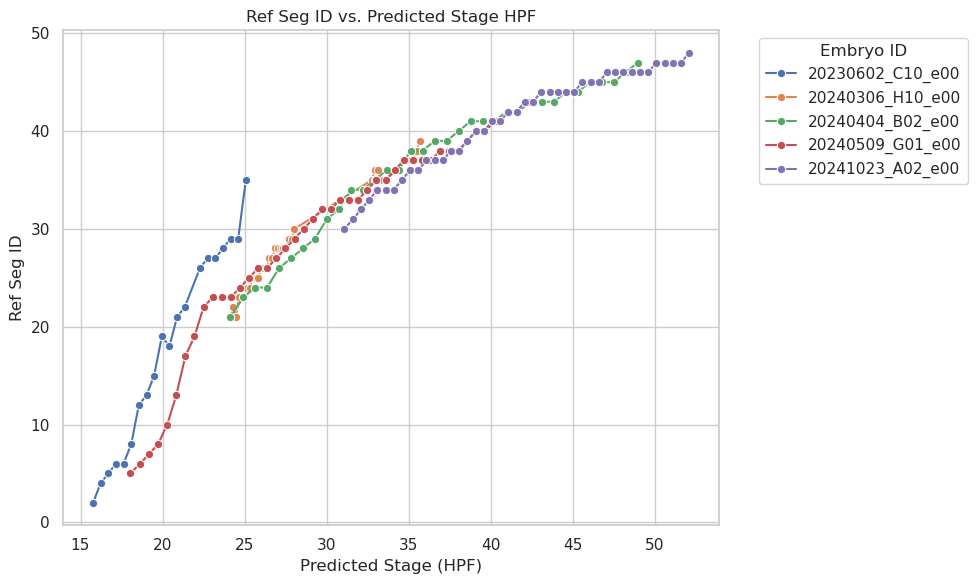

In [36]:

plot_stage_vs_ref_seg(
    df=df_augmented_projec_wt,
    embryo_ids=embryo_id_list
)


In [23]:
imp_cols = ["phenotype","embryo_id","snip_id", "predicted_stage_hpf","ref_seg_id"]

In [ ]:
imp_cols = ["phenotype","embryo_id","snip_id", "predicted_stage_hpf","ref_seg_id"]

df_augmented_projec_wt[df_augmented_projec_wt["embryo_id"] == "20240509_E11_e00"][imp_cols]

phenotype         embryo_id                 snip_id  \
13979  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0000   
13980  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0001   
13981  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0002   
13982  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0003   
13983  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0004   
13984  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0005   
13985  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0006   
13986  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0007   
13987  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0008   
13988  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0009   
13989  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0010   
13990  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0011   
13991  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0012   
13992  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0013   
13993  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0014   
13994  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0015   
13995  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0016   
13996  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0017   
13997  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0018   
13998  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0019   
13999  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0020   
14000  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0021   
14001  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0022   
14002  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0023   
14003  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0024   
14004  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0025   
14005  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0026   
14006  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0027   
14007  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0028   
14008  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0029   
14009  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0030   
14010  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0031   
14011  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0032   
14012  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0033   
14013  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0034   
14014  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0035   
14015  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0036   
14016  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0037   
14017  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0038   
14018  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0039   
14019  wt_temp30  20240509_E11_e00  20240509_E11_e00_t0040   

       predicted_stage_hpf  ref_seg_id  
13979            24.522982          13  
13980            25.078580          15  
13981            25.629815          17  
13982            26.182733          17  
13983            26.736141          19  
13984            27.288807          20  
13985            27.842689          19  
13986            28.397840          19  
13987            28.954247          18  
13988            29.509265          17  
13989            30.063284          17  
13990            30.618188          17  
13991            31.173256          17  
13992            31.727371          17  
13993            32.282089          17  
13994            32.837281          17  
13995            33.391918          17  
13996            33.946809          17  
13997            34.501990          17  
13998            35.057244          17  
13999            35.611500          17  
14000            36.167235          17  
14001            36.722980          16  
14002            37.277646          16  
14003            37.832843          16  
14004            38.388523          16  
14005            38.942544          16  
14006            39.496385          16  
14007            40.049615          15  
14008            40.604757          15  
14009            41.158489          15  
14010            41.711611          15  
14011            42.265211          15  
14012   

# Looking accross temperatures

In [15]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_multi_bootstrap(
    data_list,
    labels,
    title="Comparison of Average Times for Different Conditions",
    use_time_init=True
):
    """
    Plot multiple bootstrap time curves (mean ± std) on a single figure.
    
    Parameters
    ----------
    data_list : list of tuples
        Each element is (summary_df, df_augmented) for a particular condition.
        - summary_df must have columns ['segment_id', 'mean_time', 'std_time'].
          'mean_time' and 'std_time' are in seconds, aggregated over bootstrap journeys.
        - df_augmented must have at least ['segment_id', 'predicted_stage_hpf'] 
          if using time_init. If 'use_time_init' is False, df_augmented can be None.
          
    labels : list of str
        Labels for each condition (used in legend). Must match length of `data_list`.
        
    title : str
        Title for the final plot.
        
    use_time_init : bool
        If True, shifts the bootstrap mean_time by the average predicted_stage_hpf
        at the first segment found in 'summary_df'. If False, no offset is added.
    
    Returns
    -------
    None (displays a matplotlib figure)
    """
    if len(data_list) != len(labels):
        raise ValueError("data_list and labels must have the same length.")

    plt.figure(figsize=(10, 6))

    for (summary_df, df_aug), cond_label in zip(data_list, labels):
        summary_df = summary_df.copy()

        # Convert from seconds to hours
        summary_df["mean_time_hours"] = summary_df["mean_time"] / 3600.0
        summary_df["std_time_hours"] = summary_df["std_time"] / 3600.0
        
        if use_time_init:
            # Shift by the average predicted_stage_hpf for the starting segment
            # found in summary_df
            start_seg = int(summary_df["segment_id"].min())
            if df_aug is not None:
                # Compute the offset time_init from the data
                seg_mask = (df_aug["segment_id"] == start_seg)
                # In case no rows match, we handle it safely
                if seg_mask.any():
                    time_init = df_aug.loc[seg_mask, "predicted_stage_hpf"].mean()
                else:
                    time_init = 0.0
            else:
                # If df_aug not provided, can't compute time_init
                time_init = 0.0
            
            summary_df["mean_time_hours"] += time_init

        # Plot the bootstrap times (hours) with error bars
        plt.errorbar(
            summary_df["segment_id"],
            summary_df["mean_time_hours"],
            yerr=summary_df["std_time_hours"],
            fmt='-o',
            capsize=5,
            markersize=4,
            label=cond_label
        )

    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_developmental_shifts(df_embryos, summary_df_wt_calc, color_by="phenotype"):
    """
    For each embryo_id in df_embryos:
      1) Identify earliest and latest time points (by experiment_time).
      2) Compute embryo's morphological velocity = (Delta time in hours) / (Delta segment).
      3) Compute reference morphological velocity for the same segment range
         using summary_df_wt_calc's mean_time_hours.
      4) developmental_shift = ref_morph_velocity - embryo_morph_velocity.

    Returns a DataFrame with columns:
      [
        "embryo_id", 
        "earliest_segment", 
        "latest_segment", 
        "embryo_morph_velocity", 
        "ref_morph_velocity", 
        "developmental_shift", 
        color_by
      ]
    One row per embryo_id.
    
    Parameters
    ----------
    df_embryos : pd.DataFrame
        Must have columns:
          - embryo_id
          - experiment_time (seconds)
          - ref_seg_id
          - plus the column for coloring (e.g., phenotype)
    summary_df_wt_calc : pd.DataFrame
        Must have columns:
          - segment_id
          - mean_time_hours (average time to that segment, in hours)
    color_by : str
        Column name in df_embryos to use for coloring or grouping in the histogram.
    """
    results = []
    
    grouped = df_embryos.groupby("embryo_id")
    for emb_id, group in grouped:
        # Sort by time
        group_sorted = group.sort_values("experiment_time")
        if len(group_sorted) < 2:
            # Not enough data points to define earliest and latest
            continue
        
        # Earliest & latest rows
        first_row = group_sorted.iloc[0]
        last_row  = group_sorted.iloc[-1]
        
        # Convert time to hours
        time_early_hrs = first_row["experiment_time"] / 3600.0
        time_late_hrs  = last_row["experiment_time"]  / 3600.0
        delta_time_hrs = time_late_hrs - time_early_hrs
        
        # Earliest & latest ref_seg_id
        seg_early = first_row["ref_seg_id"]
        seg_late  = last_row["ref_seg_id"]
        
        # If the earliest segment or latest segment is NaN or there's no difference, skip
        if pd.isnull(seg_early) or pd.isnull(seg_late) or seg_early == seg_late:
            continue
        
        # Delta in segment space
        delta_seg = seg_late - seg_early
        
        # Embryo morphological velocity
        embryo_morph_velocity =  delta_seg / delta_time_hrs
        
        # Reference morphological velocity:
        #   We find the reference's average time for earliest & latest segment
        #   from summary_df_wt_calc. Then compute the difference and scale by delta_seg.
        #   i.e. ref_morph_velocity = (ref_time_late - ref_time_early) / delta_seg
        ref_row_early = summary_df_wt_calc.loc[summary_df_wt_calc["segment_id"] == seg_early]
        ref_row_late  = summary_df_wt_calc.loc[summary_df_wt_calc["segment_id"] == seg_late]
        if len(ref_row_early) == 0 or len(ref_row_late) == 0:
            # The reference summary might not have these segments
            continue
        
        ref_time_early = ref_row_early["mean_time_hours"].iloc[0]
        ref_time_late  = ref_row_late["mean_time_hours"].iloc[0]
        ref_delta_time = ref_time_late - ref_time_early
        
        ref_morph_velocity =  delta_seg / ref_delta_time
        
        # Developmental shift
        developmental_shift =  embryo_morph_velocity - ref_morph_velocity
        
        # Grab the color-by value from either the first or last row
        # (assuming it's consistent for the entire embryo)
        col_value = first_row.get(color_by, np.nan)
        
        results.append({
            "embryo_id": emb_id,
            "earliest_segment": seg_early,
            "latest_segment": seg_late,
            "embryo_morph_velocity": embryo_morph_velocity,
            "ref_morph_velocity": ref_morph_velocity,
            "developmental_shift": developmental_shift,
            color_by: col_value
        })
    
    return pd.DataFrame(results)

def plot_developmental_shifts_violin(shift_df, color_by="phenotype", show_dots=True, remove_outliers=True):
    """
    Given a DataFrame with a 'developmental_shift' column and a grouping column (color_by),
    plot a violin plot of the developmental shifts, grouped by the specified column,
    with an option to overlay individual points as a strip plot and to remove extreme outliers.
    
    Parameters
    ----------
    shift_df : pd.DataFrame
        Must have columns ['developmental_shift', color_by].
    color_by : str
        Column name in shift_df to group by for the violin plot.
    show_dots : bool, optional
        Whether to overlay individual points on the violin plot (default: True).
    remove_outliers : bool, optional
        Whether to remove extreme outliers based on the IQR method (default: True).
    """
    # Optionally remove outliers
    if remove_outliers:
        q1 = shift_df["developmental_shift"].quantile(0.25)
        q3 = shift_df["developmental_shift"].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        shift_df = shift_df[(shift_df["developmental_shift"] >= lower_bound) & 
                            (shift_df["developmental_shift"] <= upper_bound)]
    
    plt.figure(figsize=(8, 6))

    # Create violin plot
    sns.violinplot(
        data=shift_df,
        x=color_by,
        y="developmental_shift",
        inner="box",  # Show quartiles and medians inside violins
        scale="width",  # Adjust violin width by number of observations per group
        palette="muted"
    )
    
    # Optionally overlay individual points
    if show_dots:
        sns.stripplot(
            data=shift_df,
            x=color_by,
            y="developmental_shift",
            color="black",  # Black dots
            alpha=0.6,      # Semi-transparent for overlapping points
            jitter=True,    # Add jitter to spread points horizontally
            dodge=True      # Separate points slightly for each hue group (if applicable)
        )

    # Customize plot
    plt.title("Developmental Shift Distribution by " + color_by.capitalize())
    plt.xlabel(color_by.capitalize())
    plt.ylabel("Developmental Shift (ref_morph_velocity - embryo_morph_velocity)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [8]:
# Specify the minimum number of snip_ids per embryo_id
pert_comparisons = ["wt","lmx1b", "inj-ctrl"]

min_snips = 20

# Filter the DataFrame to only include embryo_id with at least `min_snips` snip_ids
df    = df_orig.groupby('embryo_id').filter(lambda x: len(x) >= min_snips)
df = df[df["phenotype"].isin(pert_comparisons)]

df_30 = df[df["temperature"]==30.0]
df_29 = df[df["temperature"]==29.0]
df_22 = df[df["temperature"]==22.0]



df_30["phenotype"] = df_30["phenotype"].astype(str) + "_temp" + df_30["temperature"].astype(str)
df_29["phenotype"] = df_29["phenotype"].astype(str) + "_temp" + df_29["temperature"].astype(str)
df_22["phenotype"] = df_22["phenotype"].astype(str) + "_temp" + df_22["temperature"].astype(str)

# Concatenating the DataFrames
df_temps = pd.concat([df_30, df_29, df_22], ignore_index=True)

pert_comparisons = df_temps["phenotype"].unique()

df_temps   = apply_pca_on_pert_comparisons(df_temps  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )


# df_30   = apply_pca_on_pert_comparisons(df_30  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )


# df_30   = apply_pca_on_pert_comparisons(df_30  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
# df_22   = apply_pca_on_pert_comparisons(df_22  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
# df      = apply_pca_on_pert_comparisons(df_orig,z_mu_biological_columns,pert_comparisons=pert_comparisons )

/tmp/9345736.1.trapnell-login.q/ipykernel_2200385/3716975136.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30["phenotype"] = df_30["phenotype"].astype(str) + "_temp" + df_30["temperature"].astype(str)
/tmp/9345736.1.trapnell-login.q/ipykernel_2200385/3716975136.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_29["phenotype"] = df_29["phenotype"].astype(str) + "_temp" + df_29["temperature"].astype(str)
/tmp/9345736.1.trapnell-login.q/ipykernel_2200385/3716975136.py:18: SettingWithCopyWarning

Using specified perturbations for PCA: ['wt_temp30' 'lmx1b_temp30' 'inj-ctrl_temp30' 'wt_temp29' 'wt_temp22']

PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 86.08%

Principal Component Explained Variance Ratio
              PCA_1                   43.21%
              PCA_2                   32.34%
              PCA_3                   10.53%
----------------------------



In [46]:
df_temps

Unnamed: 0                 snip_id         embryo_id  experiment_time  \
0           28553  20231110_A08_e00_t0000  20231110_A08_e00      1919.332160   
1           28554  20231110_A08_e00_t0001  20231110_A08_e00      4951.991120   
2           28555  20231110_A08_e00_t0003  20231110_A08_e00     10012.480400   
3           28556  20231110_A08_e00_t0004  20231110_A08_e00     12550.292000   
4           28557  20231110_A08_e00_t0005  20231110_A08_e00     15075.814400   
...           ...                     ...               ...              ...   
55043       28094  20230629_F10_e00_t0019  20230629_F10_e00     50785.658936   
55044       28095  20230629_F10_e00_t0020  20230629_F10_e00     53513.303589   
55045       28096  20230629_F10_e00_t0021  20230629_F10_e00     56242.961914   
55046       28097  20230629_F10_e00_t0022  20230629_F10_e00     58975.074707   
55047       28098  20230629_F10_e00_t0023  20230629_F10_e00     61706.173218   

      experiment_date  temperature  medium short_pert_name  control_flag  \
0            20231110           30  MC_015          wt_wik             0   
1            20231110           30  MC_015          wt_wik             0   
2            20231110           30  MC_015          wt_wik             0   
3            20231110           30  MC_015          wt_wik             0   
4            20231110           30  MC_015          wt_wik             0   
...               ...          ...     ...             ...           ...   
55043        20230629           22  MC_015          wt_wik             0   
55044        20230629           22  MC_015          wt_wik             0   
55045        20230629           22  MC_015          wt_wik             0   
55046        20230629           22  MC_015          wt_wik             0   
55047        20230629           22  MC_015          wt_wik             0   

       phenotype  ...  UMAP_02_3  UMAP_00_bio_3  UMAP_01_bio_3  UMAP_02_bio_3  \
0      wt_temp30  ...  11.104937      10.700978       8.723147      10.477208   
1      wt_temp30  ...  10.480471      10.319400       9.870806      10.282644   
2      wt_temp30  ...   9.583109       8.951474      10.274587       8.712678   
3      wt_temp30  ...   9.555550       8.928264      10.396387       9.037141   
4      wt_temp30  ...   9.495592       9.055897      10.474813       8.812095   
...          ...  ...        ...            ...            ...            ...   
55043  wt_temp22  ...   4.995747       5.918439      11.597271       4.939674   
55044  wt_temp22  ...   4.420856       5.396418      11.563292       5.272166   
55045  wt_temp22  ...   4.309984       5.171187      10.253982       5.670391   
55046  wt_temp22  ...   3.707562       4.319110       9.776185       6.181646   
55047  wt_temp22  ...   4.465146       7.822850       7.840089       6.266373   

      UMAP_00_n_3  UMAP_01_n_3  UMAP_02_n_3     PCA_1     PCA_2     PCA_3  
0       10.679155    -4.802779    -4.433194  1.320105  2.335090 -0.835560  
1       10.943745    -4.694721    -3.991637  1.012319  2.340483 -0.918191  
2       11.248224    -4.139891    -3.759362  0.903316  2.383315 -0.038127  
3       11.379410    -4.602105    -3.708758  0.817231  2.464245 -0.126612  
4       11.234025    -3.839176    -3.316388  0.726414  2.412064 -0.079872  
...           ...          ...          ...       ...       ...       ...  
55043   11.692745    -0.667512     1.307834 -1.925185  0.558231  0.731430  
55044   11.783187    -0.524788     1.345195 -2.079132  0.297061  0.613060  
55045   11.932211    -0.374662     1.350853 -1.838296  0.216835  0.810814  
55046   11.744229    -0.541848     1.373892 -1.880325 -0.015060  0.632477  
55047   11.768340    -0.468530     1.358894 -1.577404  0.068927  1.066815  

[55048 rows x 234 columns]

In [9]:
pert_splines, df_augmented, segment_info_df = build_splines_and_segments(
    df=df_temps,
    comparisons=pert_comparisons,
    save_dir=save_dir,
    model_index=model_index,
    LocalPrincipalCurveClass=LocalPrincipalCurve,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=50
)

Using specified comparisons for spline building: ['wt_temp30' 'lmx1b_temp30' 'inj-ctrl_temp30' 'wt_temp29' 'wt_temp22']
Building spline data for each phenotype...


Creating splines for each phenotype:   0%|                                                                                                                                                                                                                                                                                  | 0/5 [00:00<?, ?it/s]

Starting point not in dataset. Using closest point: [ 1.26519743  1.92647245 -1.64723836]


Creating splines for each phenotype:  20%|█████████████████████████████████████████████████████▏                                                                                                                                                                                                                    | 1/5 [00:11<00:46, 11.53s/it]

Starting point not in dataset. Using closest point: [ 1.09886387  2.00652467 -0.94847691]


Creating splines for each phenotype:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 2/5 [00:17<00:25,  8.45s/it]

Starting point not in dataset. Using closest point: [ 1.19931659  1.95354875 -1.61503766]


Creating splines for each phenotype:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 3/5 [00:19<00:10,  5.27s/it]

Starting point not in dataset. Using closest point: [ 1.25953539  1.69440312 -2.10192288]


Creating splines for each phenotype:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 4/5 [00:32<00:08,  8.47s/it]

Starting point not in dataset. Using closest point: [ 1.14068621  1.61631776 -2.32883061]


Creating splines for each phenotype: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.47s/it]


Spline DataFrame 'pert_splines' saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/pert_splines_74_unique.csv
Assigning segments and building segment_info_df...


Processing phenotypes: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.54s/it]


In [10]:
wt_splines_n_planes = segment_info_df[segment_info_df["phenotype"] == "wt_temp30"]

# A) Points from "wt" itself
# wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]
df_points = project_points_onto_reference_spline(
    df_augmented,
    wt_splines_n_planes
)

df_augmented_projec_wt = pd.merge(
    df_augmented, 
    df_points.drop(columns=[col for col in df_points.columns if col in df_augmented.columns and col != "snip_id"]),
    on="snip_id"
)

In [65]:
df_augmented_projec_wt["phenotype"].unique()

array(['wt_temp30', 'lmx1b_temp30', 'inj-ctrl_temp30', 'wt_temp29',
       'wt_temp22'], dtype=object)

In [85]:

fig = plot_3d_spline_and_projections(
    projection_dfs =[df_augmented_projec_wt],
    segment_info_df=wt_splines_n_planes,
    pert_splines=pert_splines,  # or None if you don't have/need them
    save_dir=save_dir,
    filename="3d_vis_spline_n_planes_wt_lmx1b_test_used for bootstral.html",
    k=None,
    title="My 3D Spline + Projection Visualization lmx1b and wt sued for bootstrap",
    plane_opacity=0.2,
    axis_length=0.5,
    show_legend=True
)

3D visualization saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/3d_vis_spline_n_planes_wt_lmx1b_test_used for bootstral.html


In [ ]:
# Number of bootstrap journeys to run
num_journeys = 100  # Adjust based on computational resources

# Initialize lists to hold data and labels for the plot
data_list = []  # List of (summary_df, df_augmented) tuples
labels = []  # List of condition labels (phenotypes)

# Loop through each perturbation in pert_comparison
for pert in pert_comparisons:
    # Filter the augmented dataframe for the current phenotype
    print(pert)
    df_augmented_temp = df_augmented_projec_wt[df_augmented_projec_wt["phenotype"] == pert]

    # Run bootstrap journeys for the current phenotype
    journeys_df_temp = run_bootstrap_journeys(
        df_augmented=df_augmented_temp,  # Subset to perturbation you want to calculate spline for
        num_journeys=num_journeys,
        start_segment=0,
        end_segment=None,  # Defaults to max segment
        random_seed=42,
        time_column="experiment_time",
        segment_id_col="ref_seg_id"
    )

    # Compute the summary statistics (mean_time, std_time, etc.) for bootstrap journeys
    summary_df_temp =  summarize_journeys(journeys_df_temp)

    # Add summary_df and filtered augmented dataframe to the data list
    data_list.append((summary_df_temp, df_augmented_temp))

    # Add the current phenotype as a label
    labels.append(pert)

# Plot the comparison of bootstrap times across different conditions
plot_multi_bootstrap(
    data_list=data_list,
    labels=labels,
    title="Comparison of Different Condition Bootstrap Times",
    use_time_init=True  # Set to False if you don't want an offset
)

wt_temp30
No start candidates in segment 0.The next closest start candidate is in segment 0.


lmx1b_temp30
No start candidates in segment 0.The next closest start candidate is in segment 1.
inj-ctrl_temp30
No start candidates in segment 0.The next closest start candidate is in segment 1.
wt_temp29
No start candidates in segment 0.The next closest start candidate is in segment 0.
wt_temp22
No start candidates in segment 0.The next closest start candidate is in segment 0.


NameError: name 'plot_multi_bootstrap' is not defined

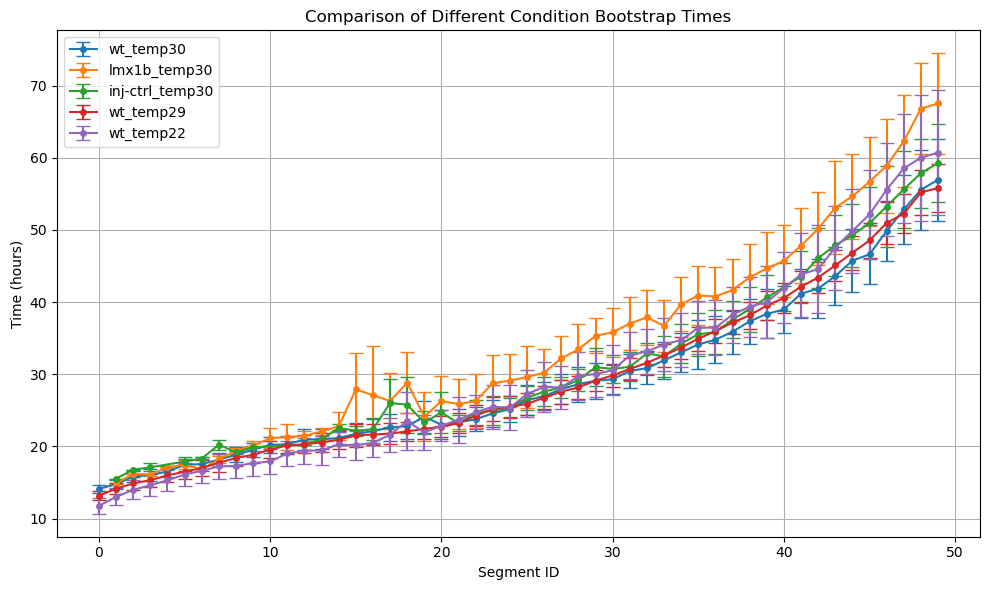

In [16]:

# Plot the comparison of bootstrap times across different conditions
plot_multi_bootstrap(
    data_list=data_list,
    labels=labels,
    title="Comparison of Different Condition Bootstrap Times",
    use_time_init=True  # Set to False if you don't want an offset
)

In [ ]:
wt_30_spline = data_list[0][0]
wt_30_spline["mean_time_hours"] = (wt_30_spline["mean_time"] / (3600))
wt_30_spline

NameError: name 'data_list' is not defined

/tmp/9345736.1.trapnell-login.q/ipykernel_2200385/659675720.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/9345736.1.trapnell-login.q/ipykernel_2200385/659675720.py:224: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


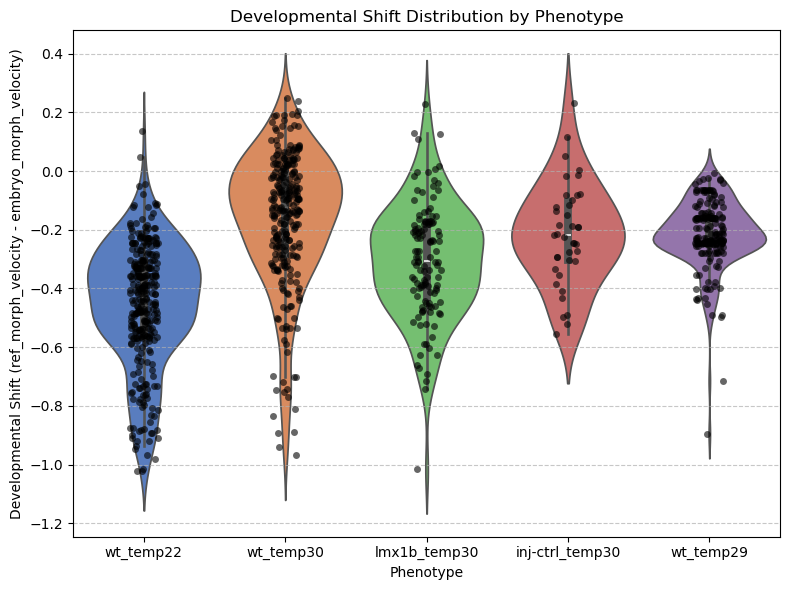

In [18]:
# Assuming shift_df is your DataFrame

shift_df = compute_developmental_shifts(
    df_embryos=df_augmented_projec_wt,
    summary_df_wt_calc=wt_30_spline,
    color_by="phenotype"
)


plot_developmental_shifts_violin(shift_df, color_by="phenotype")# Assuming shift_df is your DataFrame

In [ ]:
shift_df.to_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/tempnlmx1bshiftdf.csv")
shift_df
